# Exploration on mQTL significant at Bonferroni $\alpha < 0.05$
1. SNP-level and effect size exploration (read through current draft)
1. CpG-level counting
1. Gene-level counting and enrichment (export genes to FUMA for analysis)

In [1]:
library(here)
library(data.table)
library(tidyverse)
library(VennDiagram)
library(eulerr)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: grid

Loading required package: futile.logger



In [3]:
# Reading in significant mQTL
male < -fread(here("data", "delahaye_richs_male_bonf_maf05.txt.gz"))
female < -fread(here("data", "delahaye_richs_female_bonf_maf05.txt.gz"))
sex_interaction < -fread(
    here("data", "delahaye_richs_sex_interaction_bonf_maf05.txt.gz")
)
marginal < -fread(here("data", "delahaye_richs_marginal_bonf_maf05.txt.gz"))

## Effect size differences

In [4]:
male_int <- male[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]
female_int <- female[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]

V1,V2,N
<int>,<int>,<int>
2604,351,2876


V1,V2,N
<int>,<int>,<int>
1760,255,1981


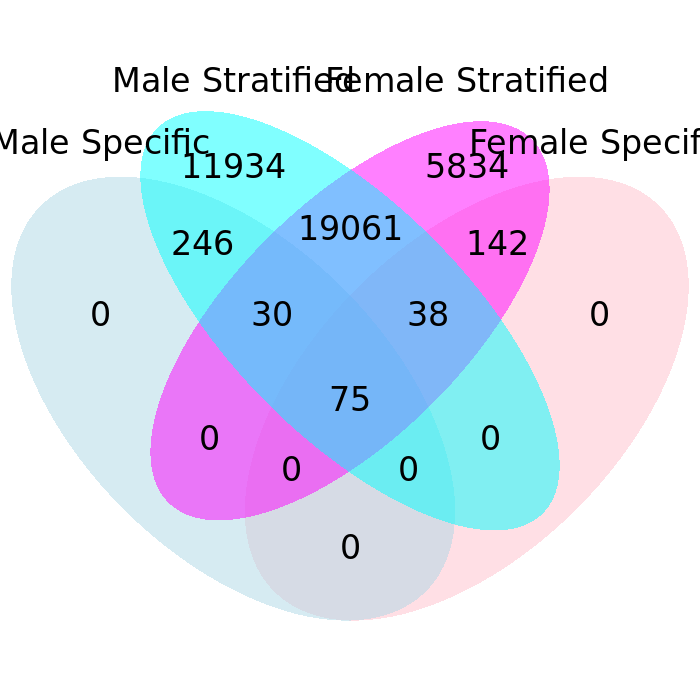

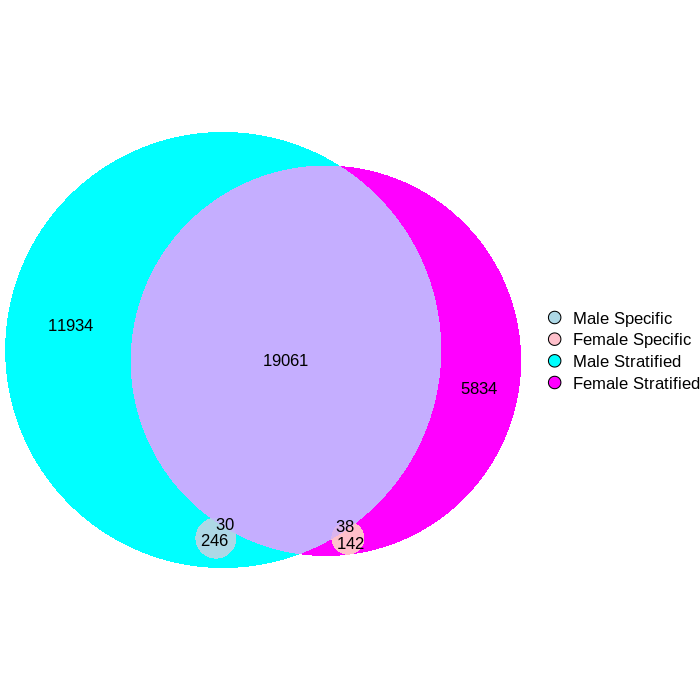

In [20]:
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 100)
library(eulerr)
male_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
female_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
plot_input <- list(
            `Male Specific` = unique(male_int$Probe),
            `Female Specific` = unique(female_int$Probe),
            `Male Stratified` = unique(male$Probe),
            `Female Stratified` = unique(female$Probe)
        )

grid.draw(
    venn.diagram(
        plot_input,
        filename=NULL,
        fill=c("light blue", "pink","cyan","magenta"),
        cat.pos=c(0,0,0,0),
        lty = rep("blank",4),
        cex=2,
        cat.cex=2,
        main.cex=3,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",4),
        cat.fontfamily= rep("sans-serif",4),
    )
)
plot(
    euler(plot_input),
    quantities=TRUE,
    fills = list(fill=c("light blue", "pink","cyan","magenta")),
    legend=list(names(plot_input)),
    adjust_labels=TRUE,
    lty=0
)

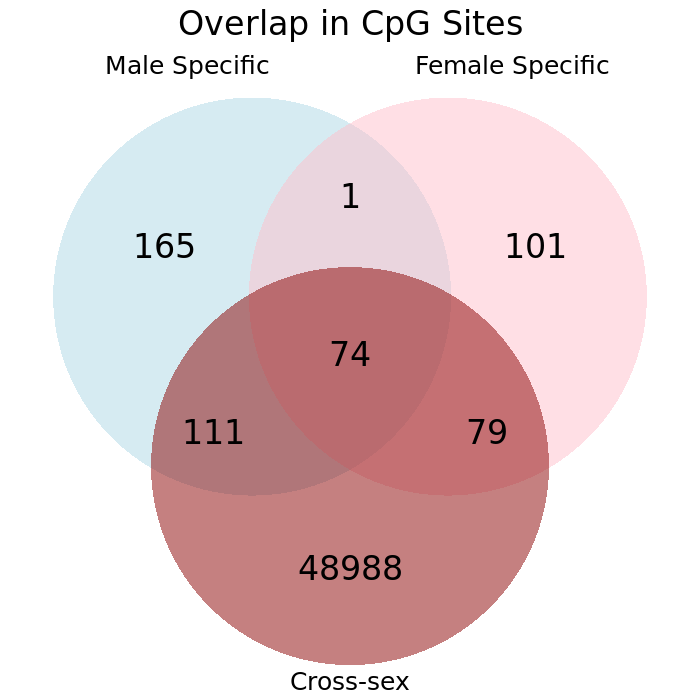

In [5]:
grid.draw(
    venn.diagram(
        list("Male Specific" = unique(male_int$Probe), "Female Specific" = unique(female_int$Probe),"Cross-sex" = unique(marginal$Probe)),
        filename=NULL,
        fill=c("light blue", "pink", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

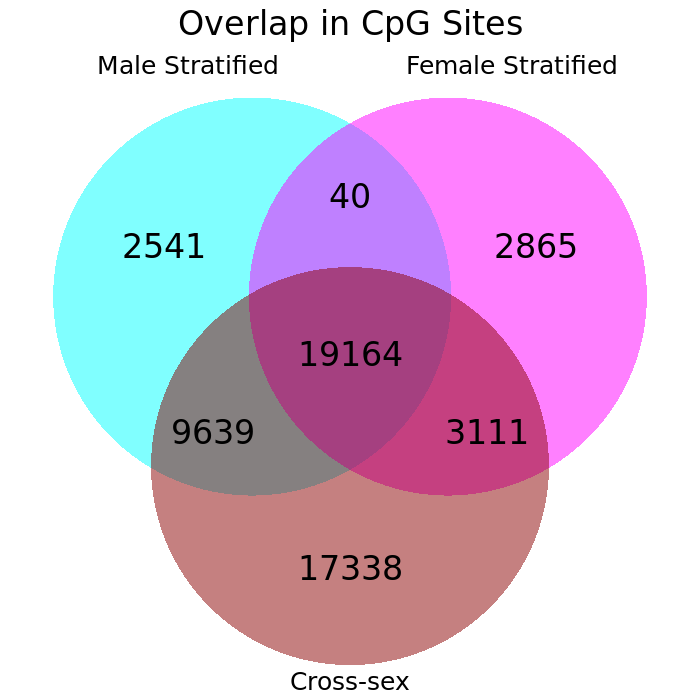

In [6]:
grid.draw(
    venn.diagram(
        list("Male Stratified"= unique(male$Probe), "Female Stratified" = unique(female$Probe),"Cross-sex" = unique(marginal$Probe)),
        filename=NULL,
        fill=c("cyan", "magenta", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

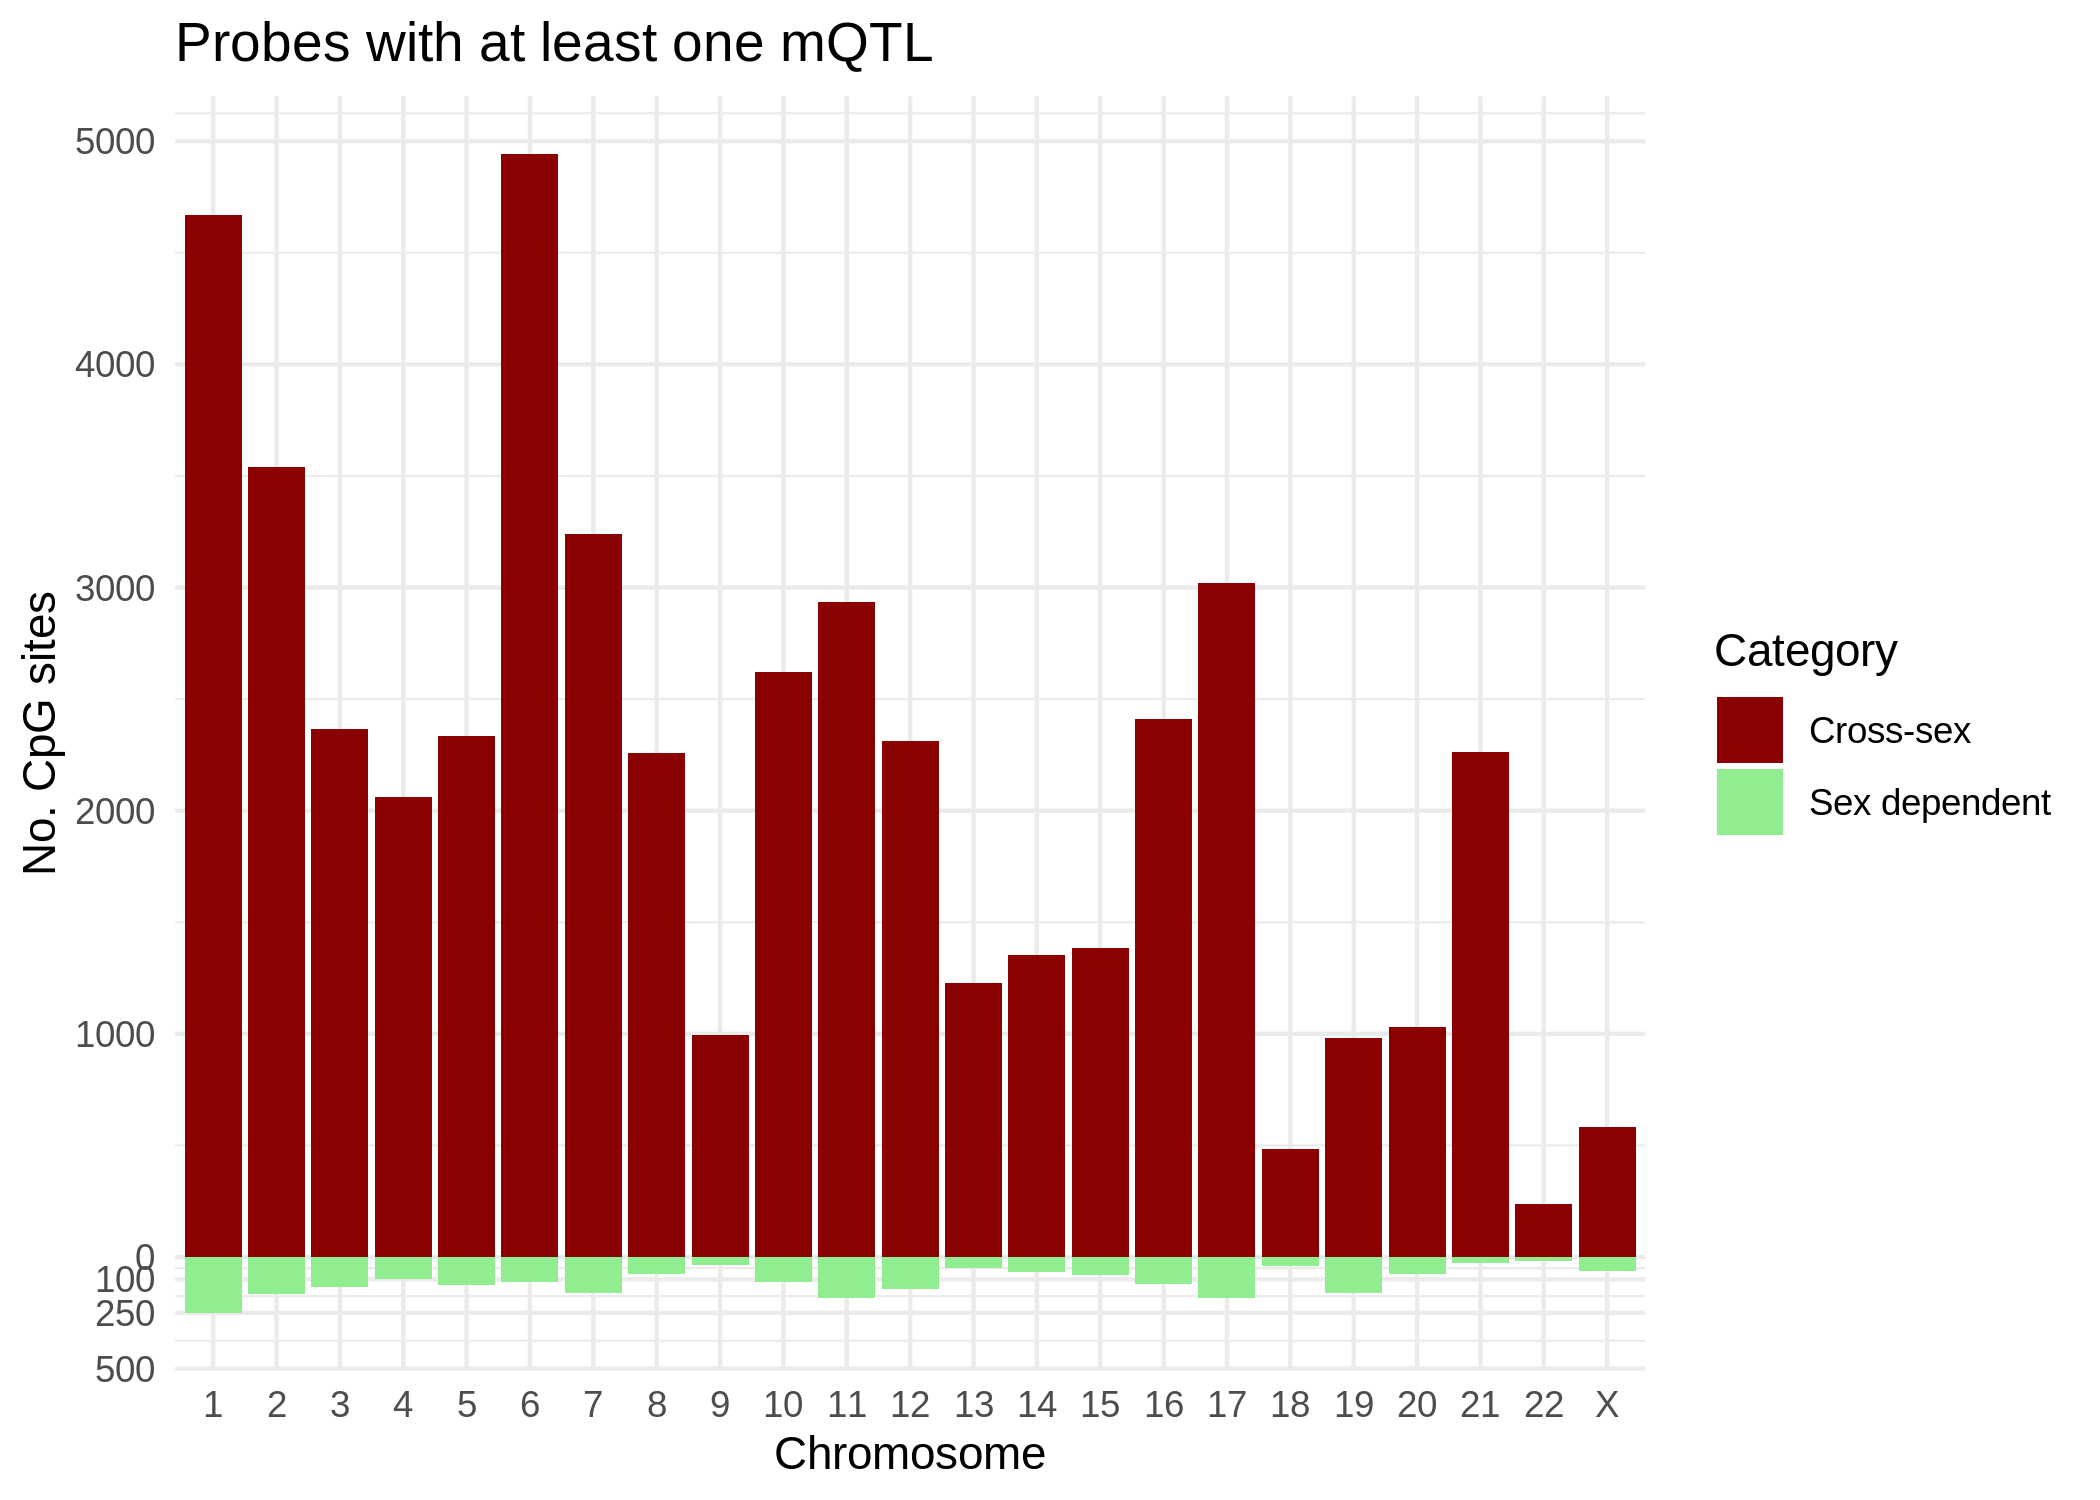

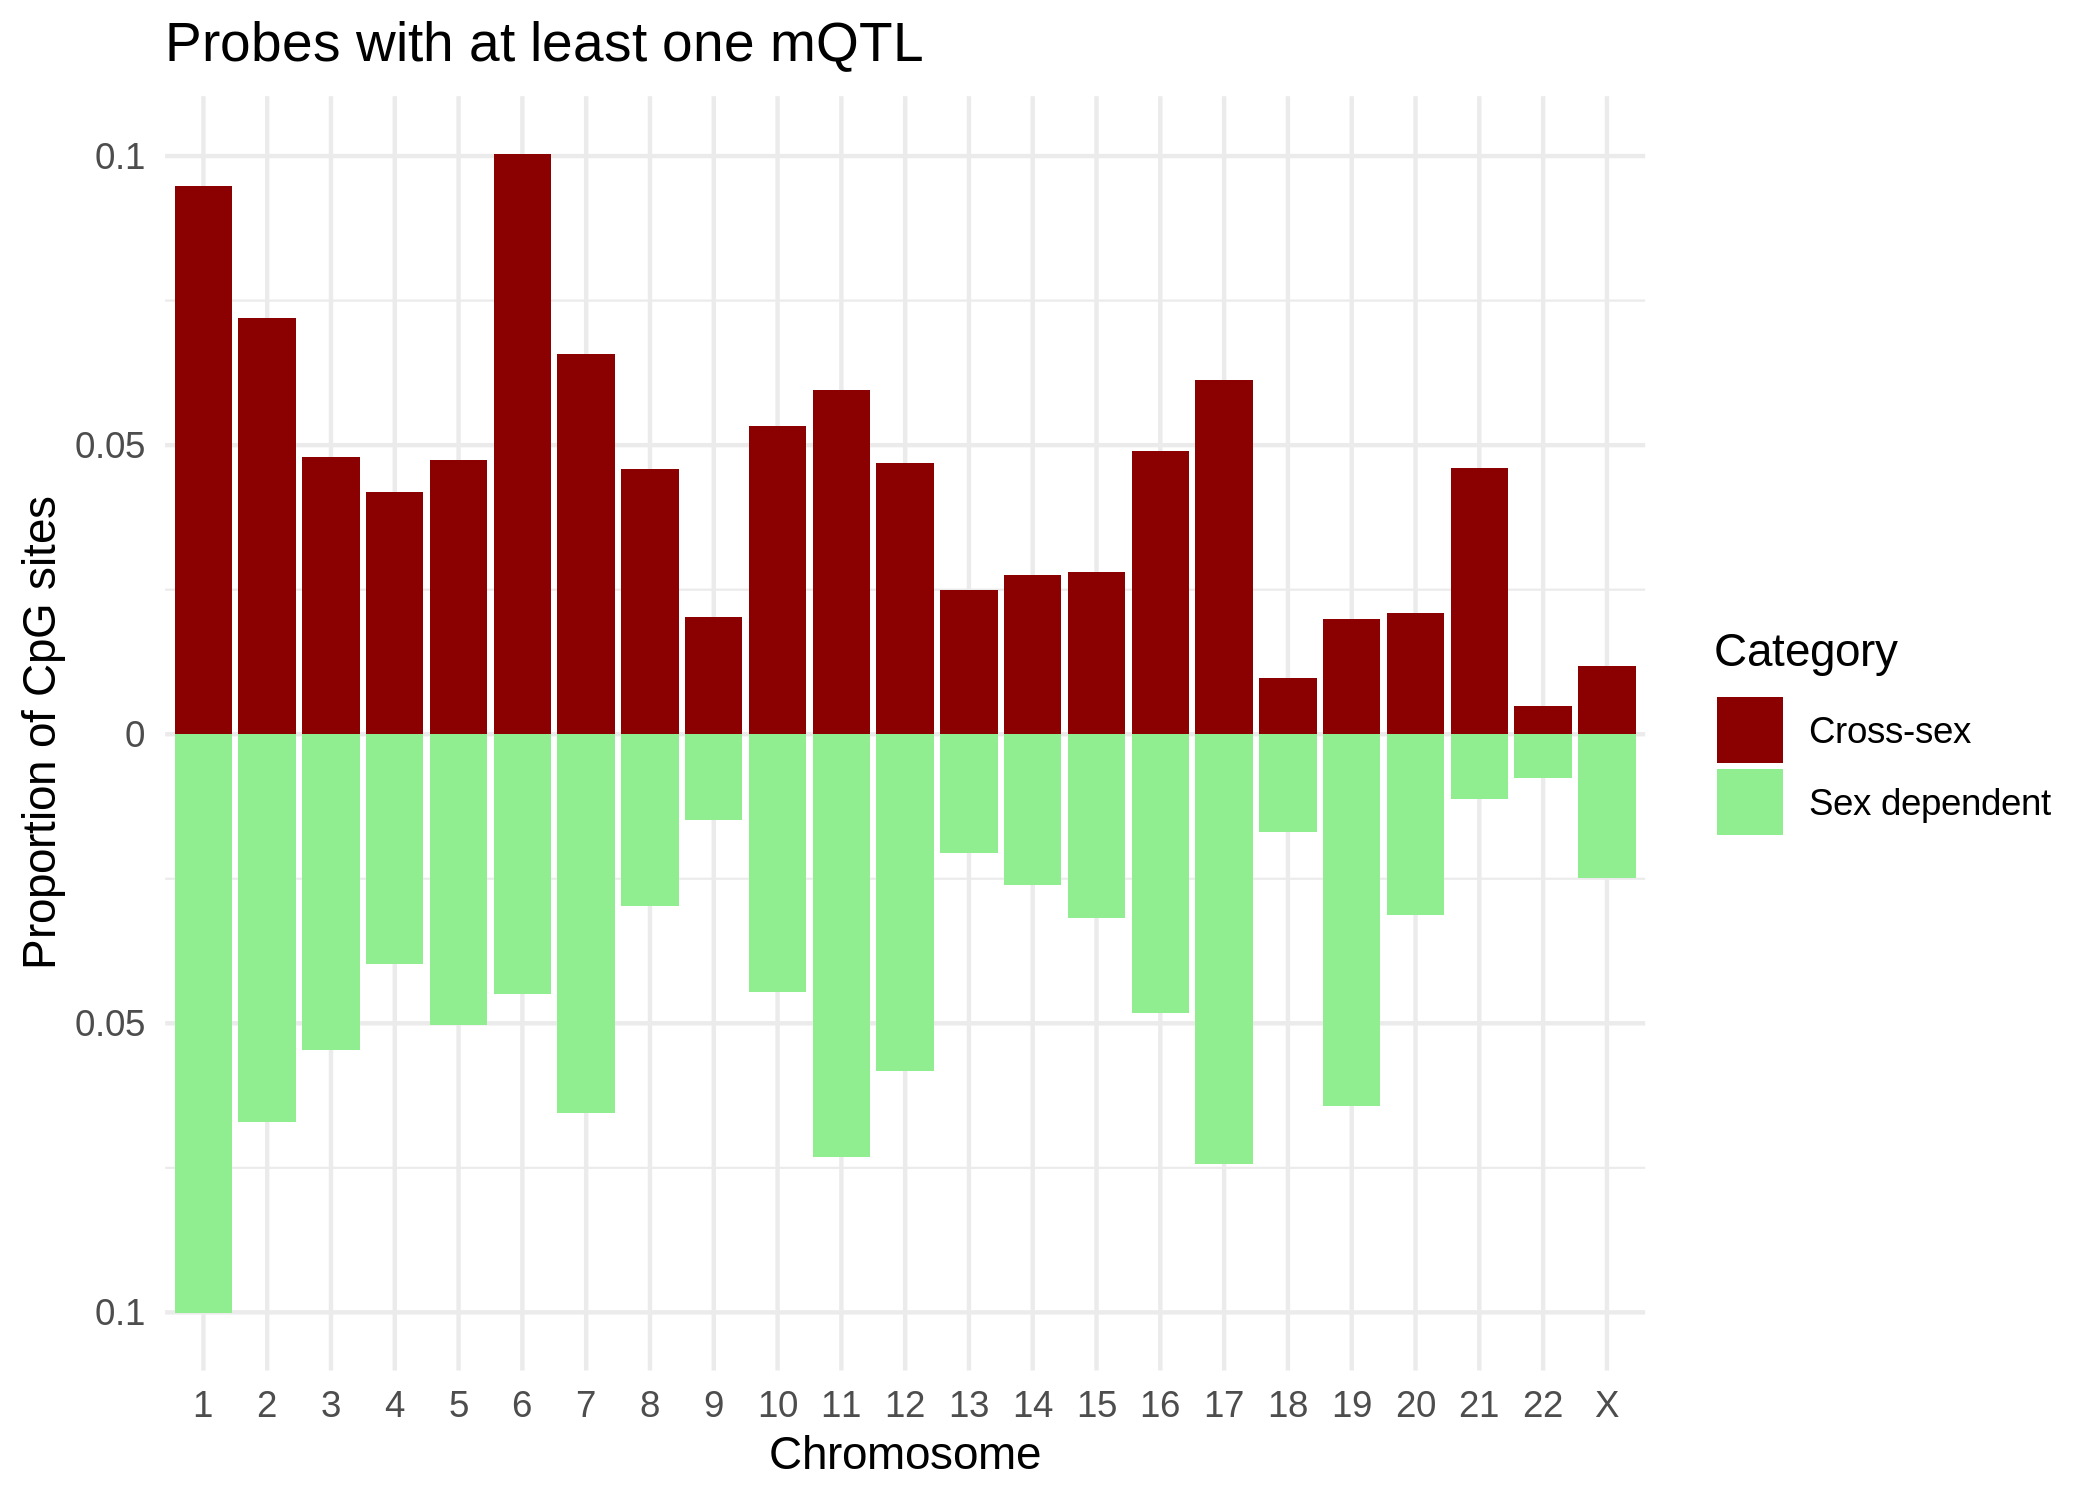

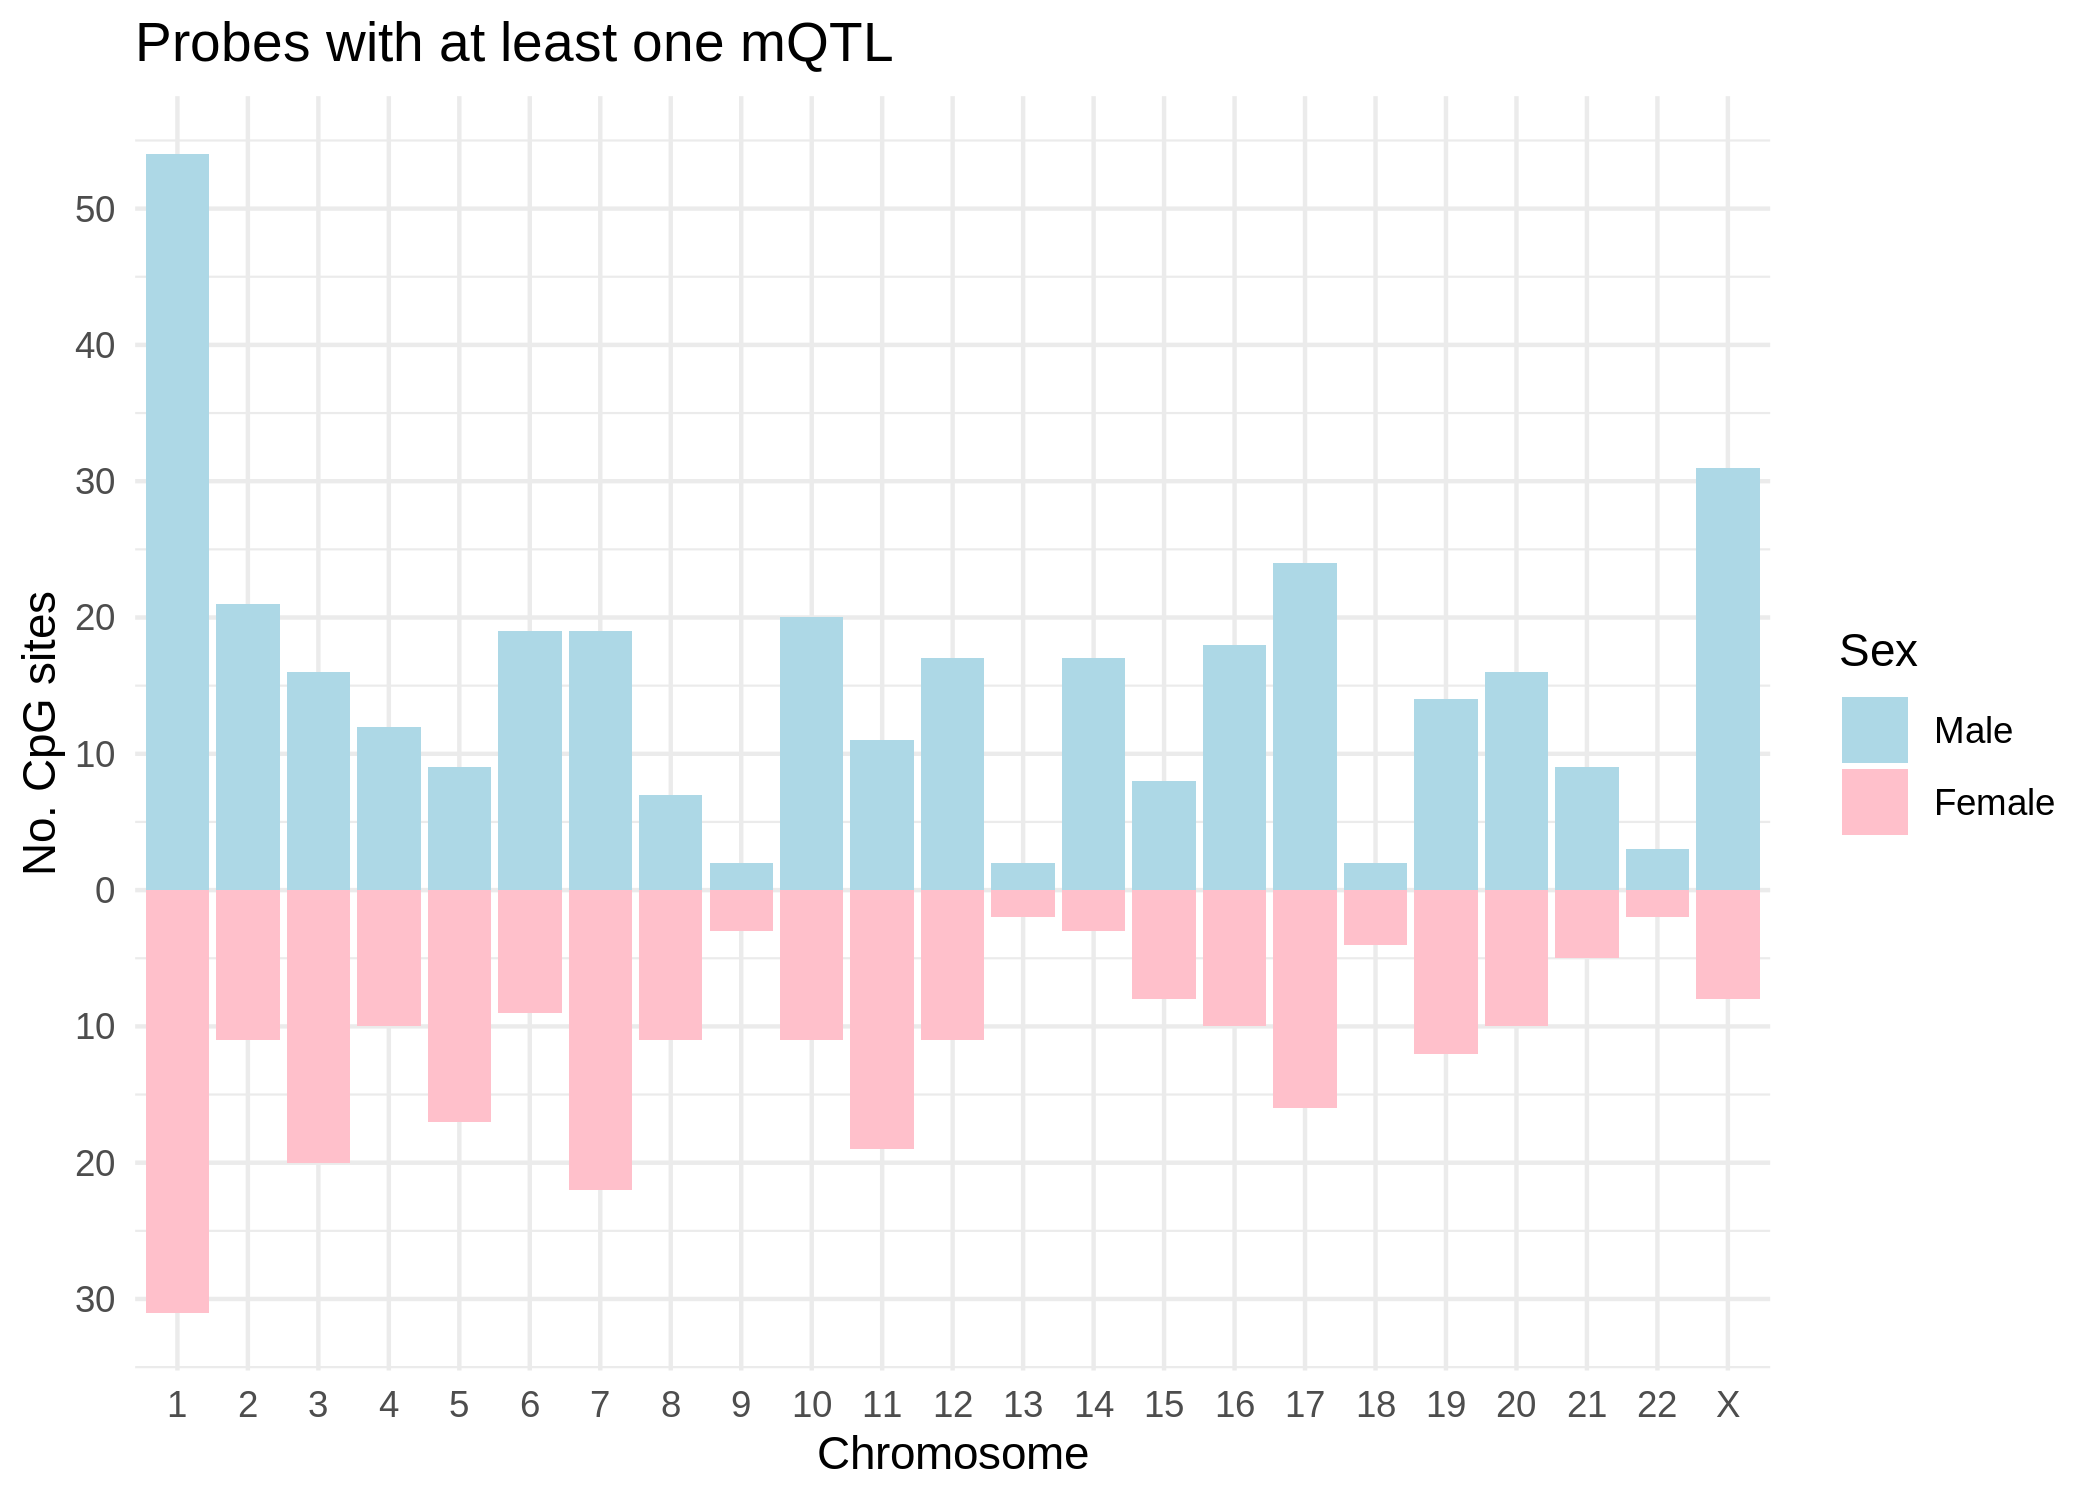

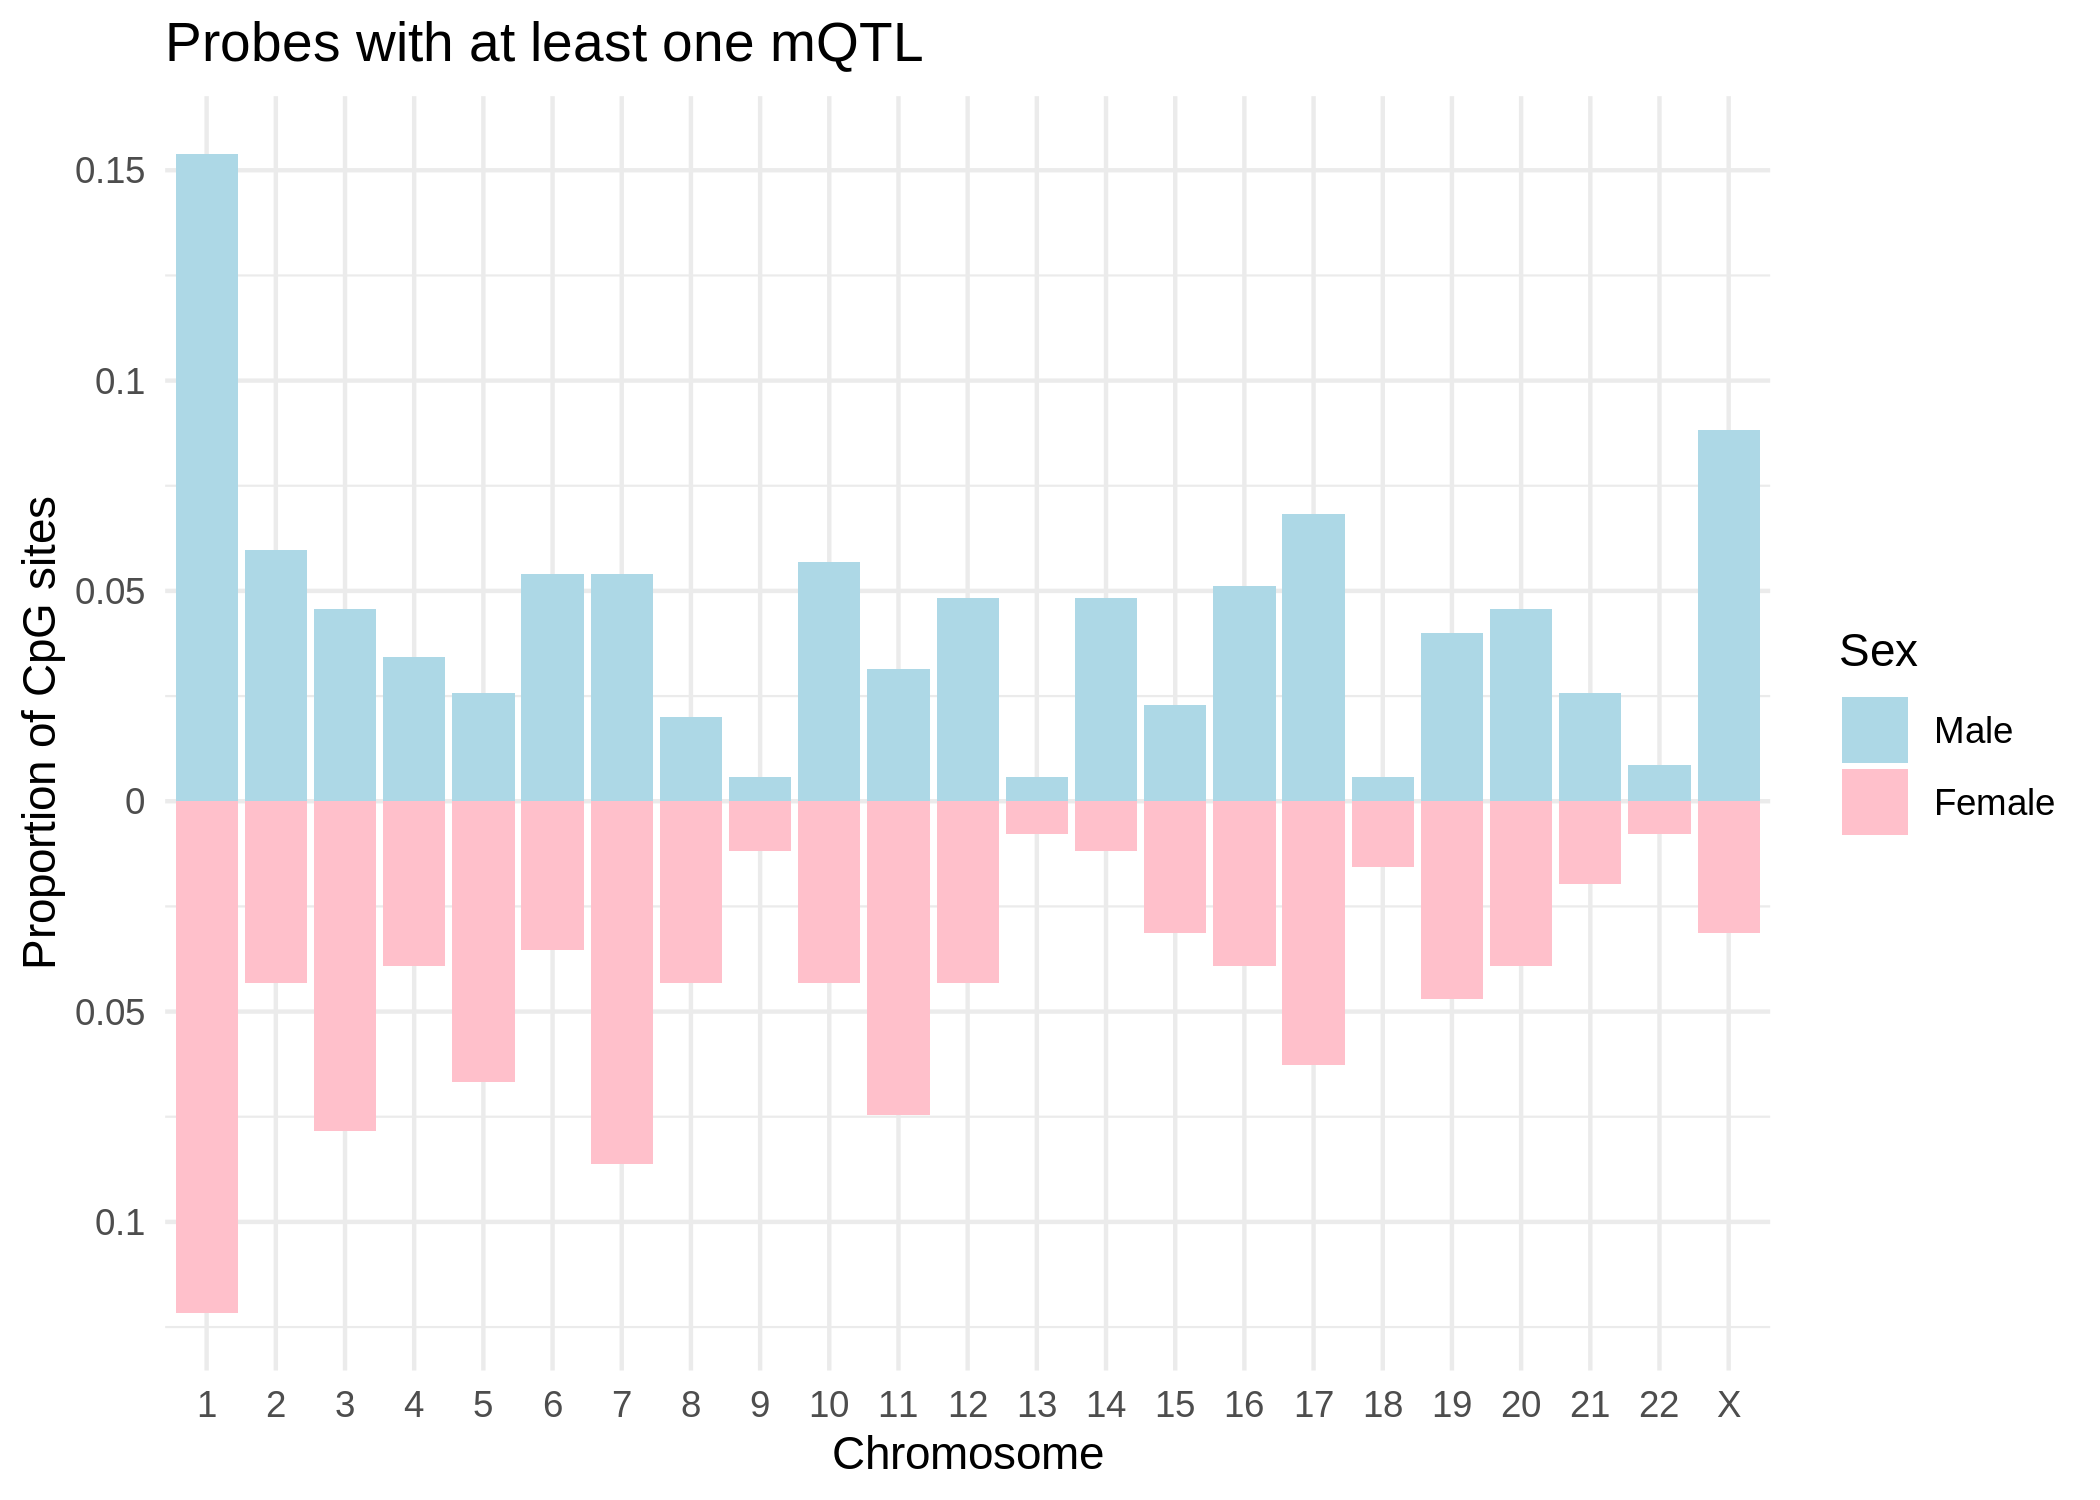

Warning message in cor.test.default(merged_int$b.x, merged_int$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_sex$b.x, merged_sex$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”


[1] 0

[1] 4.858727e-05

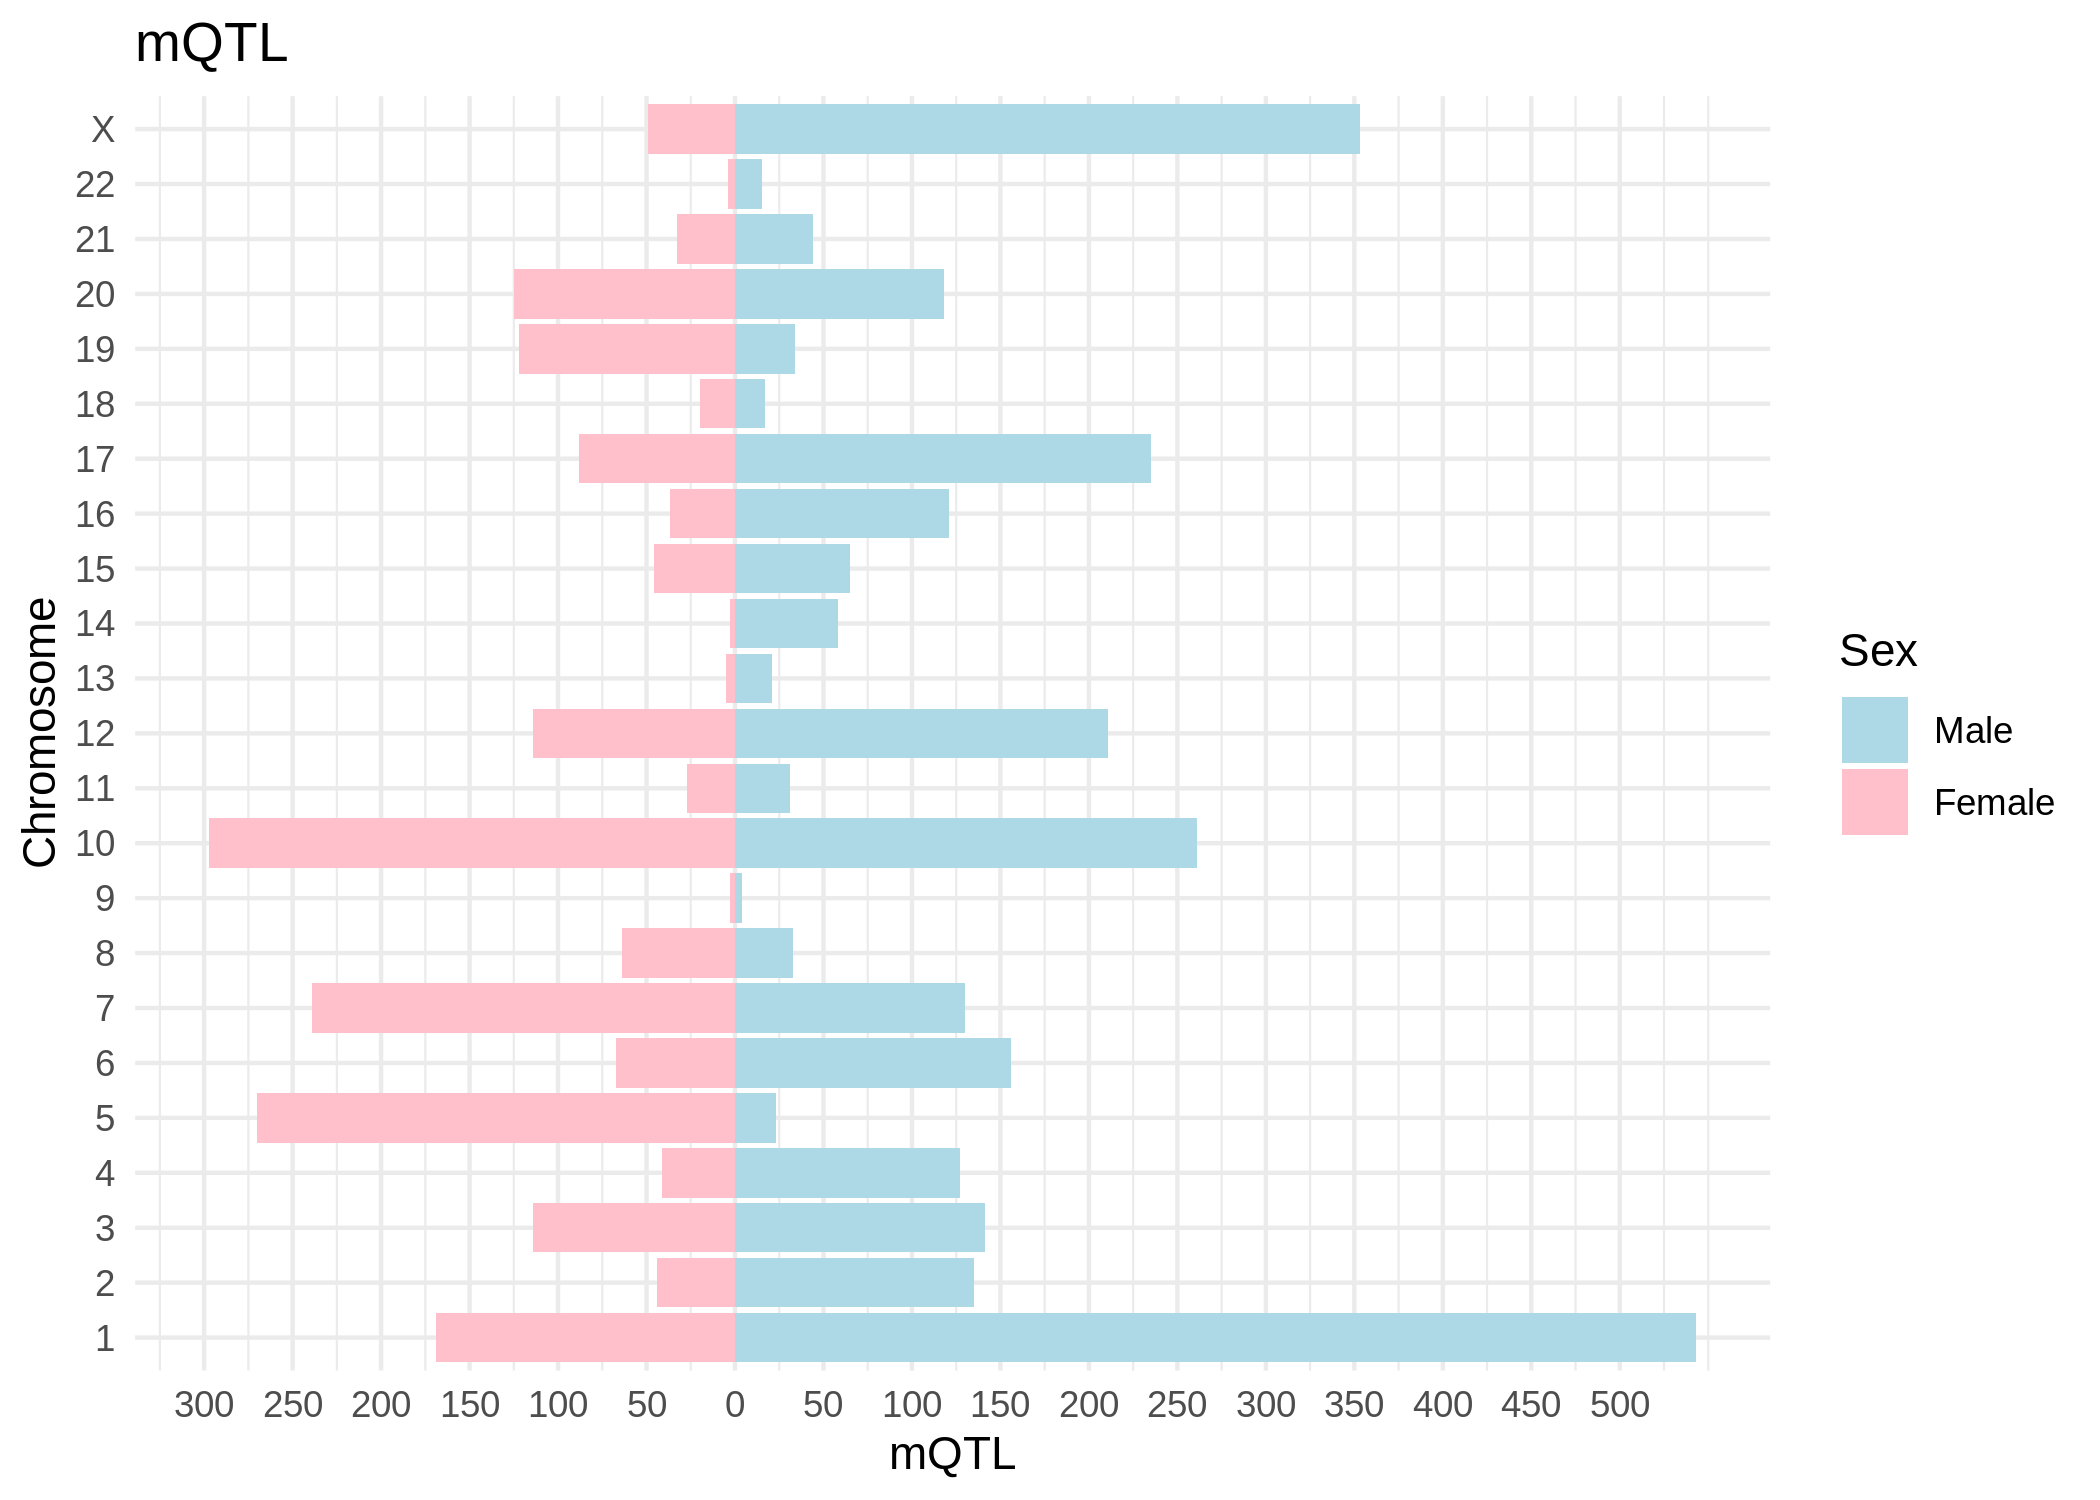

Chr,nprobe,mQTL,Sex,prop
<fct>,<int>,<int>,<fct>,<dbl>
1,54,543,Male,0.153846154
2,21,135,Male,0.059829060
3,16,141,Male,0.045584046
4,12,127,Male,0.034188034
5,9,23,Male,0.025641026
6,19,156,Male,0.054131054
7,19,130,Male,0.054131054
8,7,33,Male,0.019943020
9,2,4,Male,0.005698006


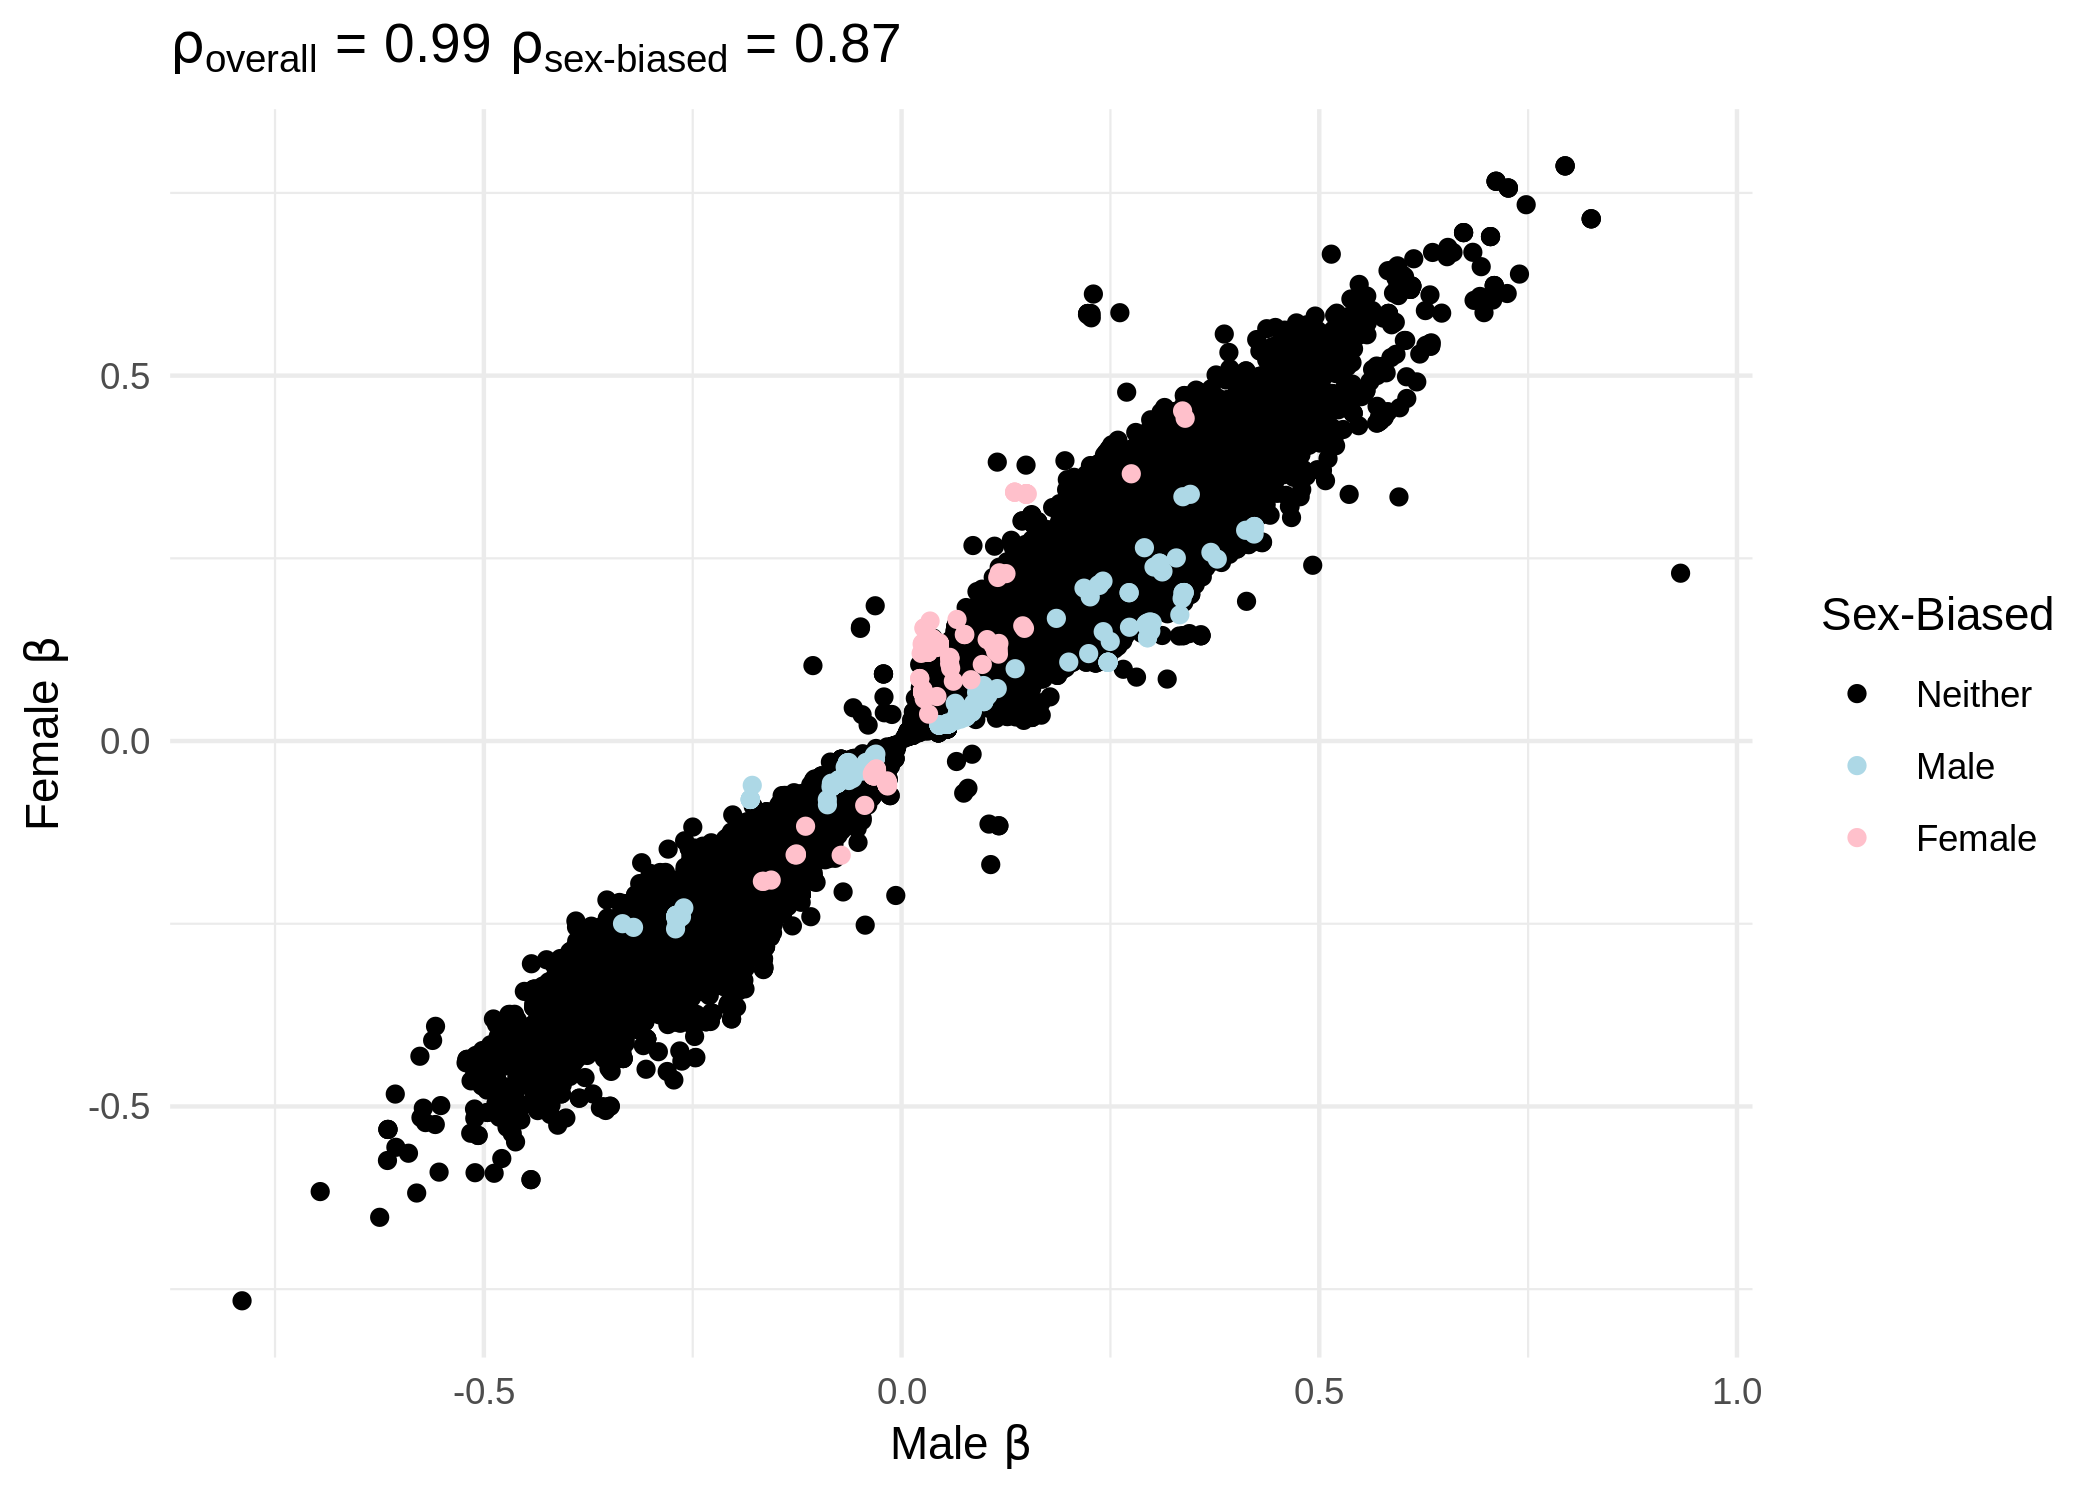

In [21]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
sex_int_count_dt <- sex_interaction[,.(nprobe=uniqueN(Probe),mQTL=.N),by="Chr"]
sex_int_count_dt$Chr <- factor(c(as.character(1:22),"X"),levels=c(as.character(1:22),"X"))
sex_int_count_dt$Category <- "Sex dependent"
sex_int_count_dt[,`:=`(mQTL= -mQTL, nprobe= -nprobe,prop = -nprobe/sum(nprobe))]
marginal_count_dt <- marginal[,.(nprobe=uniqueN(Probe),mQTL=.N),by="Chr"]
marginal_count_dt[,`:=`(prop = nprobe/sum(nprobe))]

marginal_count_dt$Chr <- factor(c(as.character(1:22),"X"),levels=c(as.character(1:22),"X"))
marginal_count_dt$Category <- "Cross-sex"
ggplot(rbind(marginal_count_dt,sex_int_count_dt),aes(Chr,nprobe,fill=Category))+
    geom_col() +
    labs(x="Chromosome",y="No. CpG sites", title = "Probes with at least one mQTL") +
    scale_fill_manual(values=c("Cross-sex"="dark red","Sex dependent"="light green")) +
    scale_y_continuous(breaks=c(-500,-250,-100,1000 * 0:5),labels=c(500,250,100,1000*0:5)) +
    theme_minimal()
ggplot(rbind(marginal_count_dt,sex_int_count_dt),aes(Chr,prop,fill=Category))+
    geom_col() +
    labs(x="Chromosome",y="Proportion of CpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-0.2,0.2,0.05),labels=c(seq(0.2,0,-0.05),seq(0.05,0.2,0.05)))+
    scale_fill_manual(values=c("Cross-sex"="dark red","Sex dependent"="light green")) +
    theme_minimal()
male_count <- male_int[,.(nprobe=uniqueN(Probe),mQTL = .N,Sex = "Male"),by="Chr"]
male_count[,`:=`(prop = nprobe/sum(nprobe))]
female_count <- female_int[,.(nprobe=-uniqueN(Probe),mQTL = -.N,Sex="Female"),by="Chr"]
female_count[,`:=`(prop = -nprobe/sum(nprobe))]
sex_count_dt <- rbindlist(
    list(male_count,female_count)
)
sex_effect_dt <- rbindlist(list(male_int[,`:=`(Sex="Male")],female_int[,`:=`(Sex="Female")]))
sex_effect_dt$Chr <- as.character(sex_effect_dt$Chr)
sex_effect_dt$Chr <- factor(ifelse(sex_effect_dt$Chr == "23","X",sex_effect_dt$Chr),levels =c(as.character(1:22),"X"))
sex_effect_dt$Sex <- factor(sex_effect_dt$Sex,levels=c("Male","Female"))
sex_count_dt$Chr <- factor(rep(c(as.character(1:22),"X"),2),levels=c(as.character(1:22),"X"))
sex_count_dt$Sex <- factor(sex_count_dt$Sex,levels=c("Male","Female"))

ggplot(sex_count_dt,aes(Chr,nprobe,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="No. CpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-50,50,10),labels=c(seq(50,0,-10),seq(10,50,10)))+
    #coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()

ggplot(sex_count_dt,aes(Chr,prop,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="Proportion of CpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-0.2,0.2,0.05),labels=c(seq(0.2,0,-0.05),seq(0.05,0.2,0.05)))+
    #coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()

ggplot(sex_count_dt,aes(Chr,mQTL,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="mQTL", title = "mQTL") +
    scale_y_continuous(breaks = seq(-500,500,50),labels=c(seq(500,0,-50),seq(50,500,50)))+
    coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()
merged_int <- merge(male_int,female_int, by = c("SNP","Probe"))
merged_sex <- merge(male,female, by = c("SNP","Probe"))
rho_interaction <- cor.test(merged_int$b.x,merged_int$b.y,method="spearman")$estimate
rho_sex <- cor.test(merged_sex$b.x,merged_sex$b.y,method="spearman")$estimate
nrow(merged_int[sign(b.x) != sign(b.y)]) / nrow(merged_int)
nrow(merged_sex[sign(b.x) != sign(b.y)]) / nrow(merged_sex)


ggplot(merged_sex %>%
        mutate(sex_biased = paste0(SNP,Probe) %in% paste0(sex_interaction$SNP,sex_interaction$Probe)) %>%
        mutate(sex_biased = factor(ifelse(sex_biased,ifelse(abs(b.x) > abs(b.y),"Male","Female"),"Neither"), levels = c("Neither","Male","Female"))) %>%arrange(sex_biased),
    aes(b.x,b.y,color=sex_biased) ) + 
    geom_point() +
    labs(
        x=bquote("Male"~beta),
        y=bquote("Female"~beta),color = "Sex-Biased",
        title = bquote(rho["overall"]~"="~.(round(rho_sex,2))~rho["sex-biased"]~"="~.(round(rho_interaction,2))))+
    scale_color_manual(values=c("black","light blue", "pink"))+
    theme_minimal()
sex_count_dt

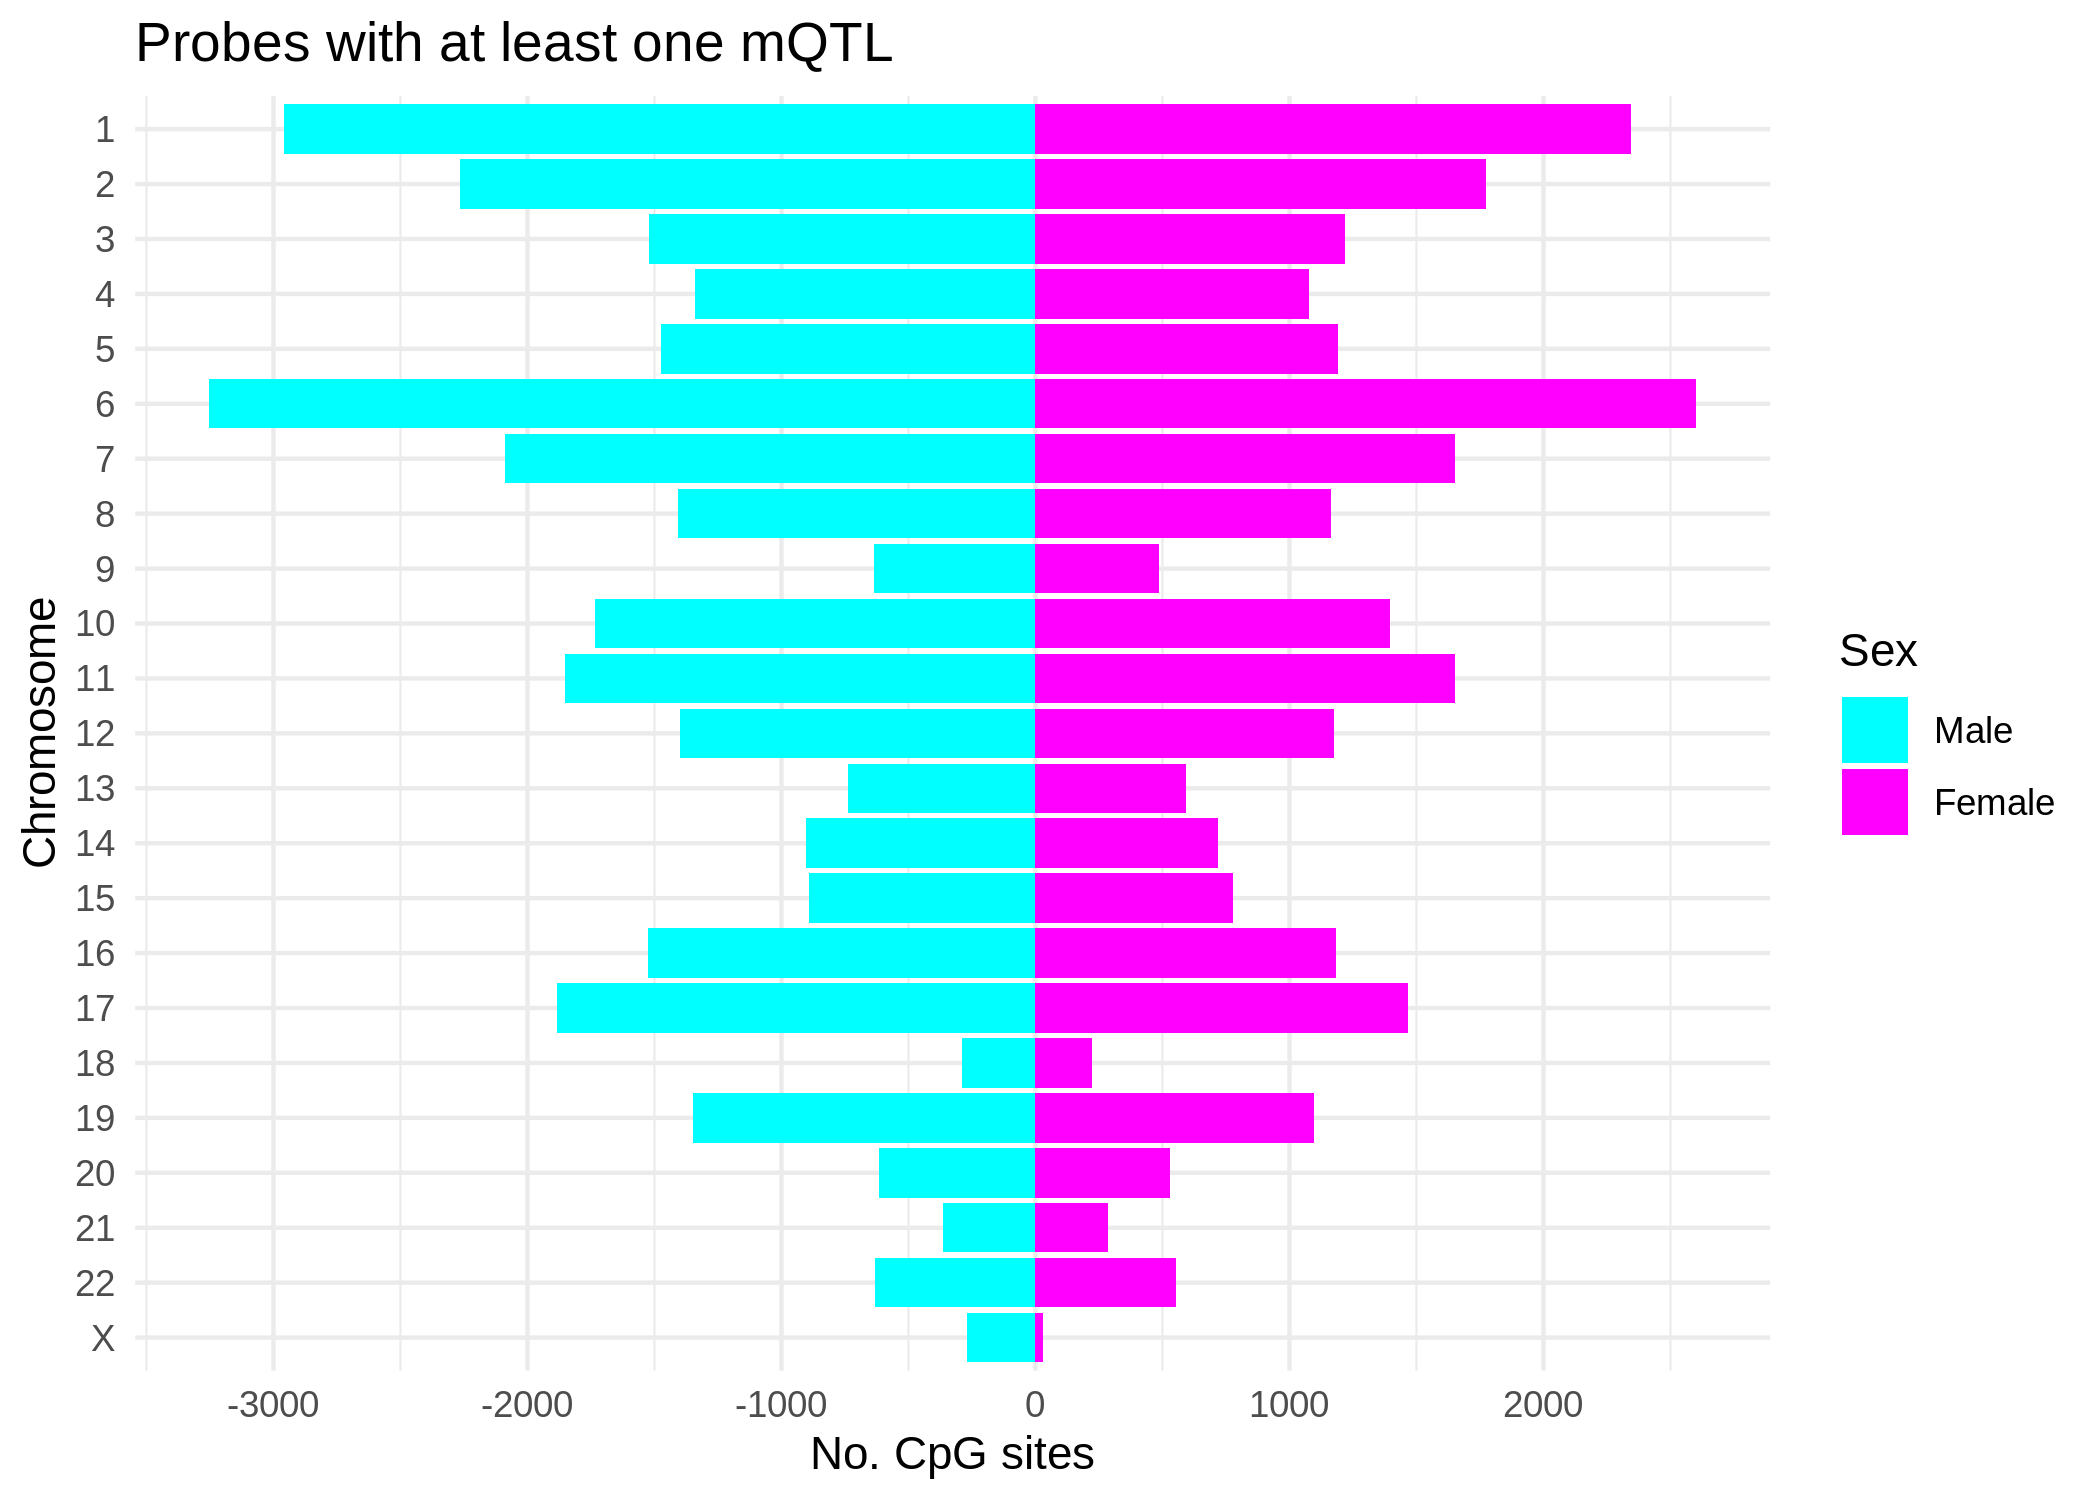

Chr,nprobe,mQTL,Sex
<fct>,<int>,<int>,<fct>
1,-2957,-73000,Male
2,-2265,-58634,Male
3,-1523,-36036,Male
4,-1339,-36082,Male
5,-1474,-37196,Male
6,-3252,-190055,Male
7,-2087,-58337,Male
8,-1408,-32003,Male
9,-634,-11692,Male


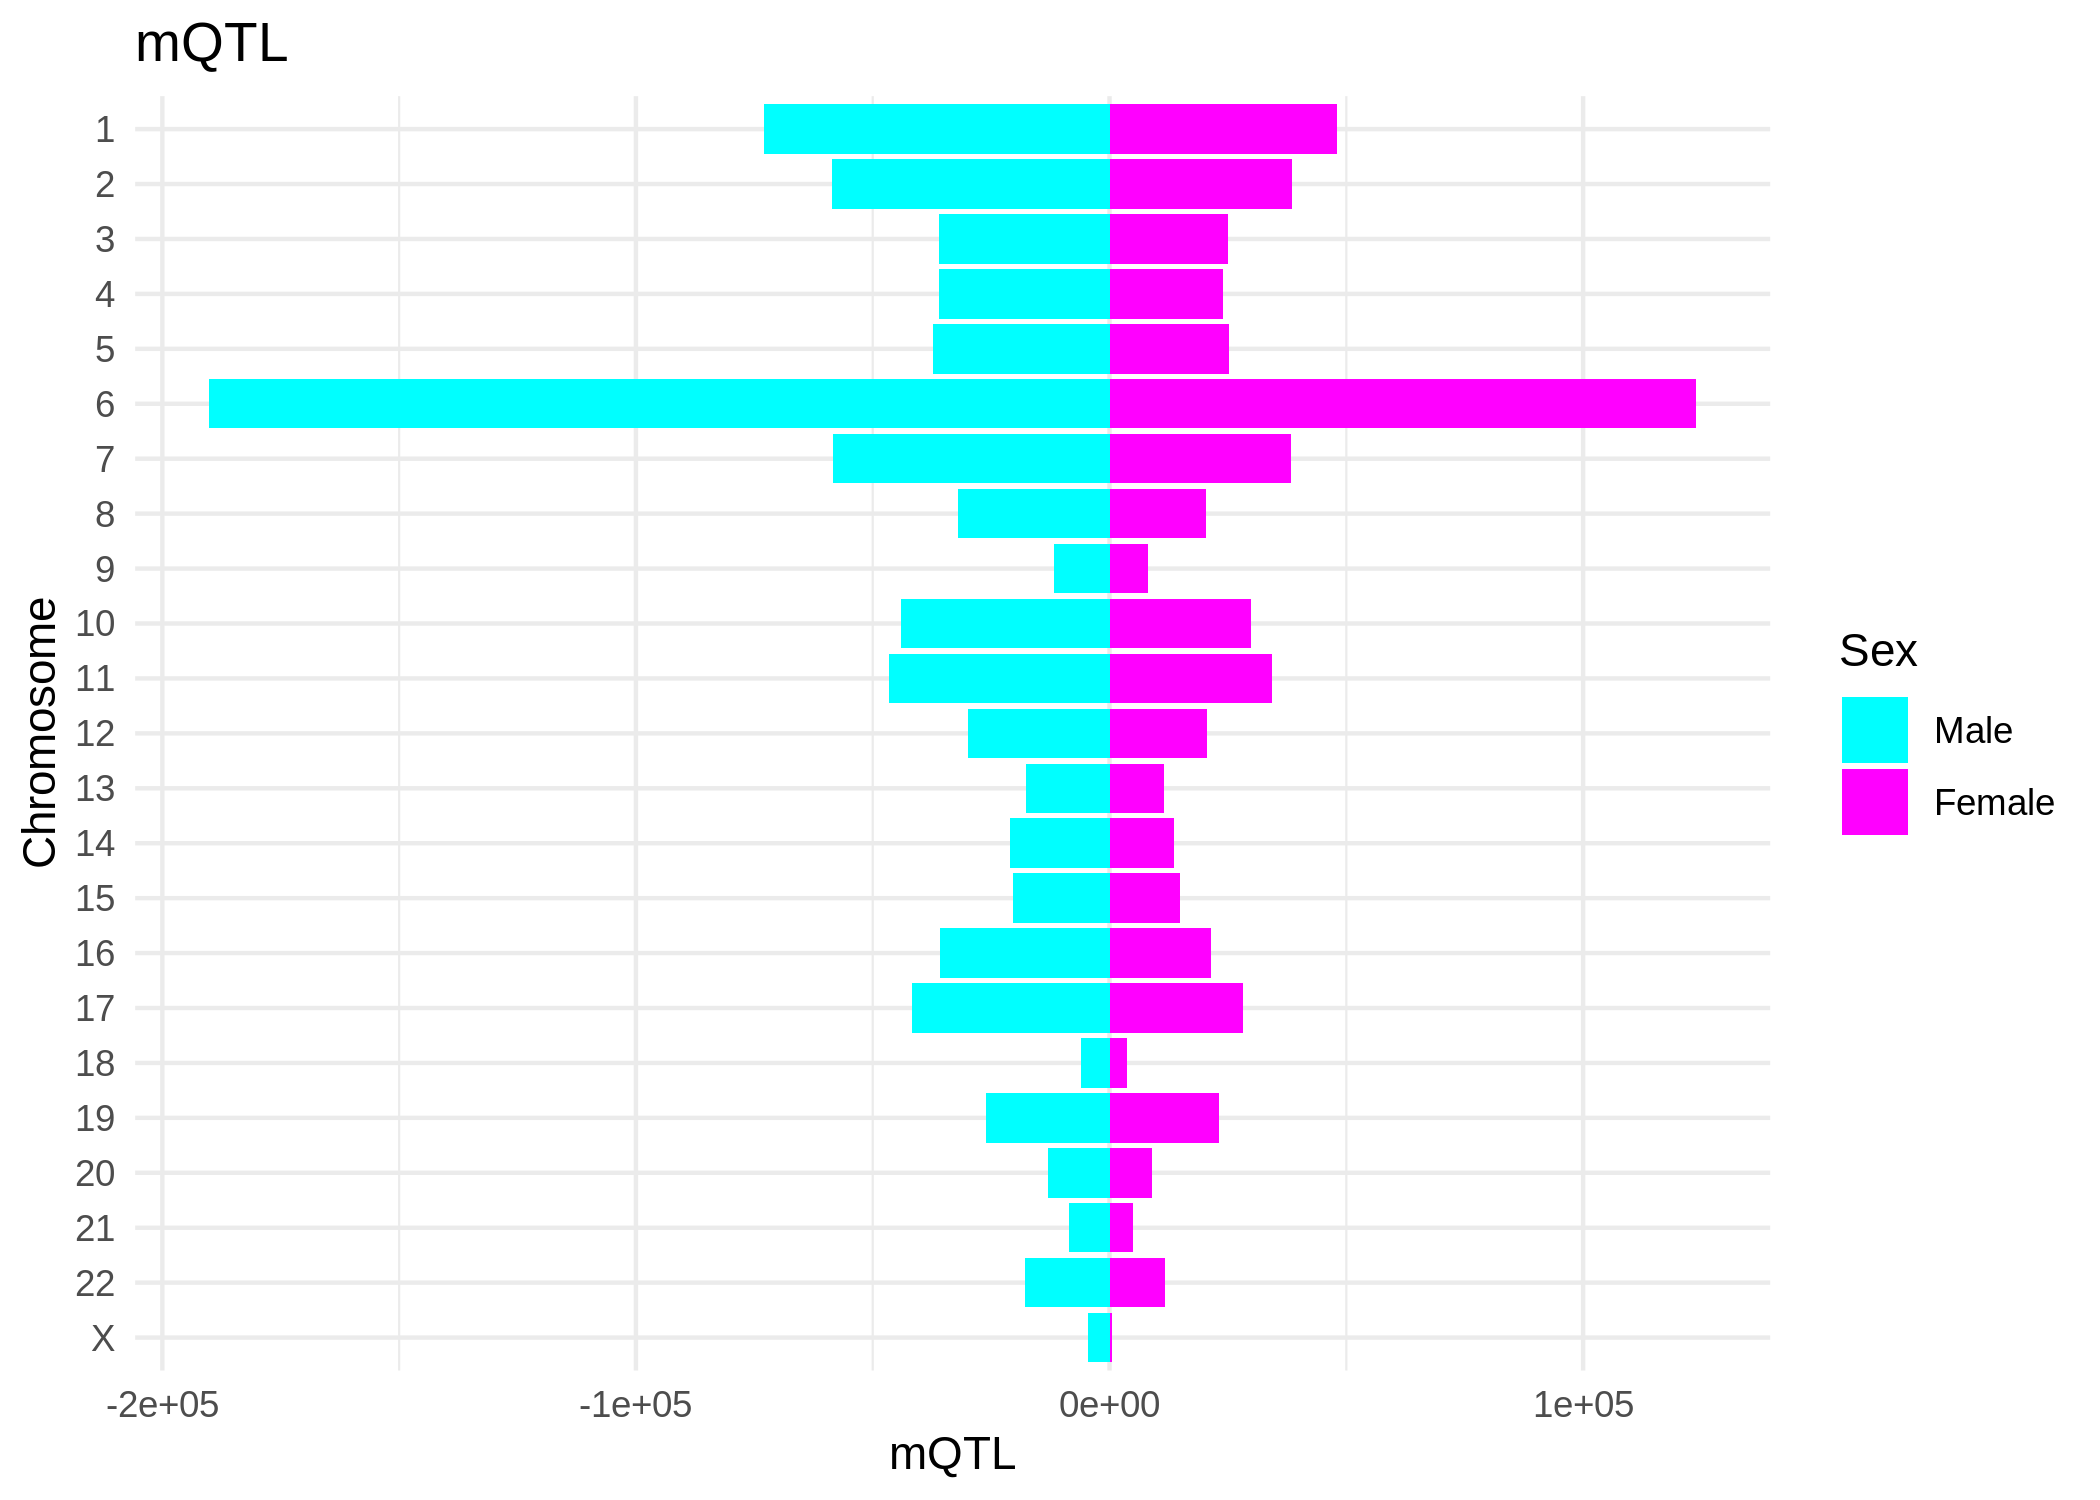

In [8]:
sex_strat_count_dt <- rbindlist(
    list(male[,.(nprobe=-uniqueN(Probe),mQTL = -.N,Sex = "Male"),by="Chr"],female[,.(nprobe=uniqueN(Probe),mQTL = .N,Sex="Female"),by="Chr"])
)
sex_strat_effect_dt <- rbindlist(list(male[,`:=`(Sex="Male")],female[,`:=`(Sex="Female")]))
sex_strat_effect_dt$Chr <- as.character(sex_strat_effect_dt$Chr)
sex_strat_effect_dt$Chr <- factor(ifelse(sex_strat_effect_dt$Chr == "23","X",sex_strat_effect_dt$Chr),levels =c(as.character(1:22),"X"))
sex_strat_effect_dt$Sex <- factor(sex_strat_effect_dt$Sex,levels=c("Male","Female"))
sex_strat_count_dt$Chr <- factor(rep(c(as.character(1:22),"X"),2),levels=rev(c(as.character(1:22),"X")))
sex_strat_count_dt$Sex <- factor(sex_strat_count_dt$Sex,levels=c("Male","Female"))

ggplot(sex_strat_count_dt,aes(Chr,nprobe,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="No. CpG sites", title = "Probes with at least one mQTL") +
    coord_flip() + 
    scale_fill_manual(values=c("cyan", "magenta"))+
    theme_minimal()
ggplot(sex_strat_count_dt,aes(Chr,mQTL,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="mQTL", title = "mQTL") +
    coord_flip() + 
    scale_fill_manual(values=c("cyan", "magenta"))+
    theme_minimal()
sex_strat_count_dt


Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate


Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.



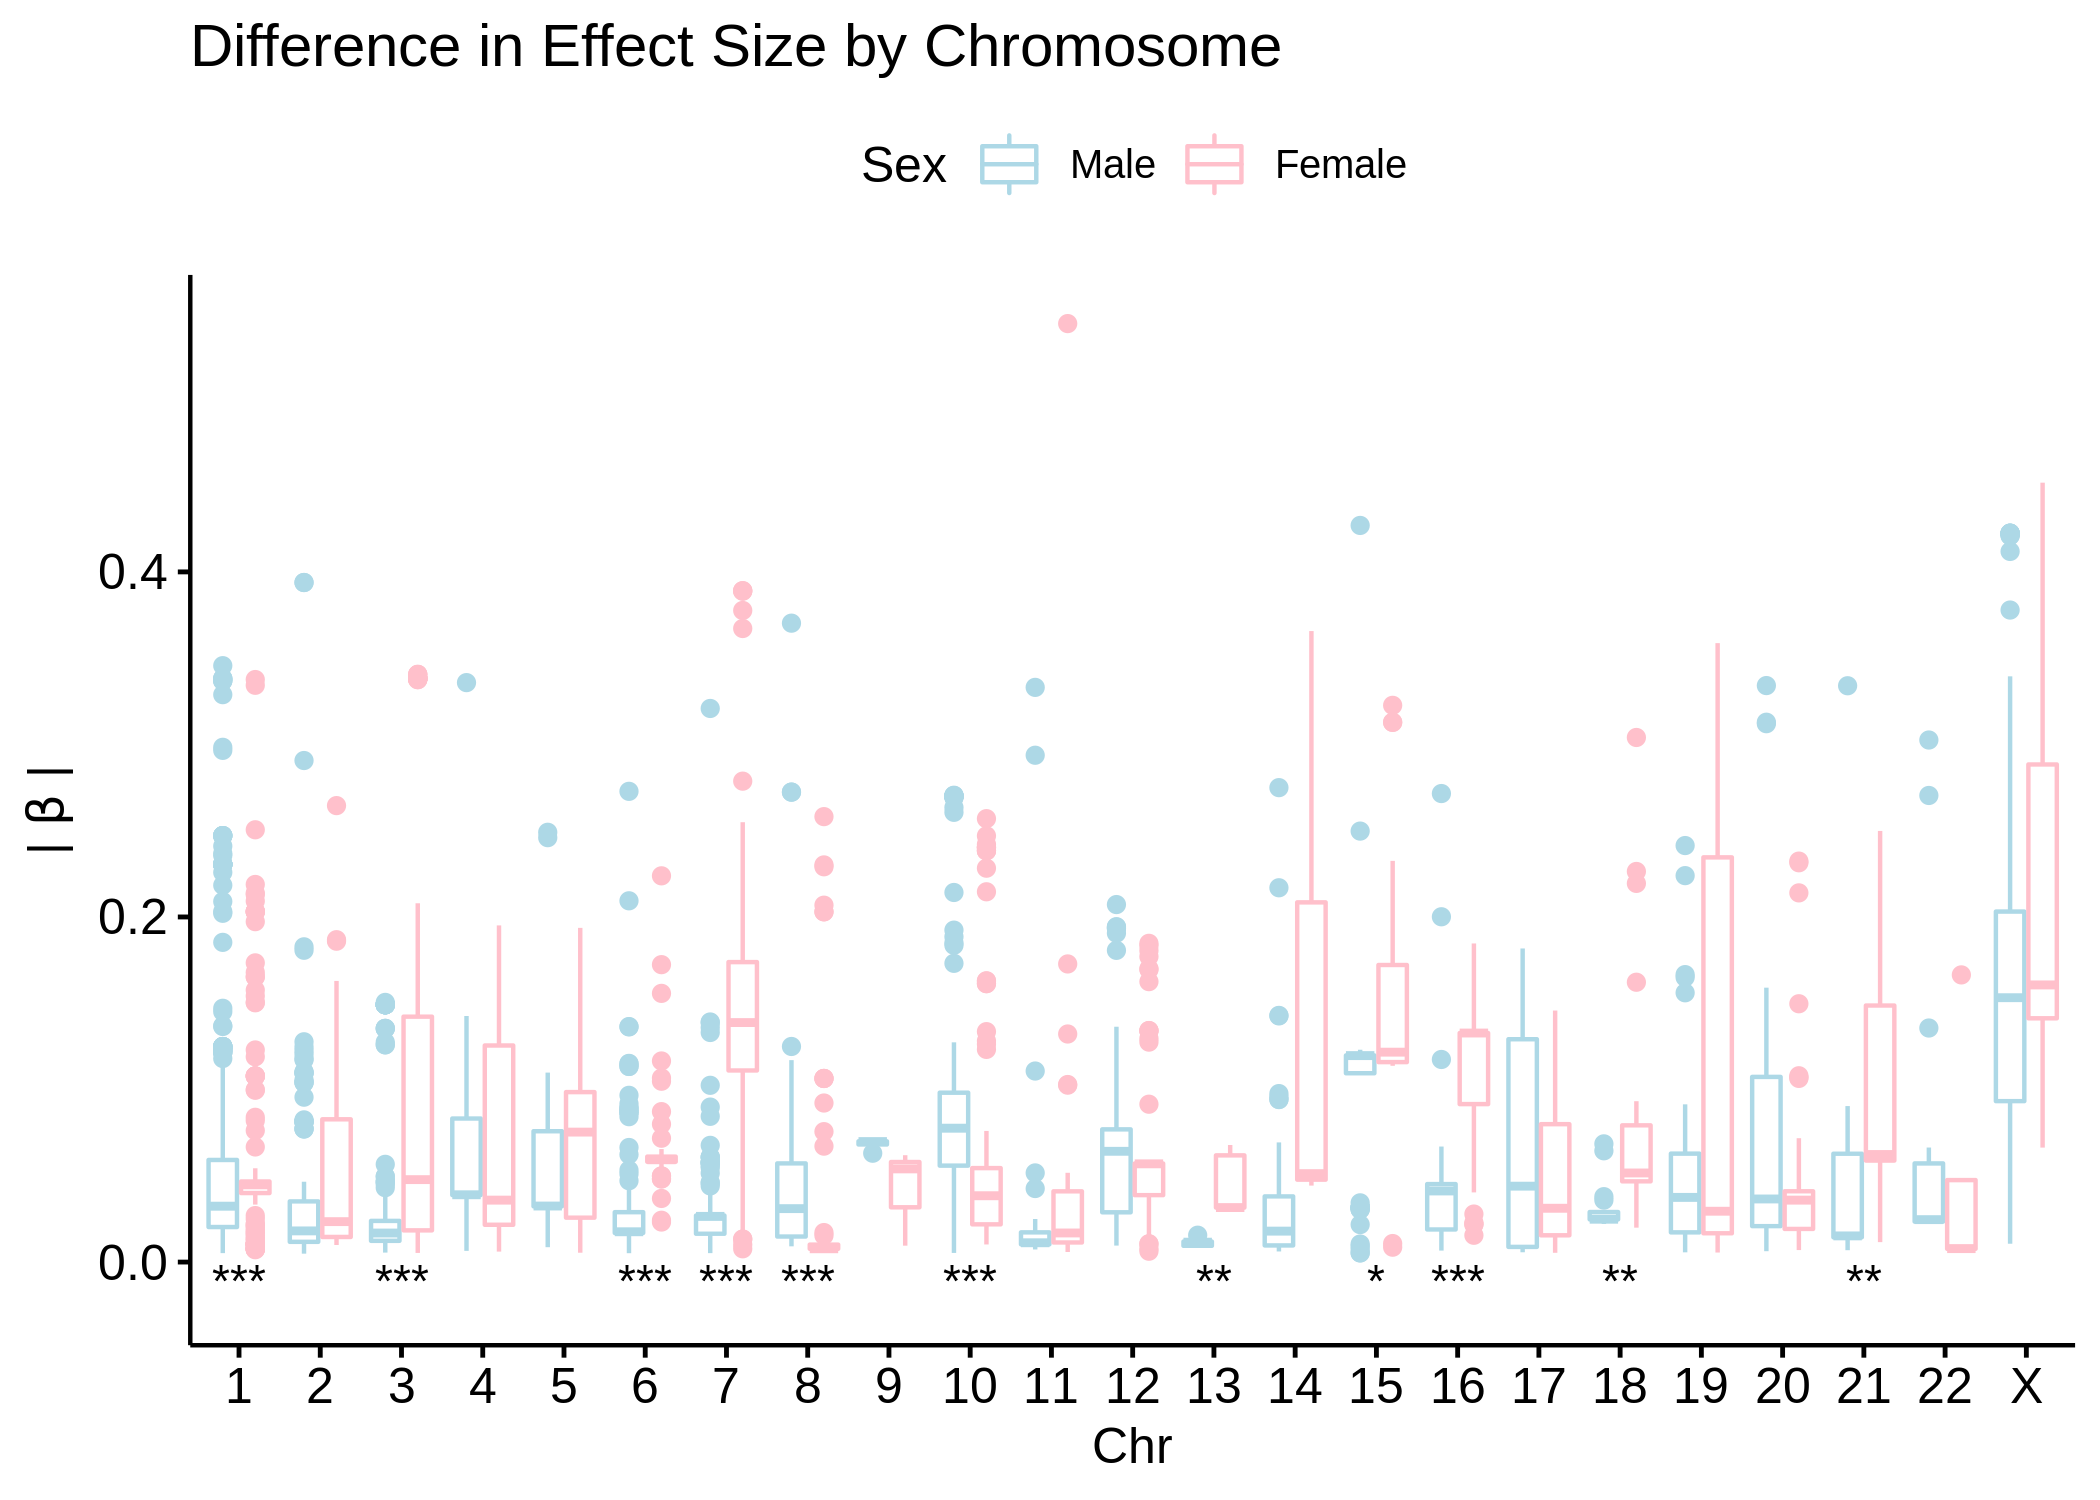

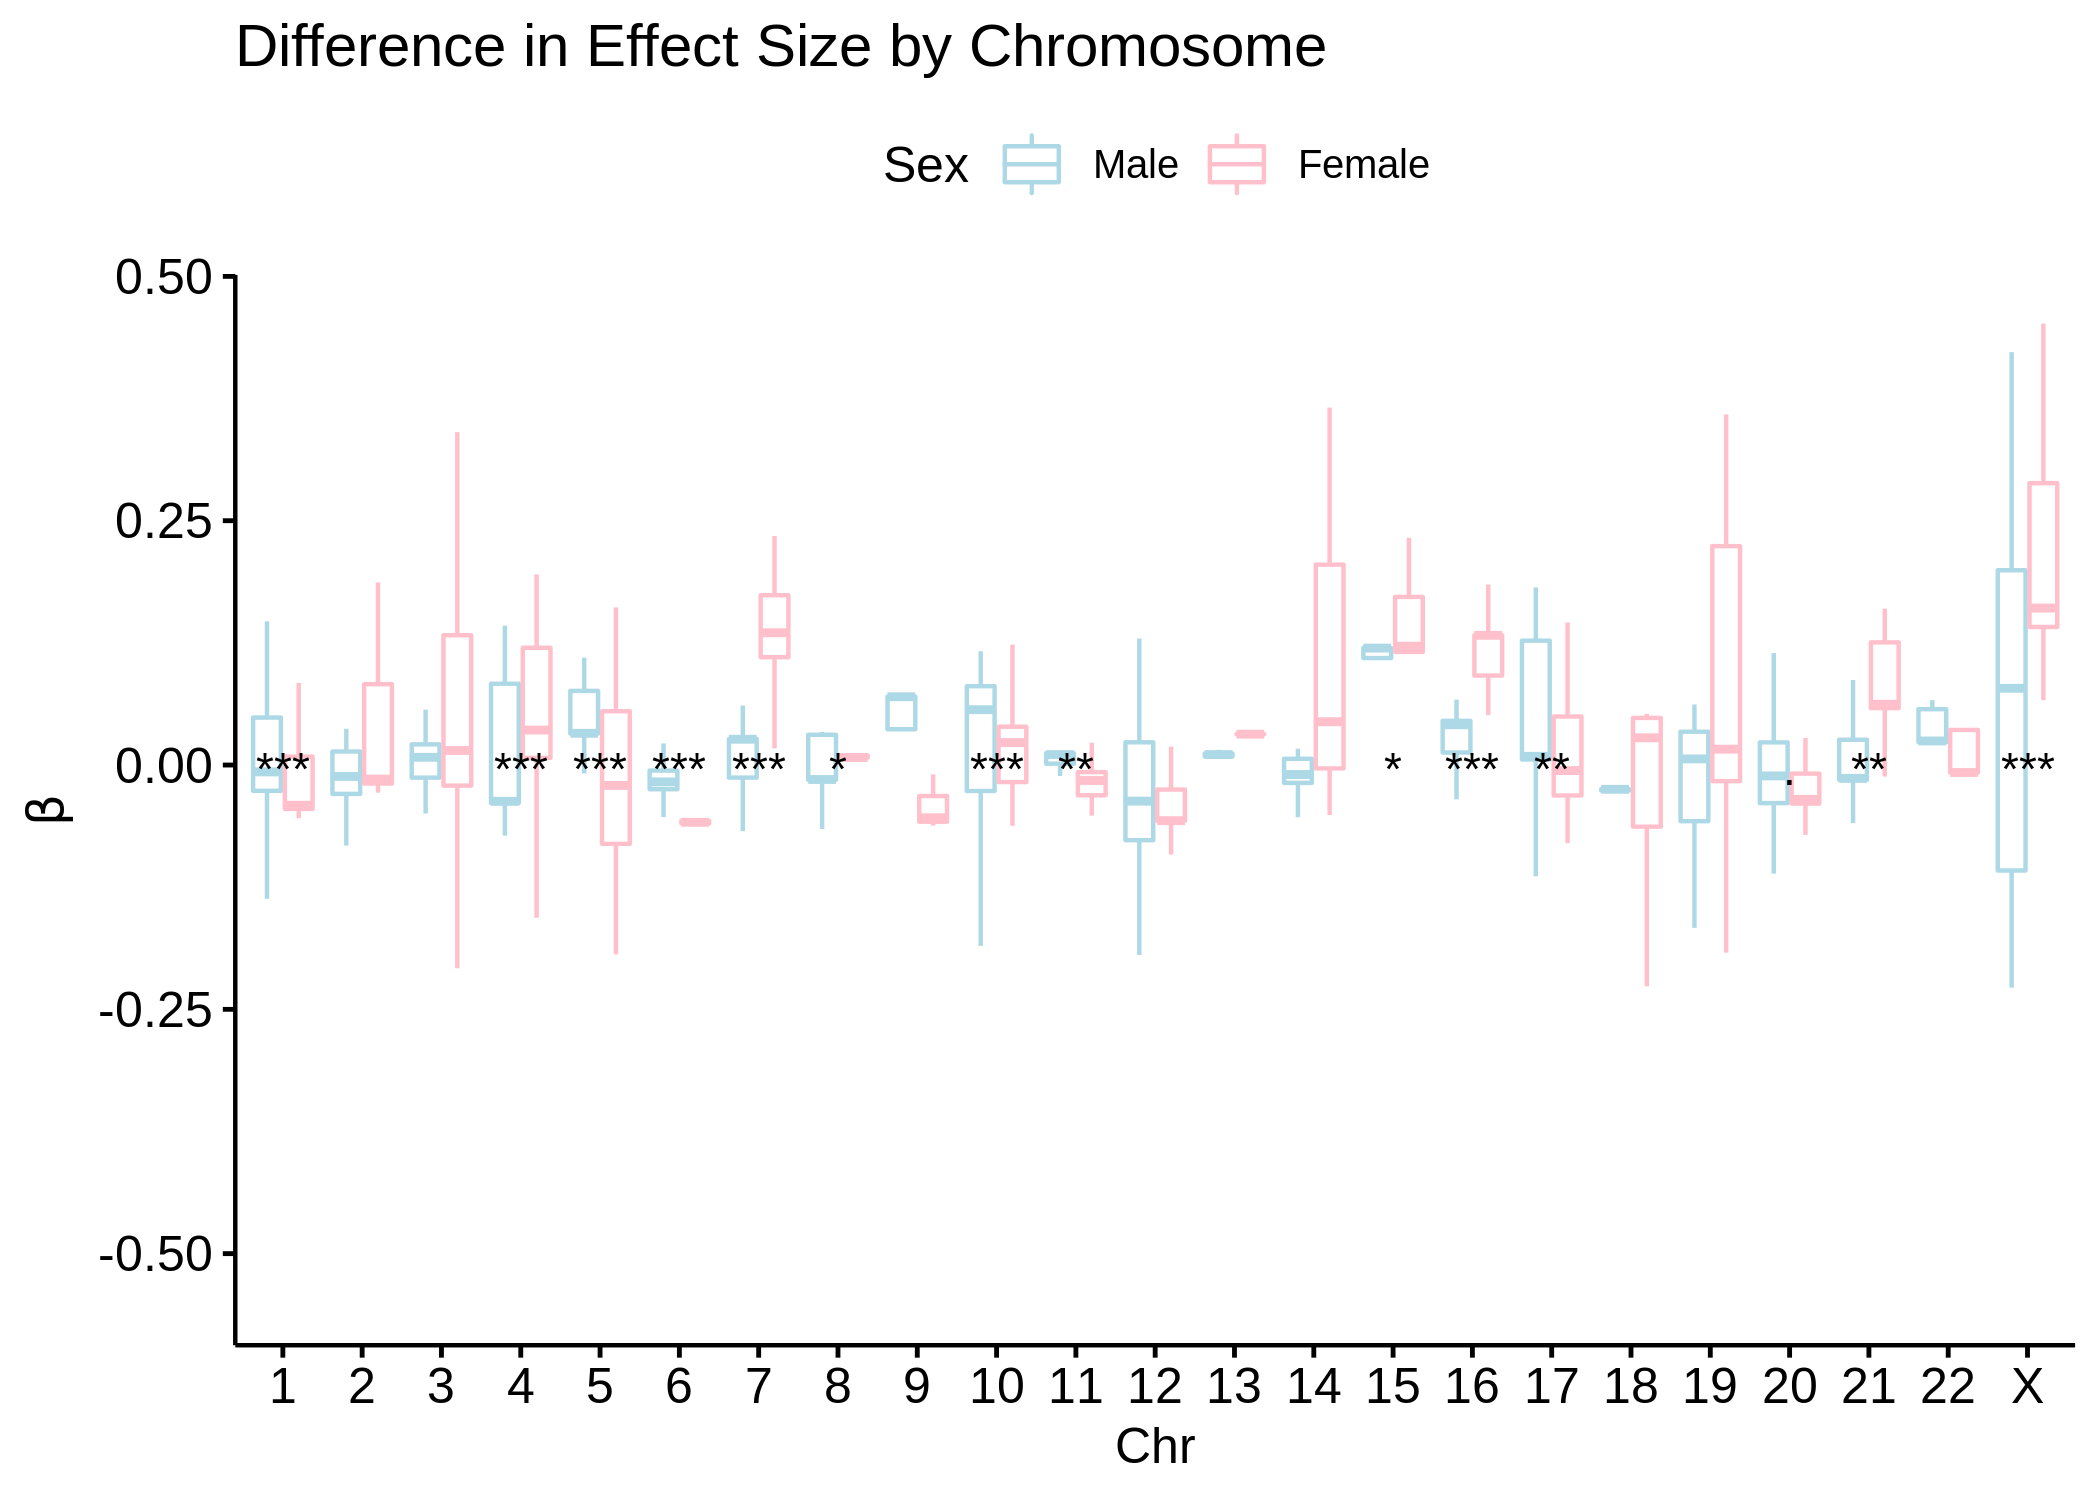

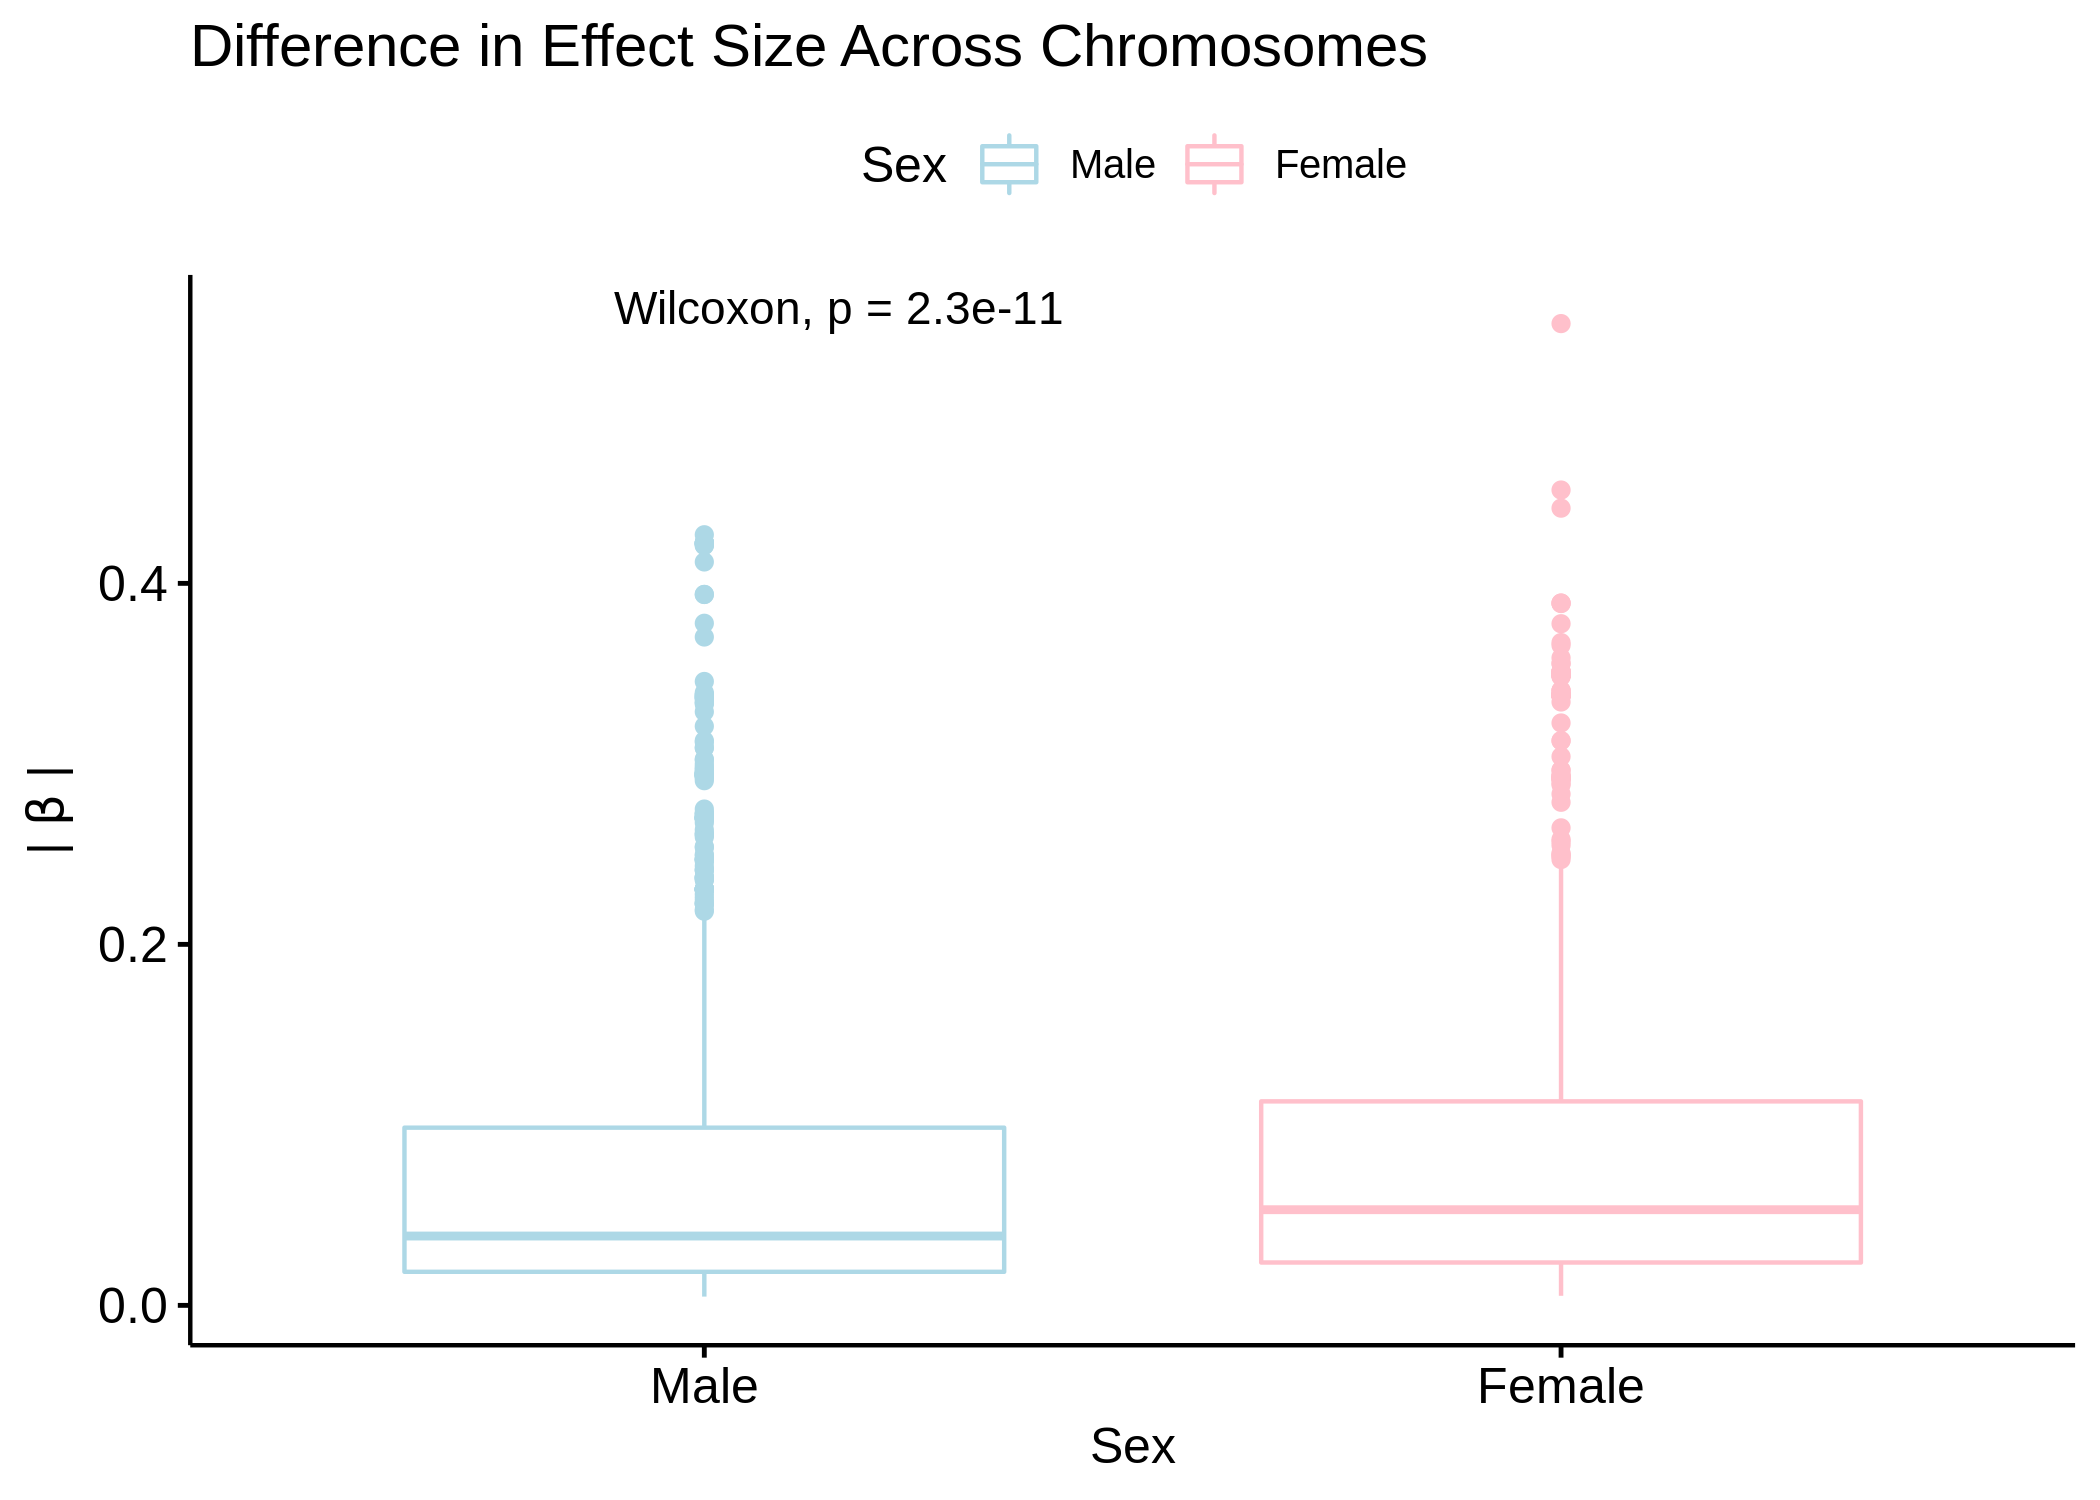

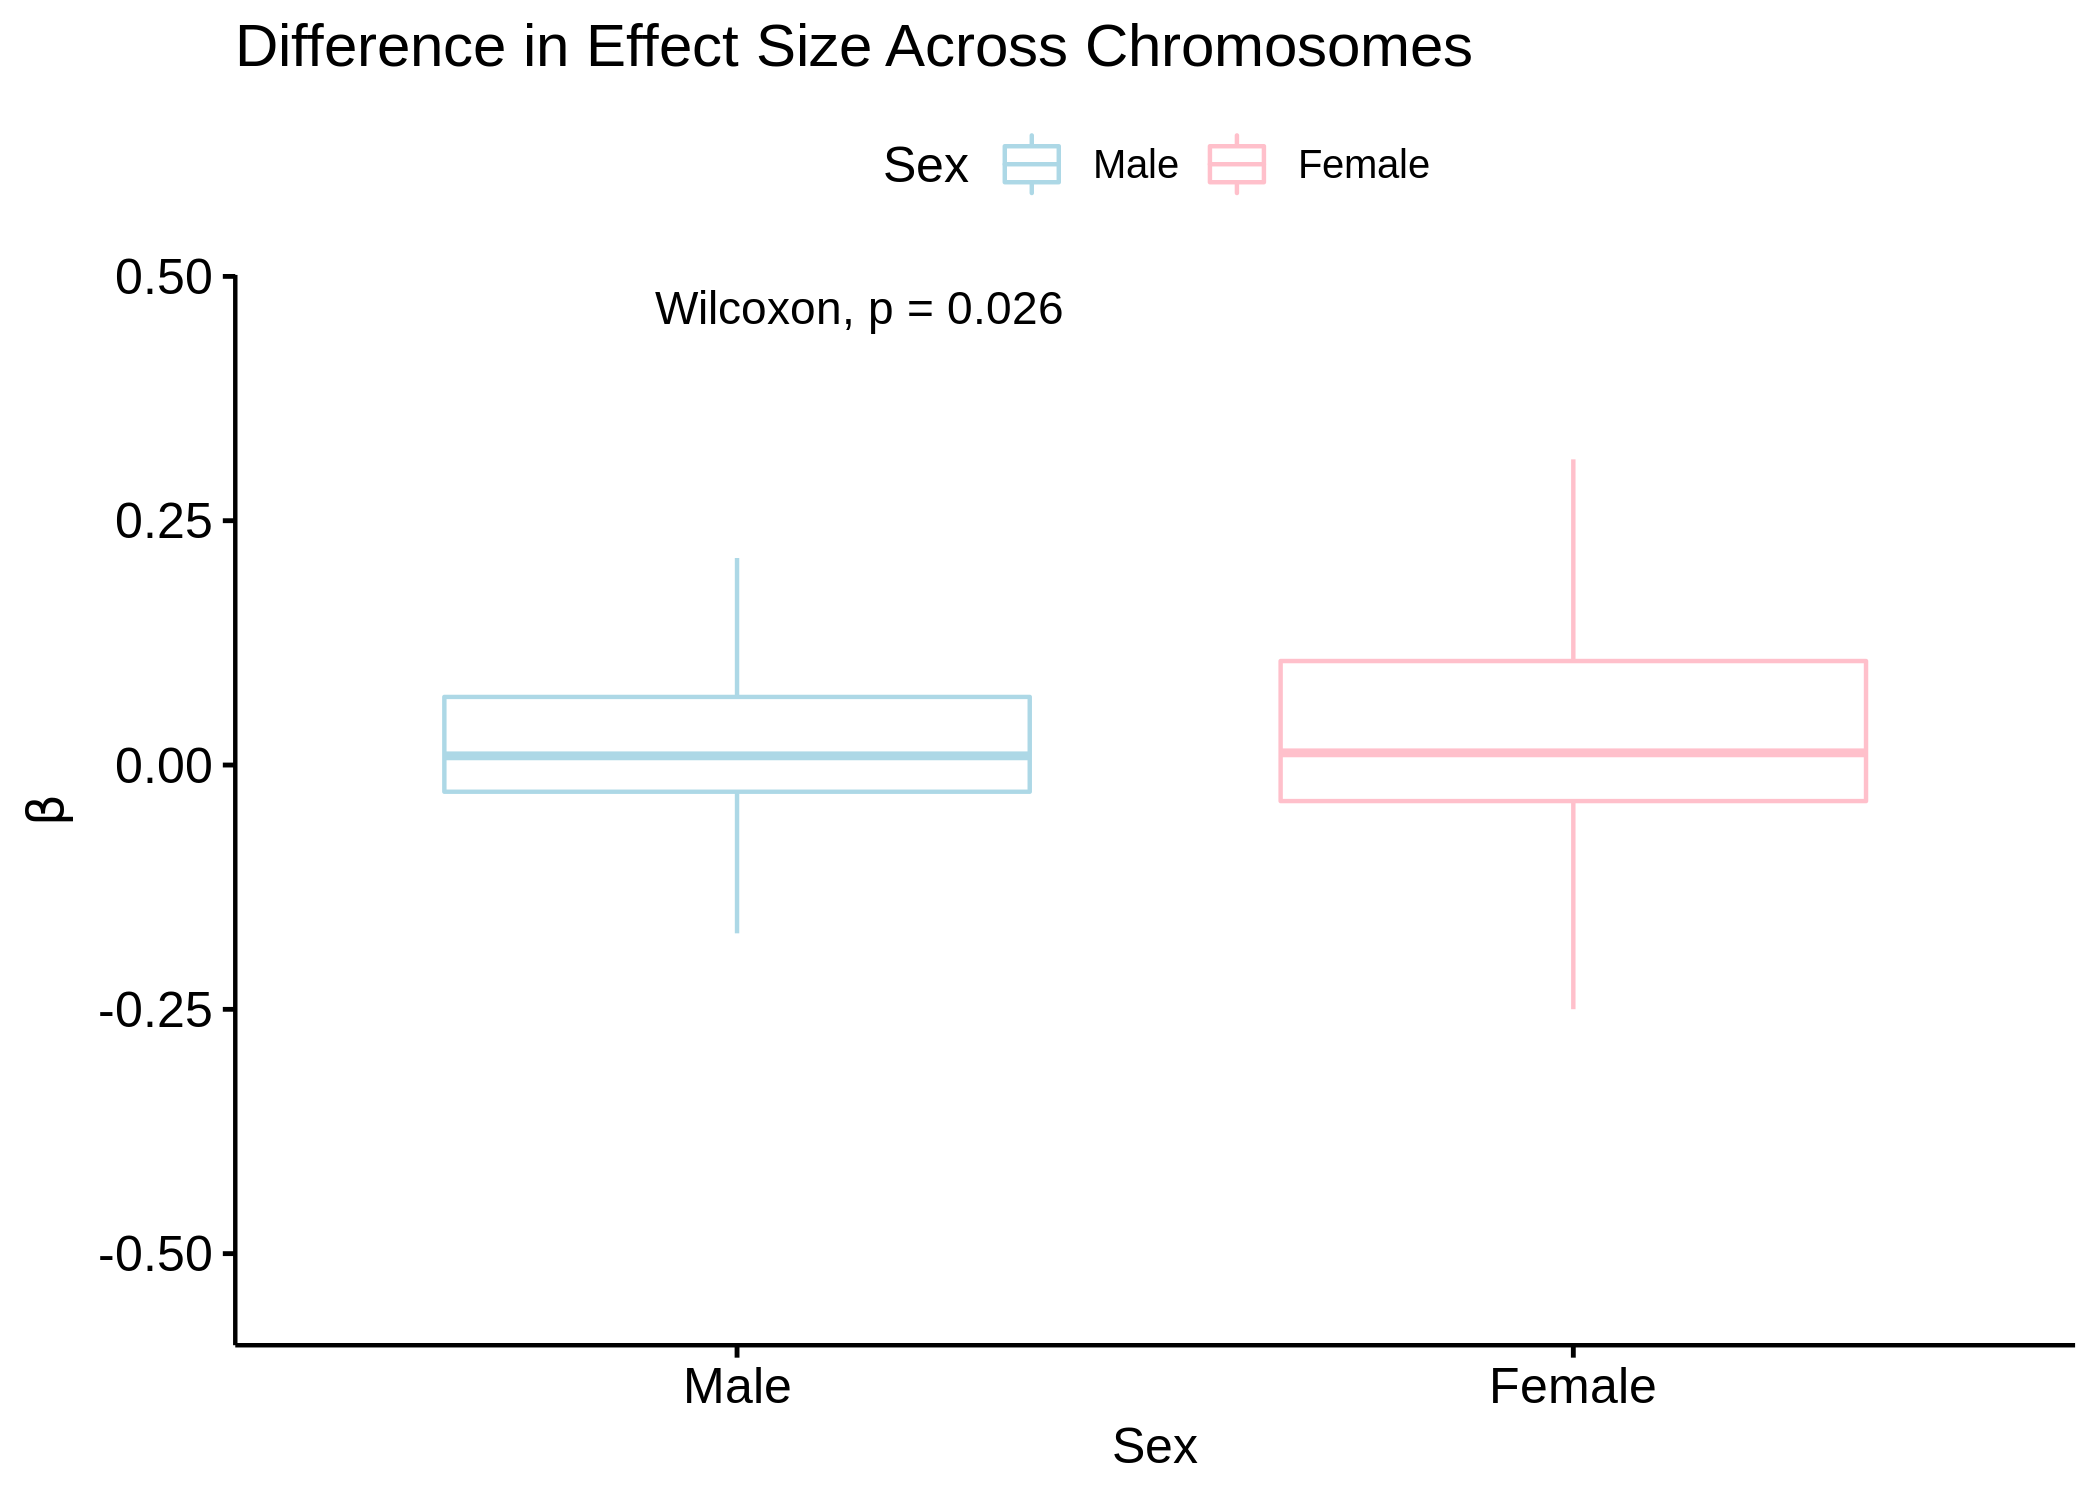

In [9]:
library(ggpubr)
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}
ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Chr",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size by Chromosome")
ggboxplot(
    sex_effect_dt,
    x="Chr",
    y='b',
    color="Sex",
    palette=c("light blue", "pink"),
    outlier.shape=NA
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote(beta), title="Difference in Effect Size by Chromosome")


ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means()+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size Across Chromosomes")
ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=b)],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("light blue", "pink"),
    outlier.shape=NA
) +
    stat_compare_means()+
    labs(y=bquote(beta), title="Difference in Effect Size Across Chromosomes")

In [10]:
compare_means(b~Sex,sex_effect_dt, group.by = "Chr")
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b=abs(b))], group.by = "Chr")
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b)])
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b=abs(b))])

Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,6.479045e-13,1.4e-11,6.5e-13,****,Wilcoxon
2,b,Male,Female,1.119149e-01,6.9e-01,0.11191,ns,Wilcoxon
3,b,Male,Female,1.179544e-01,6.9e-01,0.11795,ns,Wilcoxon
4,b,Male,Female,6.618751e-06,1.2e-04,6.6e-06,****,Wilcoxon
5,b,Male,Female,4.449510e-05,7.1e-04,4.4e-05,****,Wilcoxon
6,b,Male,Female,6.057615e-16,1.3e-14,6.1e-16,****,Wilcoxon
7,b,Male,Female,4.207711e-41,9.7e-40,< 2e-16,****,Wilcoxon
8,b,Male,Female,3.167652e-03,3.8e-02,0.00317,**,Wilcoxon
9,b,Male,Female,3.724559e-01,1.0e+00,0.37246,ns,Wilcoxon


Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,2.575834e-05,4.4e-04,2.6e-05,****,Wilcoxon
2,b,Male,Female,3.524194e-02,3.9e-01,0.03524,*,Wilcoxon
3,b,Male,Female,2.014933e-08,3.8e-07,2.0e-08,****,Wilcoxon
4,b,Male,Female,4.921341e-01,9.8e-01,0.49213,ns,Wilcoxon
5,b,Male,Female,2.367376e-01,7.1e-01,0.23674,ns,Wilcoxon
6,b,Male,Female,2.996243e-19,6.3e-18,< 2e-16,****,Wilcoxon
7,b,Male,Female,1.256535e-45,2.9e-44,< 2e-16,****,Wilcoxon
8,b,Male,Female,3.157975e-07,5.7e-06,3.2e-07,****,Wilcoxon
9,b,Male,Female,4.974599e-02,4.7e-01,0.04975,*,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,0.02605251,0.026,0.026,*,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,2.303366e-11,2.3e-11,2.3e-11,****,Wilcoxon


In [11]:
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Chr","Sex")]
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Sex")]

Chr,Sex,mean_beta,mean_abs_beta
<fct>,<fct>,<dbl>,<dbl>
1,Male,0.023547942,0.05581791
2,Male,-0.006875808,0.04218298
3,Male,0.016887115,0.03558615
4,Male,0.014247370,0.05694747
5,Male,0.061357723,0.06210697
6,Male,-0.007567177,0.03156349
7,Male,0.012789878,0.03330692
8,Male,0.021262047,0.05901179
9,Male,0.036752875,0.06829347


Sex,mean_beta,mean_abs_beta
<fct>,<dbl>,<dbl>
Male,0.02149235,0.06809077
Female,0.03464848,0.07904171


### Sex stratified

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.



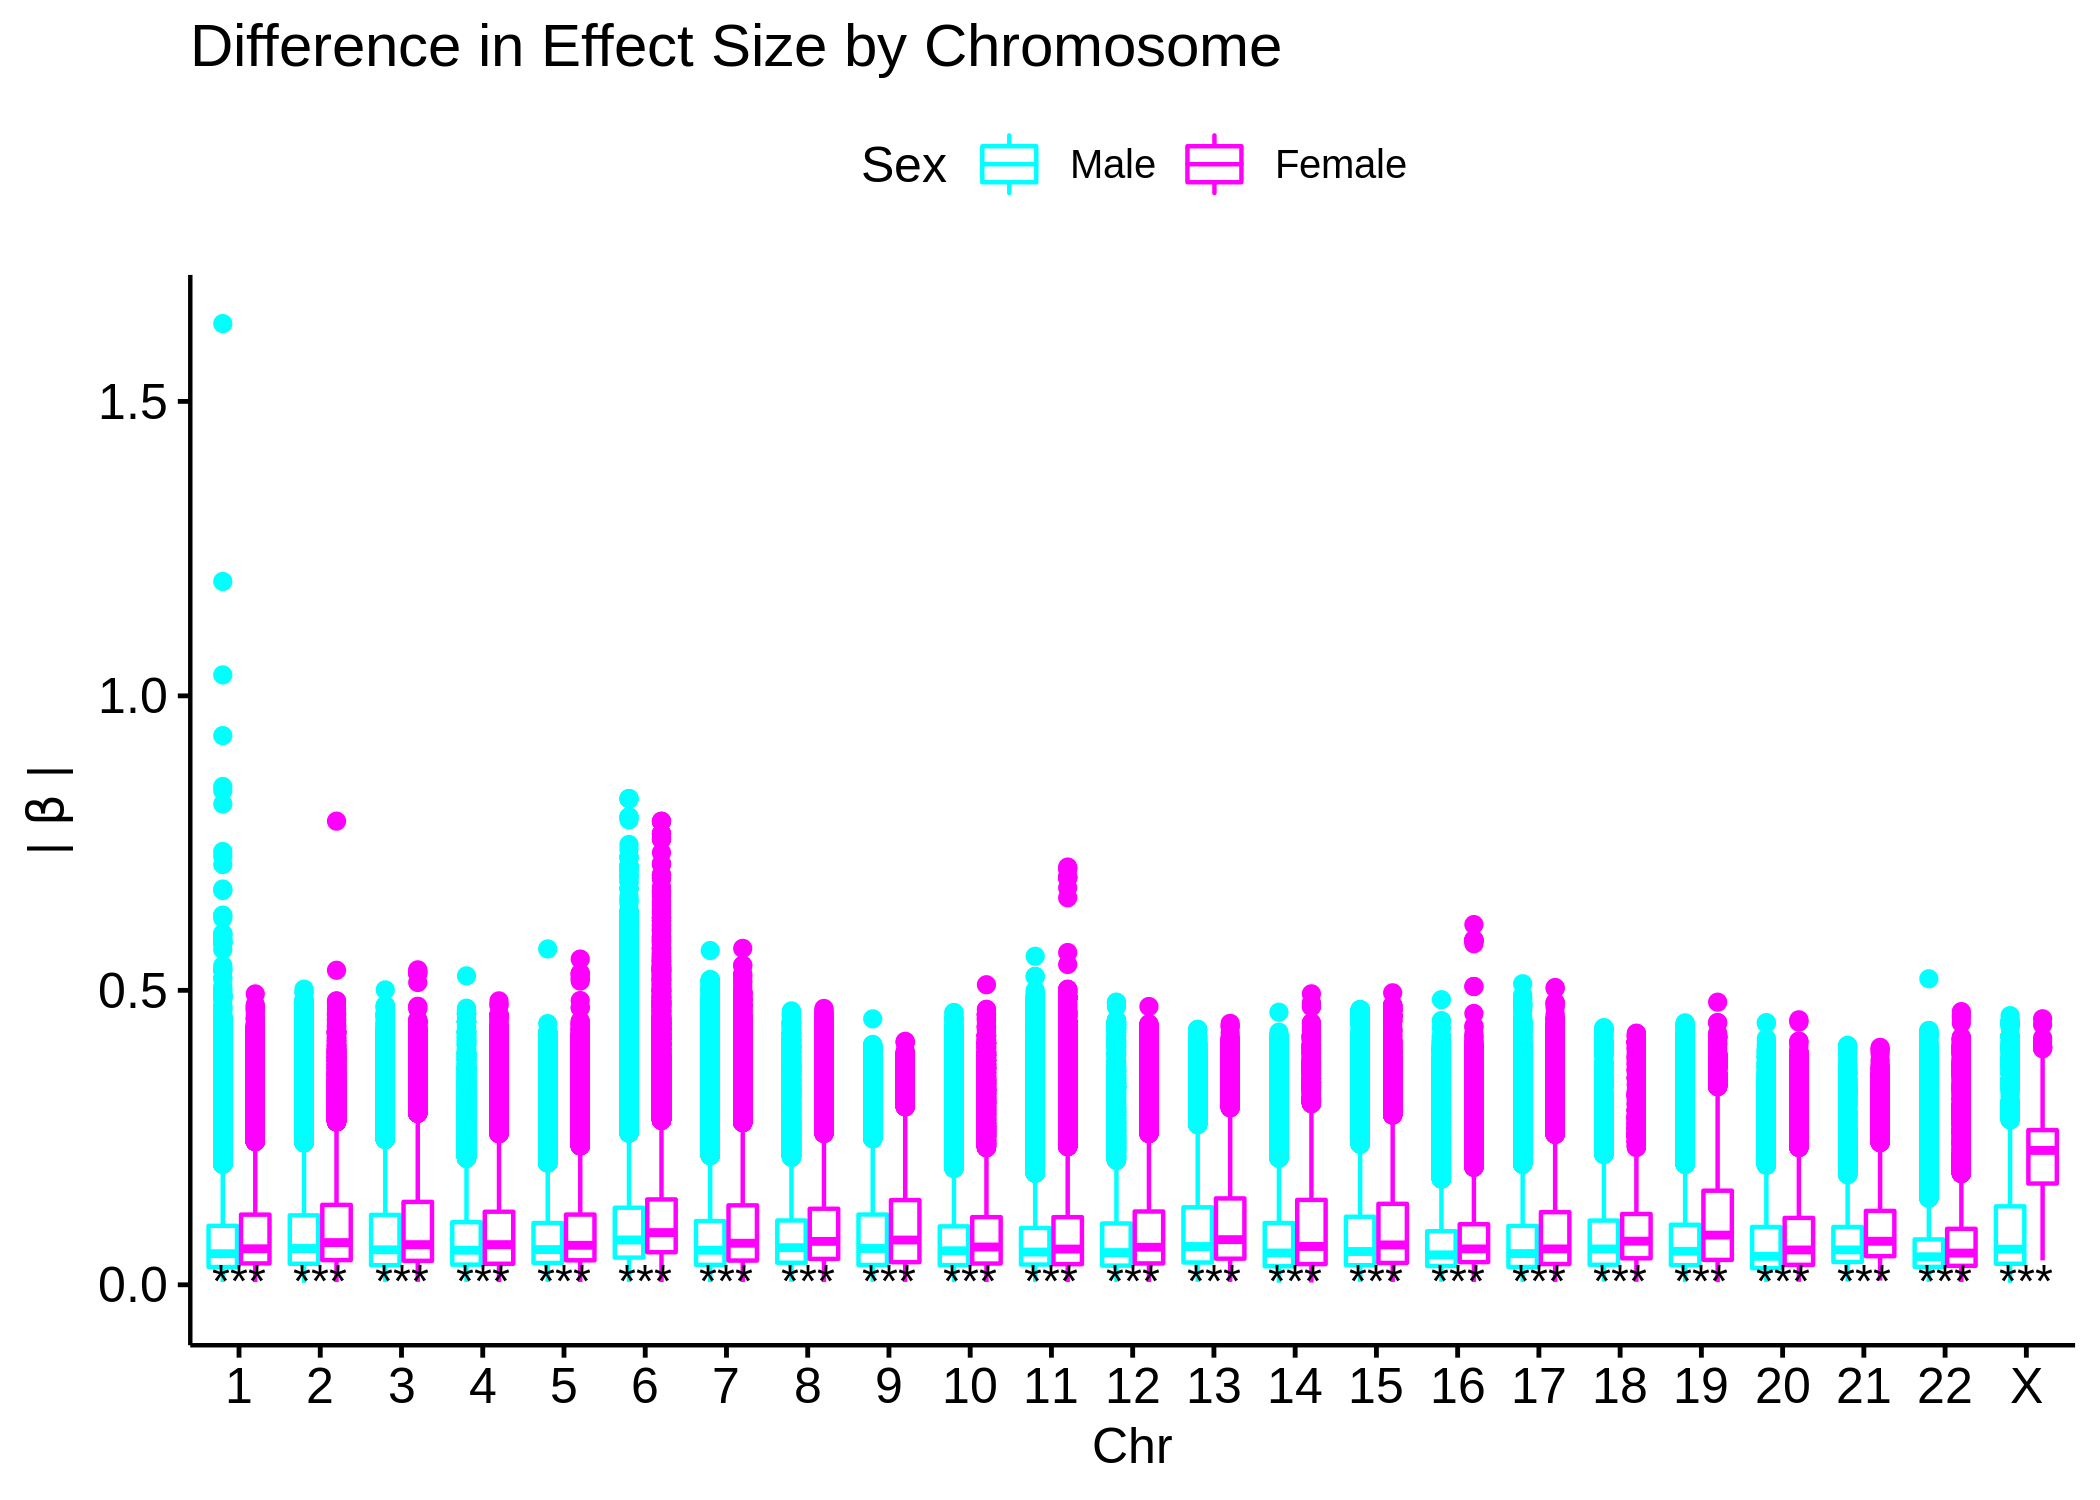

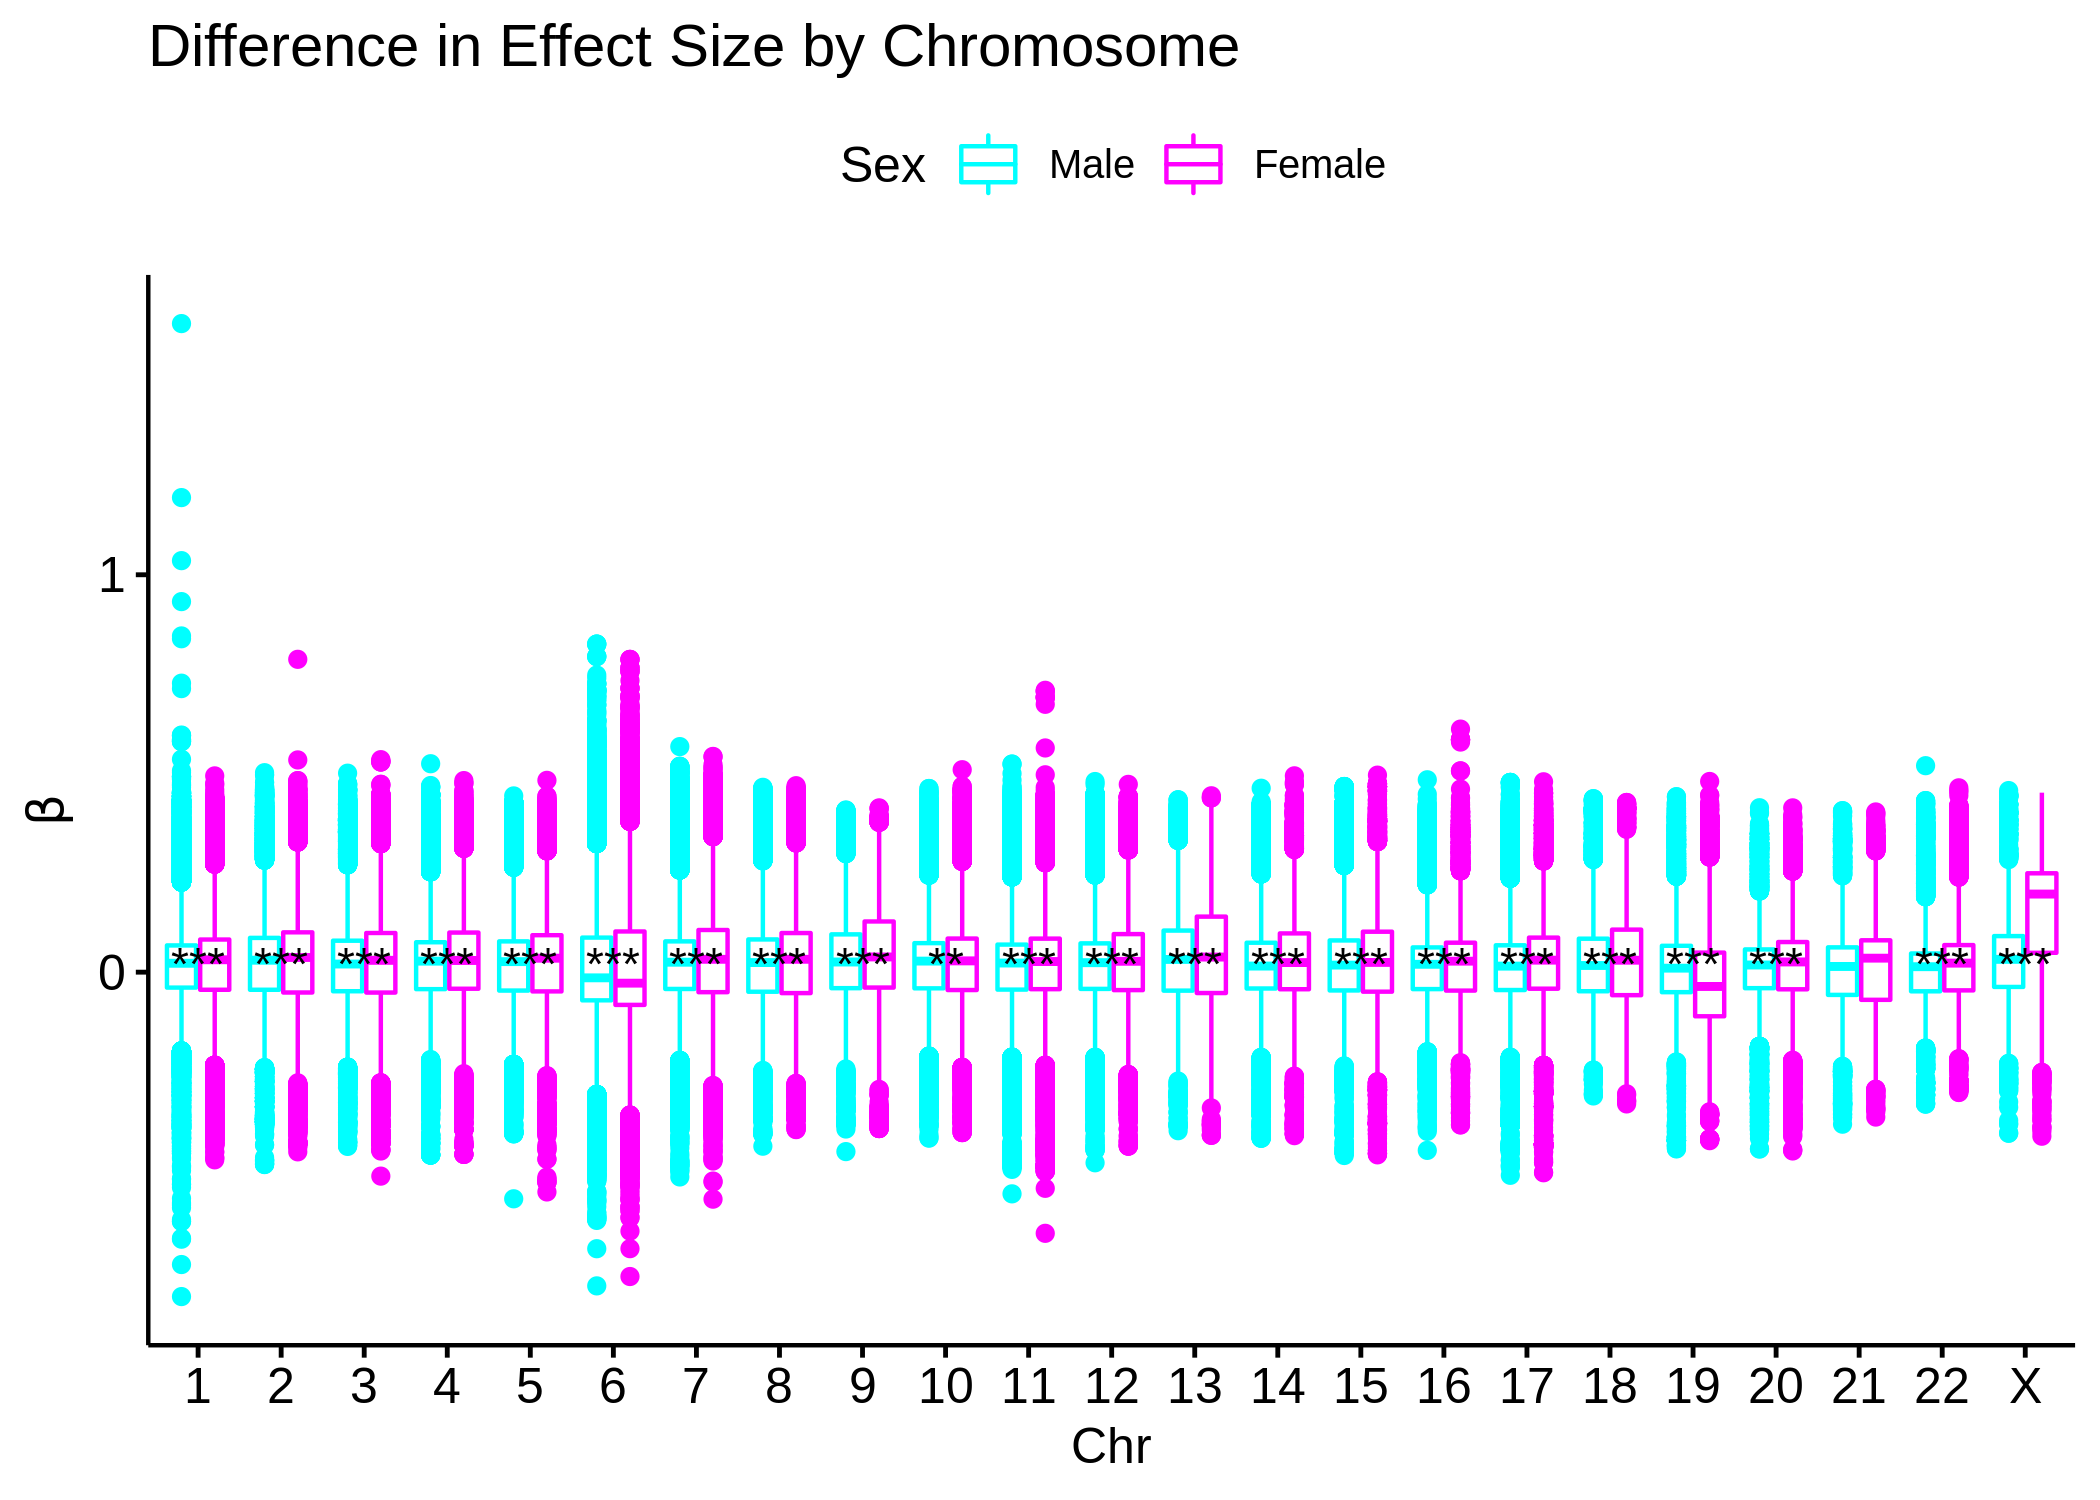

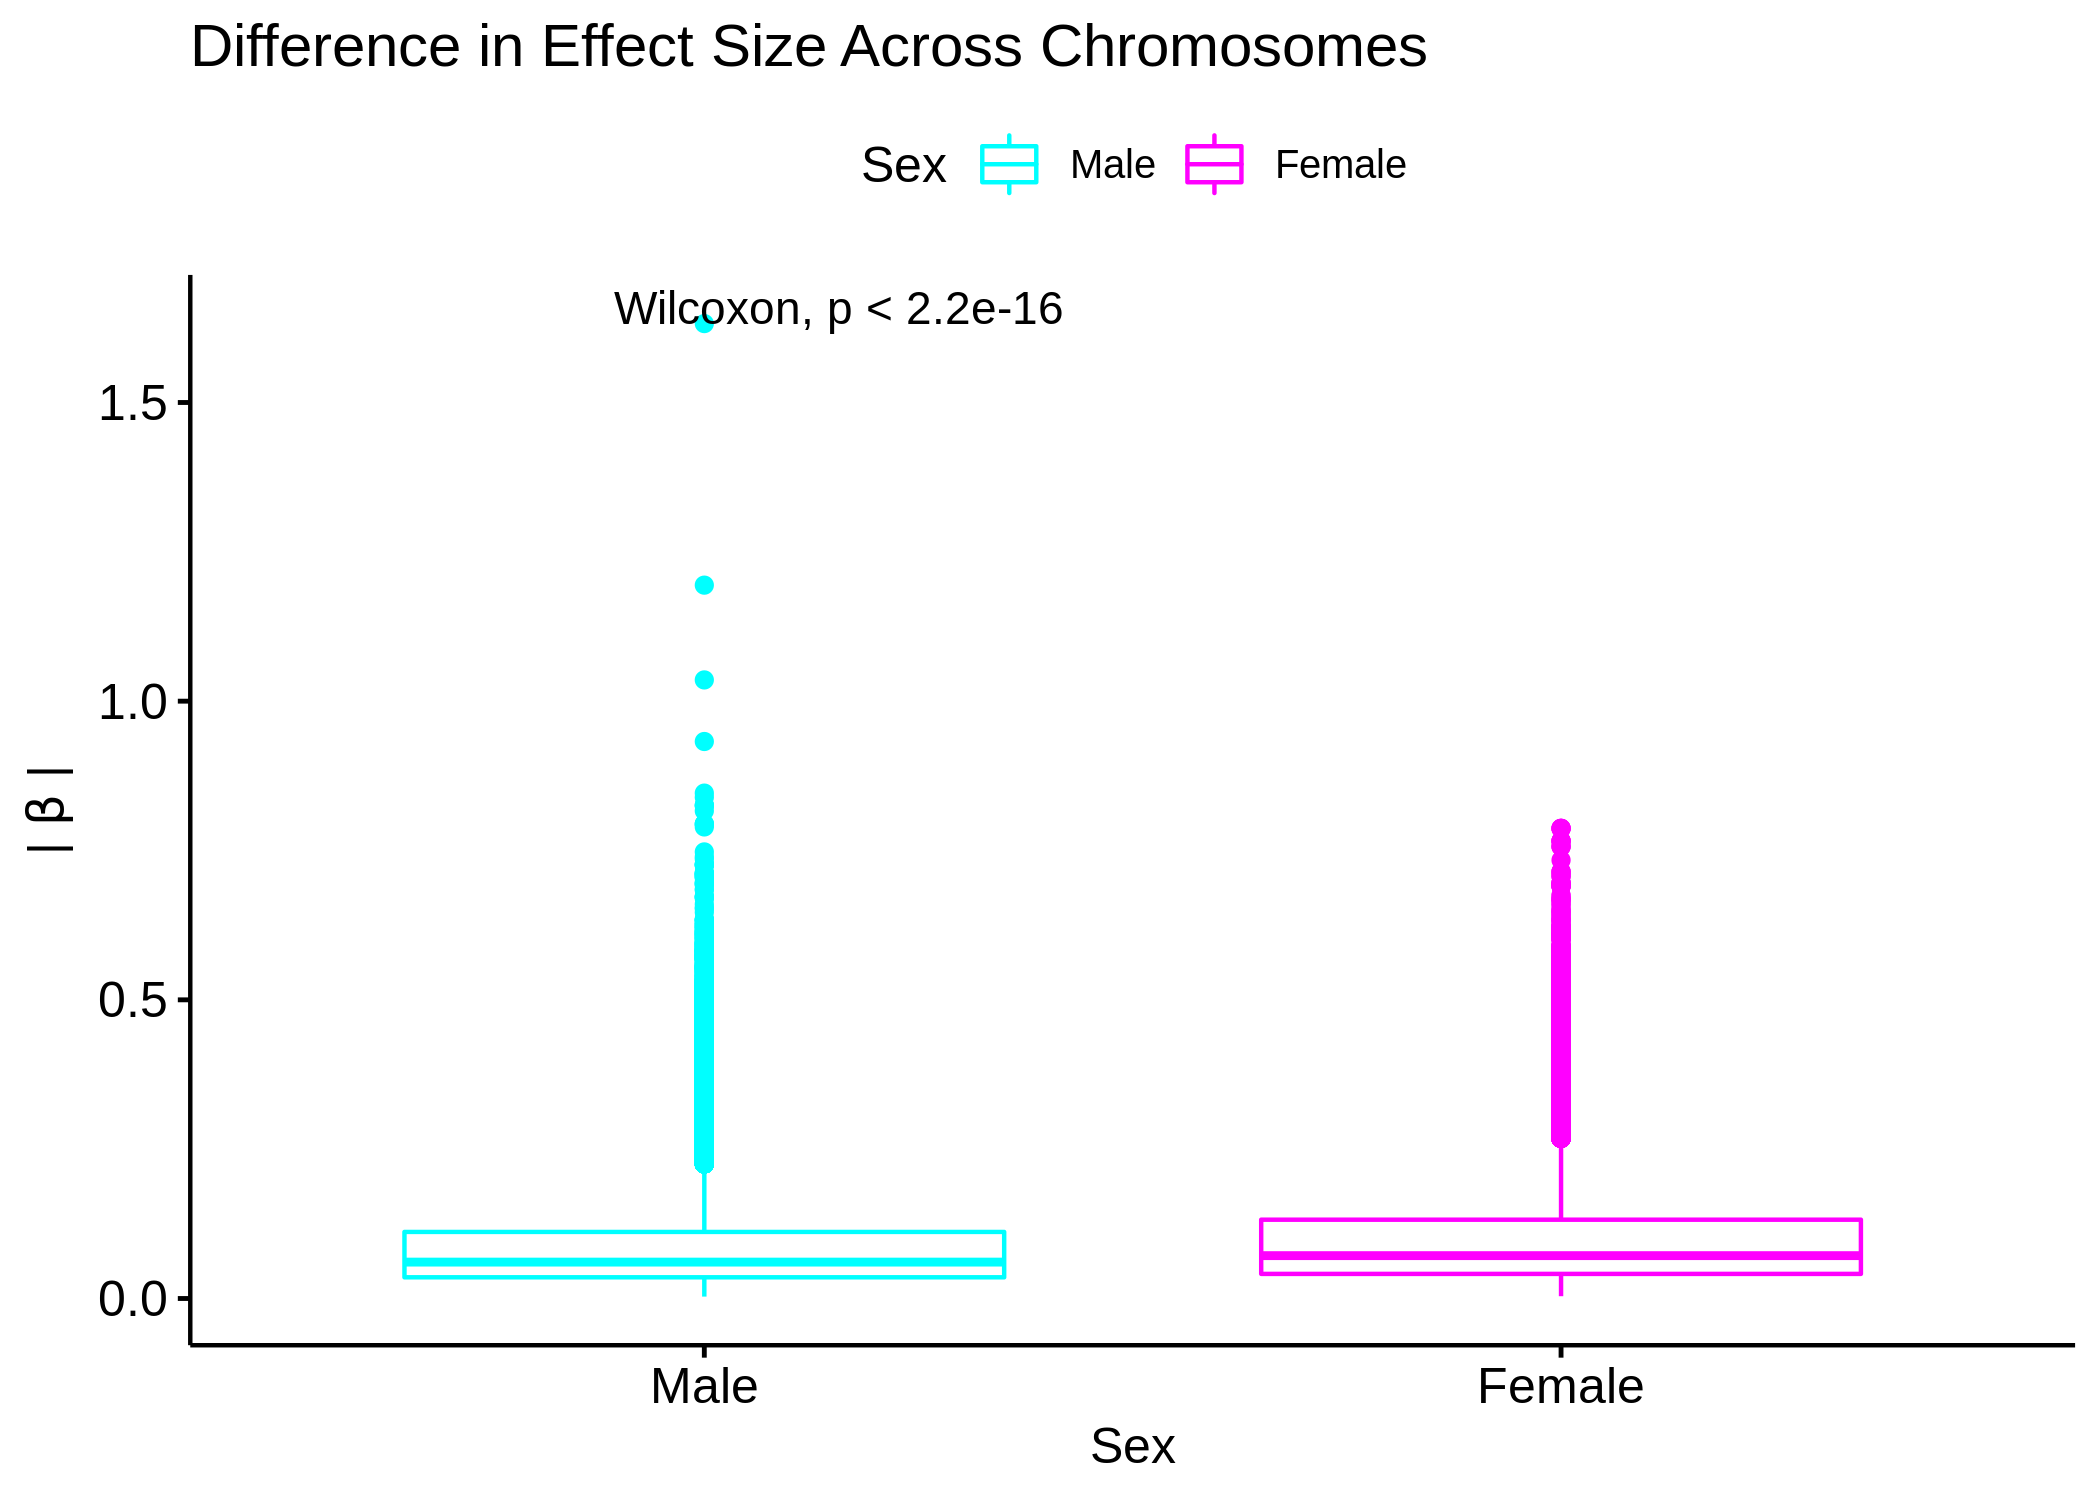

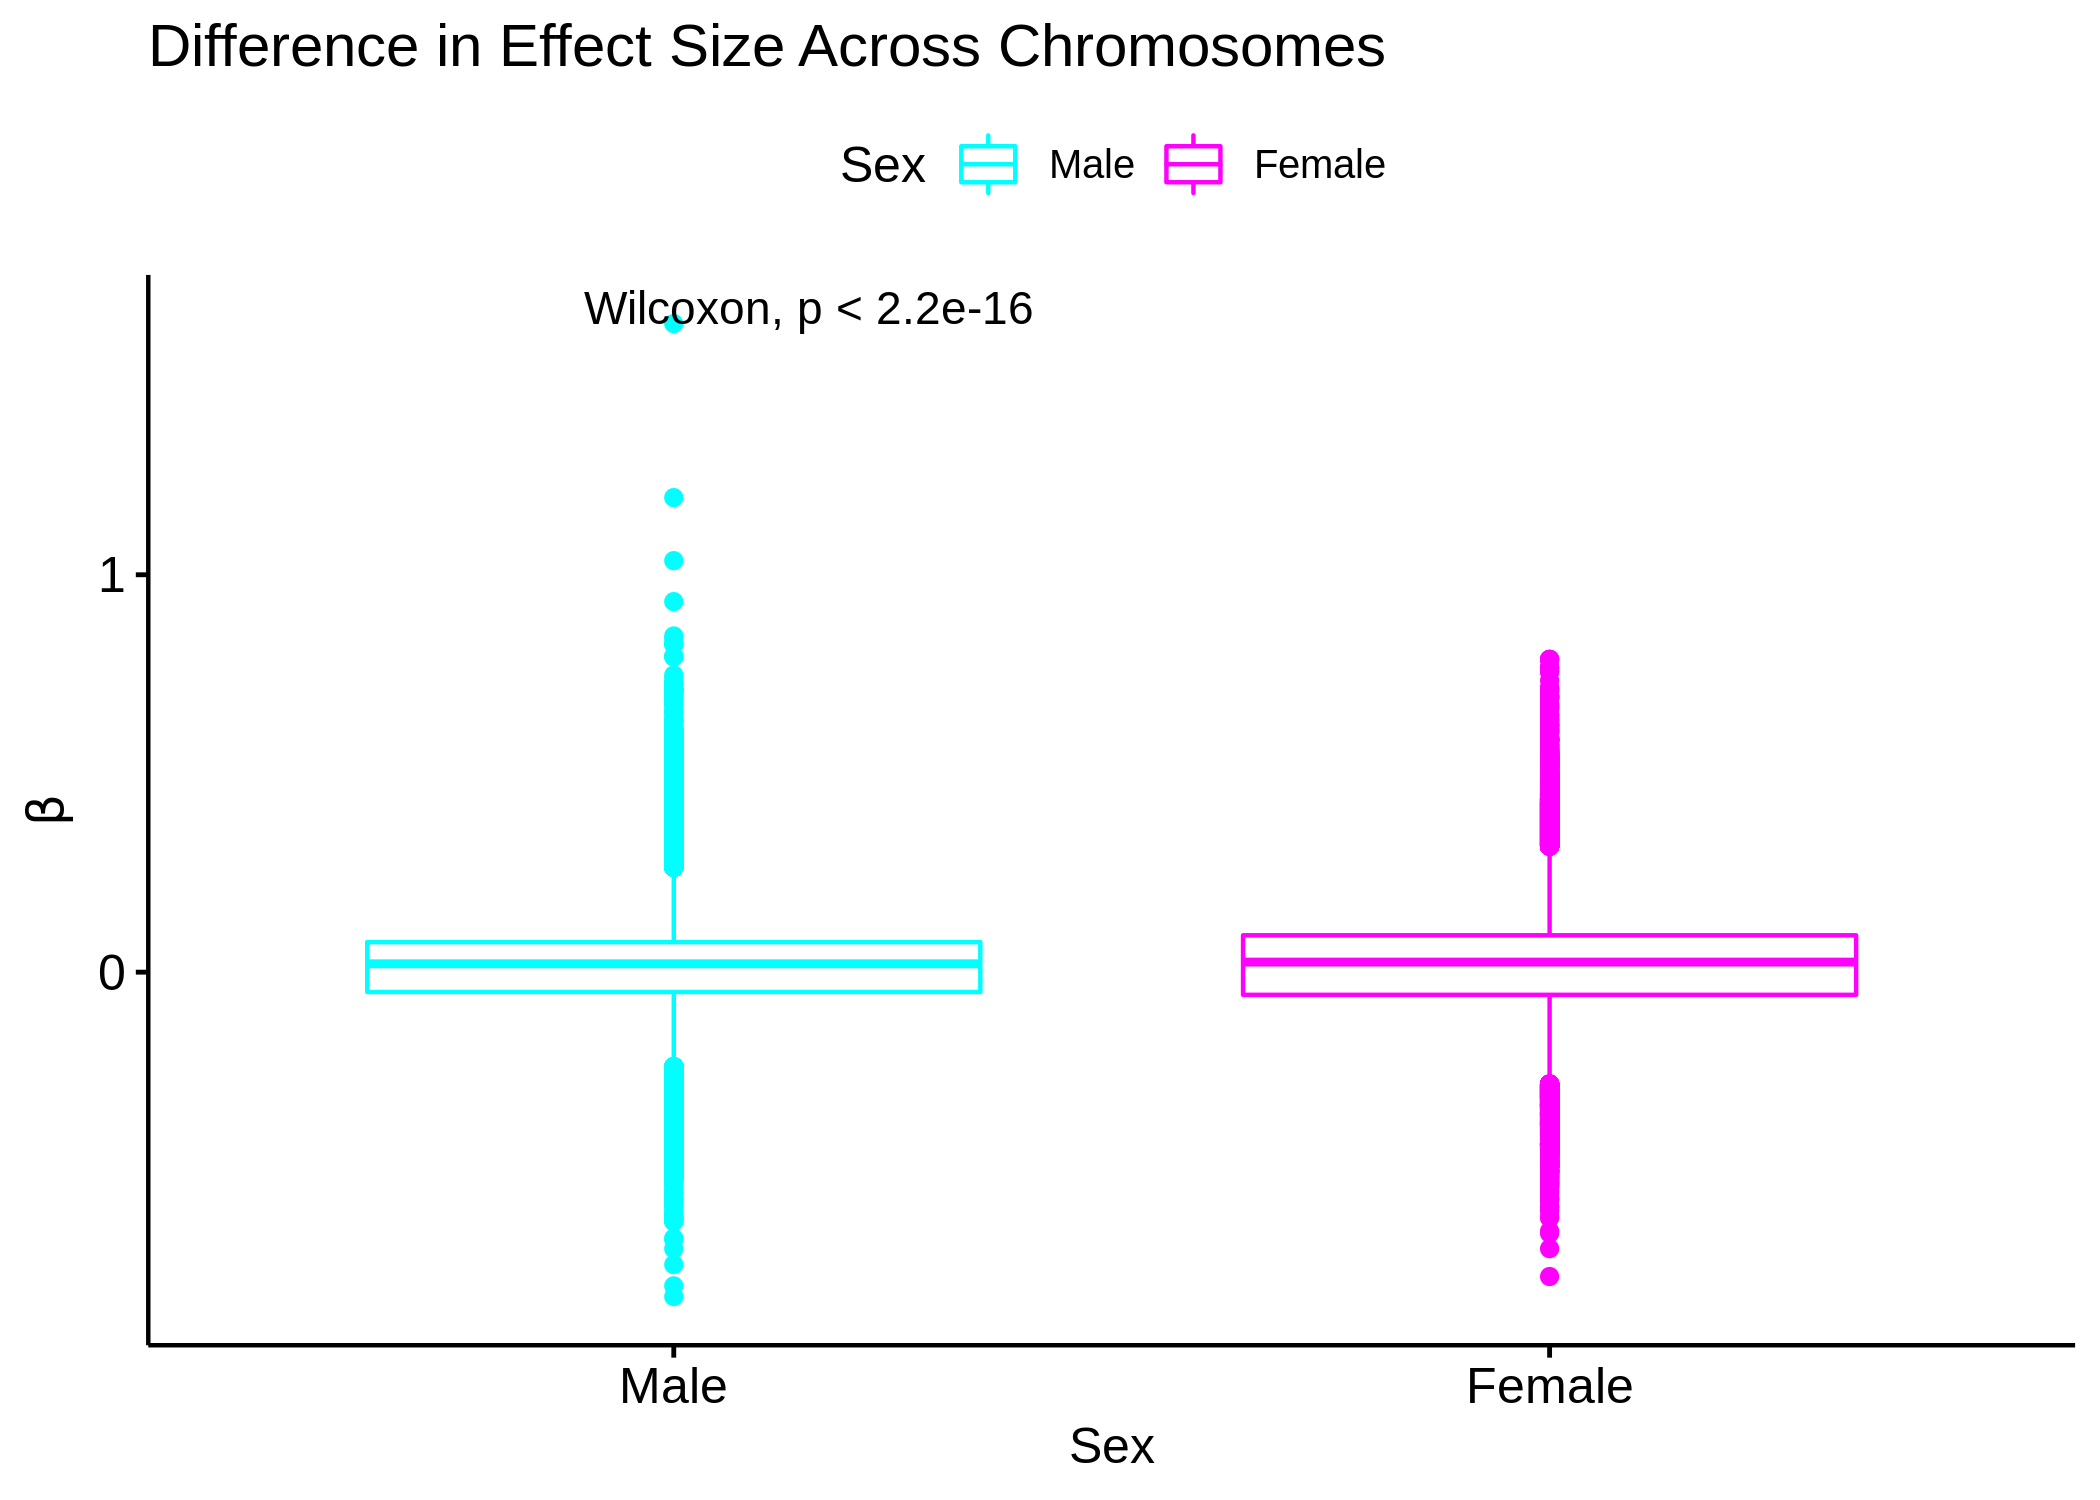

In [12]:
library(ggpubr)
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}
ggboxplot(
    sex_strat_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Chr",
    y='b',
    color="Sex",
    palette=c("cyan", "magenta")
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size by Chromosome")
ggboxplot(
    sex_strat_effect_dt,
    x="Chr",
    y='b',
    color="Sex",
    palette=c("cyan", "magenta")
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote(beta), title="Difference in Effect Size by Chromosome")


ggboxplot(
    sex_strat_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("cyan", "magenta")
) +
    stat_compare_means()+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size Across Chromosomes")
ggboxplot(
    sex_strat_effect_dt[,.(Chr,Sex,b=b)],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("cyan", "magenta")
) +
    stat_compare_means()+
    labs(y=bquote(beta), title="Difference in Effect Size Across Chromosomes")

In [13]:
compare_means(b~Sex,sex_strat_effect_dt, group.by = "Chr")
compare_means(b~Sex,sex_strat_effect_dt[,.(Chr,Sex,b=abs(b))], group.by = "Chr")
compare_means(b~Sex,sex_strat_effect_dt[,.(Chr,Sex,b)])
compare_means(b~Sex,sex_strat_effect_dt[,.(Chr,Sex,b=abs(b))]) 

Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,1.015363e-28,1.9e-27,< 2e-16,****,Wilcoxon
2,b,Male,Female,3.809685e-12,4.2e-11,3.8e-12,****,Wilcoxon
3,b,Male,Female,7.601067e-23,1.3e-21,< 2e-16,****,Wilcoxon
4,b,Male,Female,6.911313e-19,1.0e-17,< 2e-16,****,Wilcoxon
5,b,Male,Female,2.549056e-16,3.3e-15,2.5e-16,****,Wilcoxon
6,b,Male,Female,8.869276e-26,1.6e-24,< 2e-16,****,Wilcoxon
7,b,Male,Female,7.653119e-19,1.1e-17,< 2e-16,****,Wilcoxon
8,b,Male,Female,1.341514e-07,9.4e-07,1.3e-07,****,Wilcoxon
9,b,Male,Female,5.648161e-14,6.8e-13,5.6e-14,****,Wilcoxon


Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,1.644390e-192,3.3e-191,<2e-16,****,Wilcoxon
2,b,Male,Female,5.279746e-137,9.5e-136,<2e-16,****,Wilcoxon
3,b,Male,Female,2.897240e-87,4.1e-86,<2e-16,****,Wilcoxon
4,b,Male,Female,5.681461e-33,1.7e-32,<2e-16,****,Wilcoxon
5,b,Male,Female,6.821954e-68,8.9e-67,<2e-16,****,Wilcoxon
6,b,Male,Female,0.000000e+00,0.0e+00,<2e-16,****,Wilcoxon
7,b,Male,Female,6.927355e-237,1.5e-235,<2e-16,****,Wilcoxon
8,b,Male,Female,4.520259e-91,6.8e-90,<2e-16,****,Wilcoxon
9,b,Male,Female,7.222859e-34,2.9e-33,<2e-16,****,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,7.219428e-52,7.2e-52,<2e-16,****,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,0,0,<2e-16,****,Wilcoxon


In [14]:
sex_strat_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Chr","Sex")]
sex_strat_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Sex")]

Chr,Sex,mean_beta,mean_abs_beta
<fct>,<fct>,<dbl>,<dbl>
1,Male,0.028515676,0.08619668
2,Male,0.032686976,0.09300364
3,Male,0.029836507,0.09661766
4,Male,0.029080668,0.08659911
5,Male,0.026990584,0.08610254
6,Male,0.015769061,0.10360552
7,Male,0.032030906,0.09103376
8,Male,0.029472633,0.09174352
9,Male,0.038720694,0.09363591


Sex,mean_beta,mean_abs_beta
<fct>,<dbl>,<dbl>
Male,0.02488808,0.09055764
Female,0.02959237,0.10286808


## Counting CpG sites


In [15]:
# Read in and check annotation
array_annot < -fread("/scratch/st-dennisjk-1/wcasazza/450k_annotation.csv")
head(array_annot[chr == "chr1"])

V1,chr,pos,strand,Name,AddressA,AddressB,ProbeSeqA,ProbeSeqB,Type,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
cg00000957,chr1,5937253,+,cg00000957,65648367,36743439,ATACTACTAACCCATACCCAACAAAACAAAAAACCCCAAAACATCAACCA,ATACTACTAACCCATACCCGACAAAACAAAAAACCCCAAAACGTCAACCG,I,⋯,NPHP4,NM_015102,Body,,,NA,1:5859745-5859915,1:5937082-5937731,Unclassified_Cell_type_specific,NA
cg00001349,chr1,166958439,-,cg00001349,11722421,53758324,CAAAACAACACAAACCAAAATCTTCCAATCTCAAACTATTTATTCCCCCA,CAAAACGACACGAACCGAAATCTTCCAATCTCAAACTATTTATTCCCCCG,I,⋯,MAEL,NM_032858,TSS200,,,NA,1:165224845-165225561,,,NA
cg00001583,chr1,200011786,-,cg00001583,55630379,24638471,ACAAAAAATAAAACCTAAACAAAAACCTAATACACCCACAAATTTCACCA,ACAAAAAATAAAACCTAAACGAAAACCTAATACGCCCACGAATTTCGCCG,I,⋯,NR5A2;NR5A2,NM_205860;NM_003822,Body;Body,,,NA,1:198278176-198278678,,,NA
cg00002028,chr1,20960010,-,cg00002028,56738397,74621430,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAACAACA,CCCAAATTTATTATAACCGACGAAAAACGCCGATAATAACGACAACGACG,I,⋯,PINK1;PINK1,NM_032409;NM_032409,1stExon;5'UTR,high-CpG:20832533-20832876,,NA,1:20832399-20833138,1:20959206-20960060,Promoter_Associated,NA
cg00002719,chr1,169396706,+,cg00002719,52741444,27736432,CAATAATCTAAAAATATTACATACACCTACACAAATTTTTATCACTCTCA,CGATAATCTAAAAATATTACATACGCCTACGCAAATTTTTATCGCTCTCG,I,⋯,C1orf114,NM_021179,TSS200,,,TRUE,1:167663071-167663470,,,NA
cg00002837,chr1,44513358,-,cg00002837,45703447,25764310,ATCATAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACA,ATCGTAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACG,I,⋯,,,,,,NA,,1:44512719-44514060,Unclassified,TRUE


In [16]:
annotated_dt_sex <- sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_marginal <- marginal[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_sex$Sex <- "Sex dependent"
annotated_dt_marginal$Sex <- "Cross-sex"
total_annotated <- rbindlist(list(annotated_dt_sex,annotated_dt_marginal,sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]),fill=TRUE)
total_annotated$Sex <- recode(total_annotated$Sex,"Male"= "Male specific", "Female"="Female specific")
total_annotated$Sex <- factor(total_annotated$Sex,levels=c("Male specific","Female specific","Sex dependent", "Cross-sex"))

annotated_dt_sex_strat <- sex_strat_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_sex_strat$Sex <- "Sex dependent"
total_annotated_strat <- rbindlist(list(annotated_dt_sex_strat,annotated_dt_marginal,sex_strat_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]),fill=TRUE)
total_annotated_strat$Sex <- recode(total_annotated_strat$Sex,"Male"= "Male stratified", "Female"="Female stratified")
total_annotated_strat$Sex <- factor(total_annotated_strat$Sex,levels=c("Male stratified","Female stratified","Sex dependent", "Cross-sex"))

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



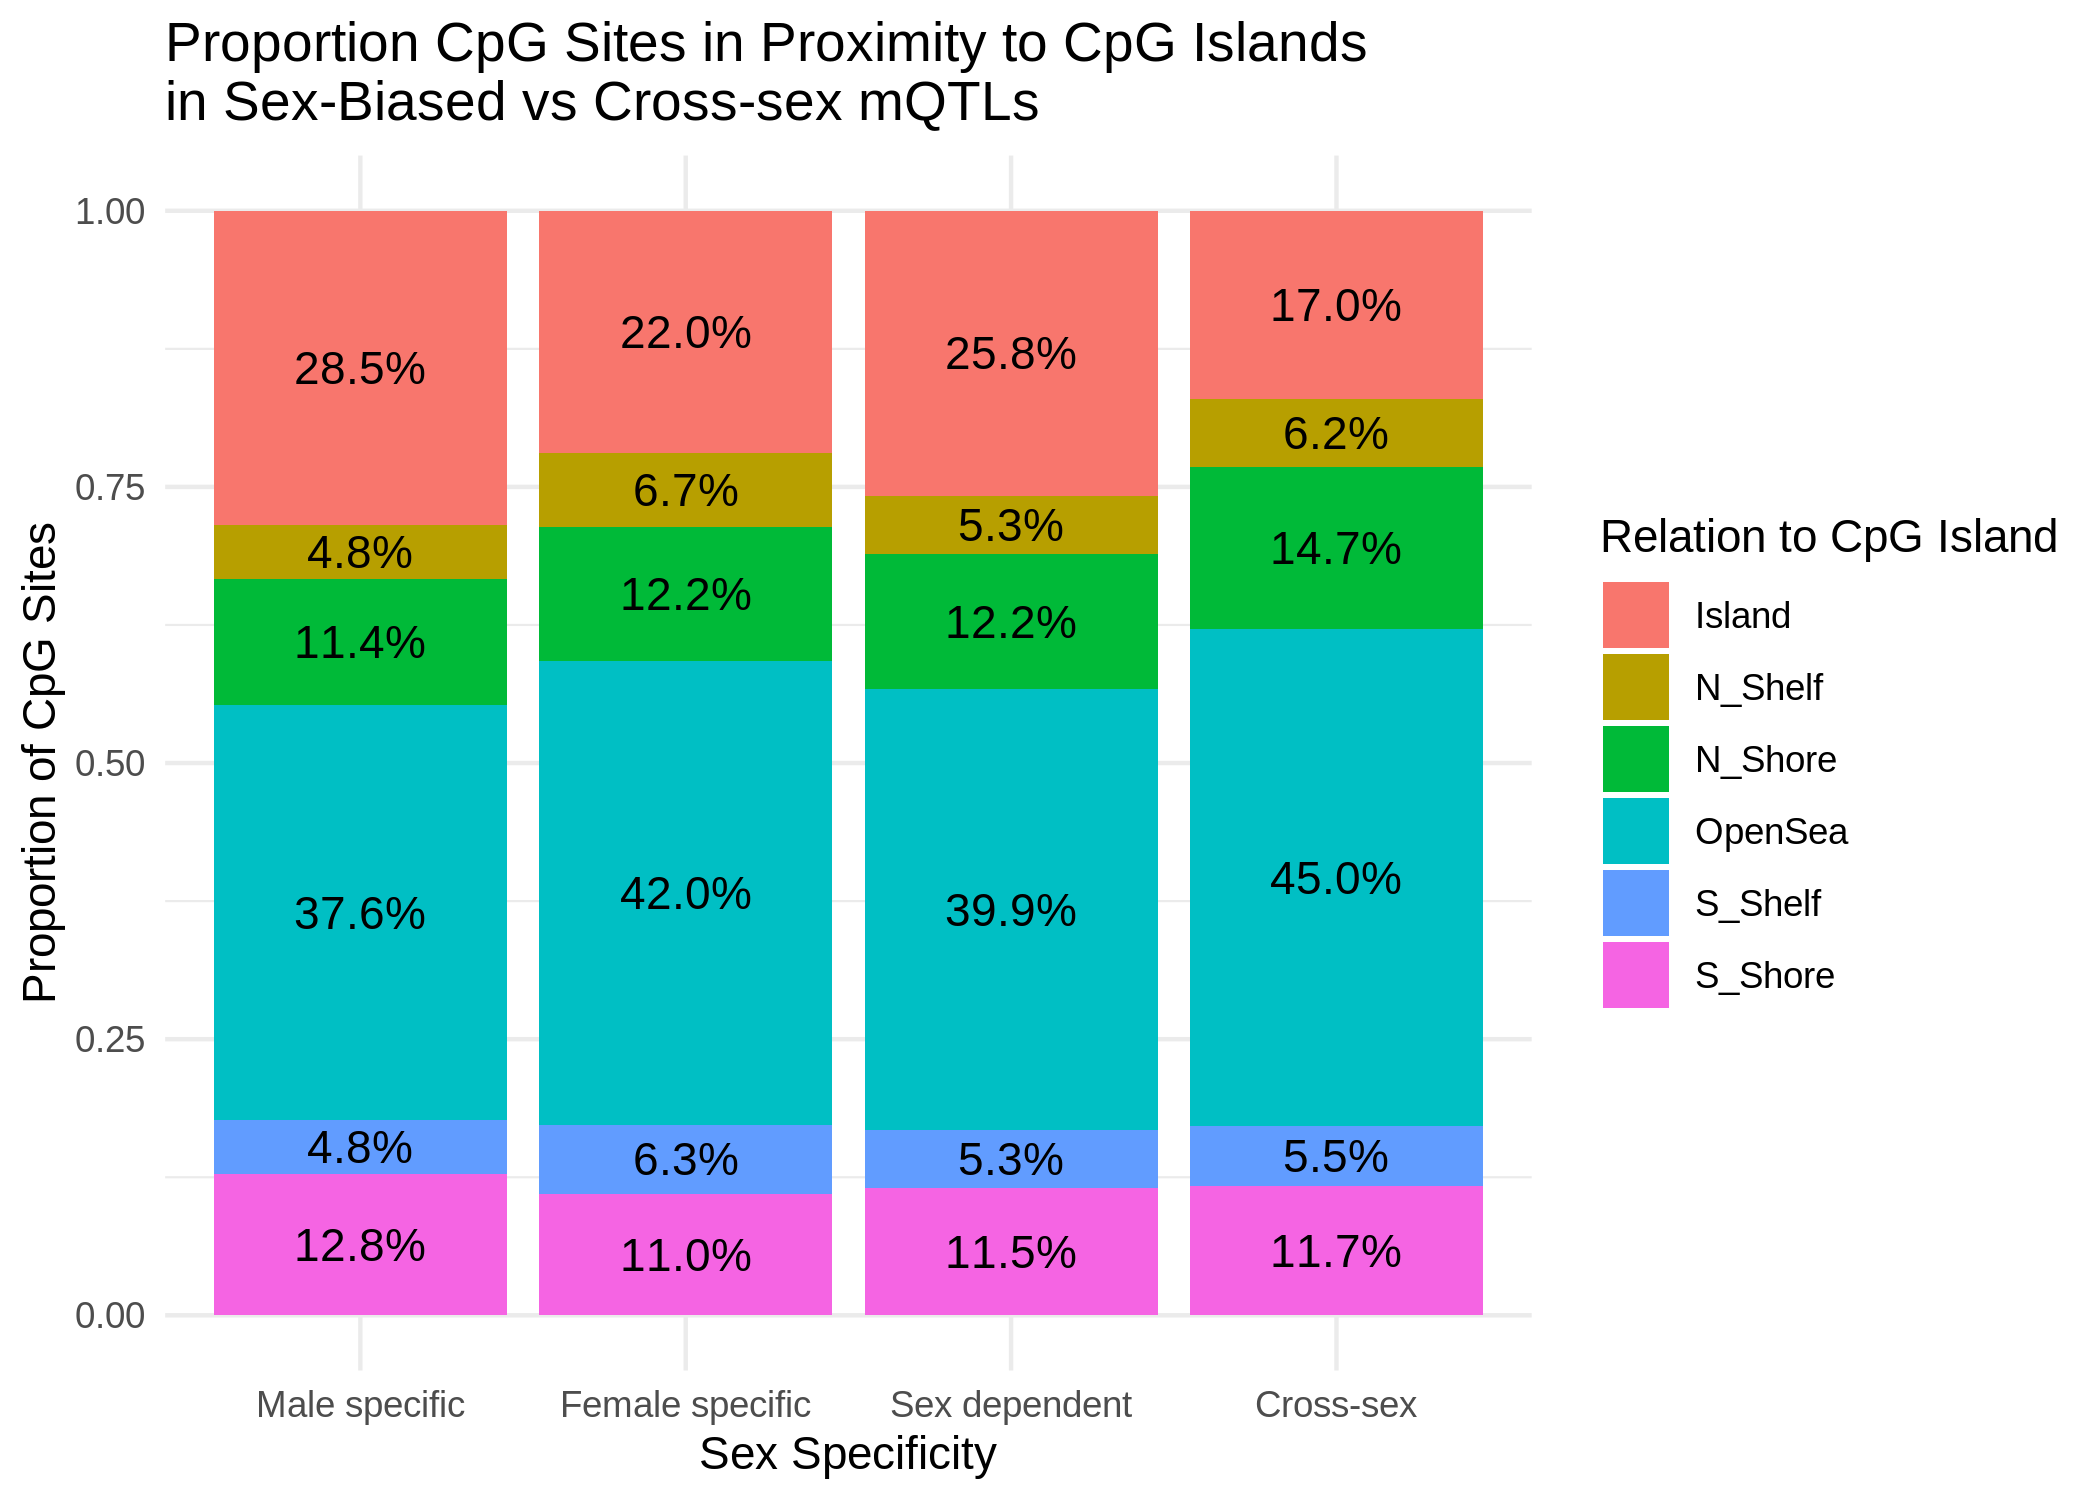

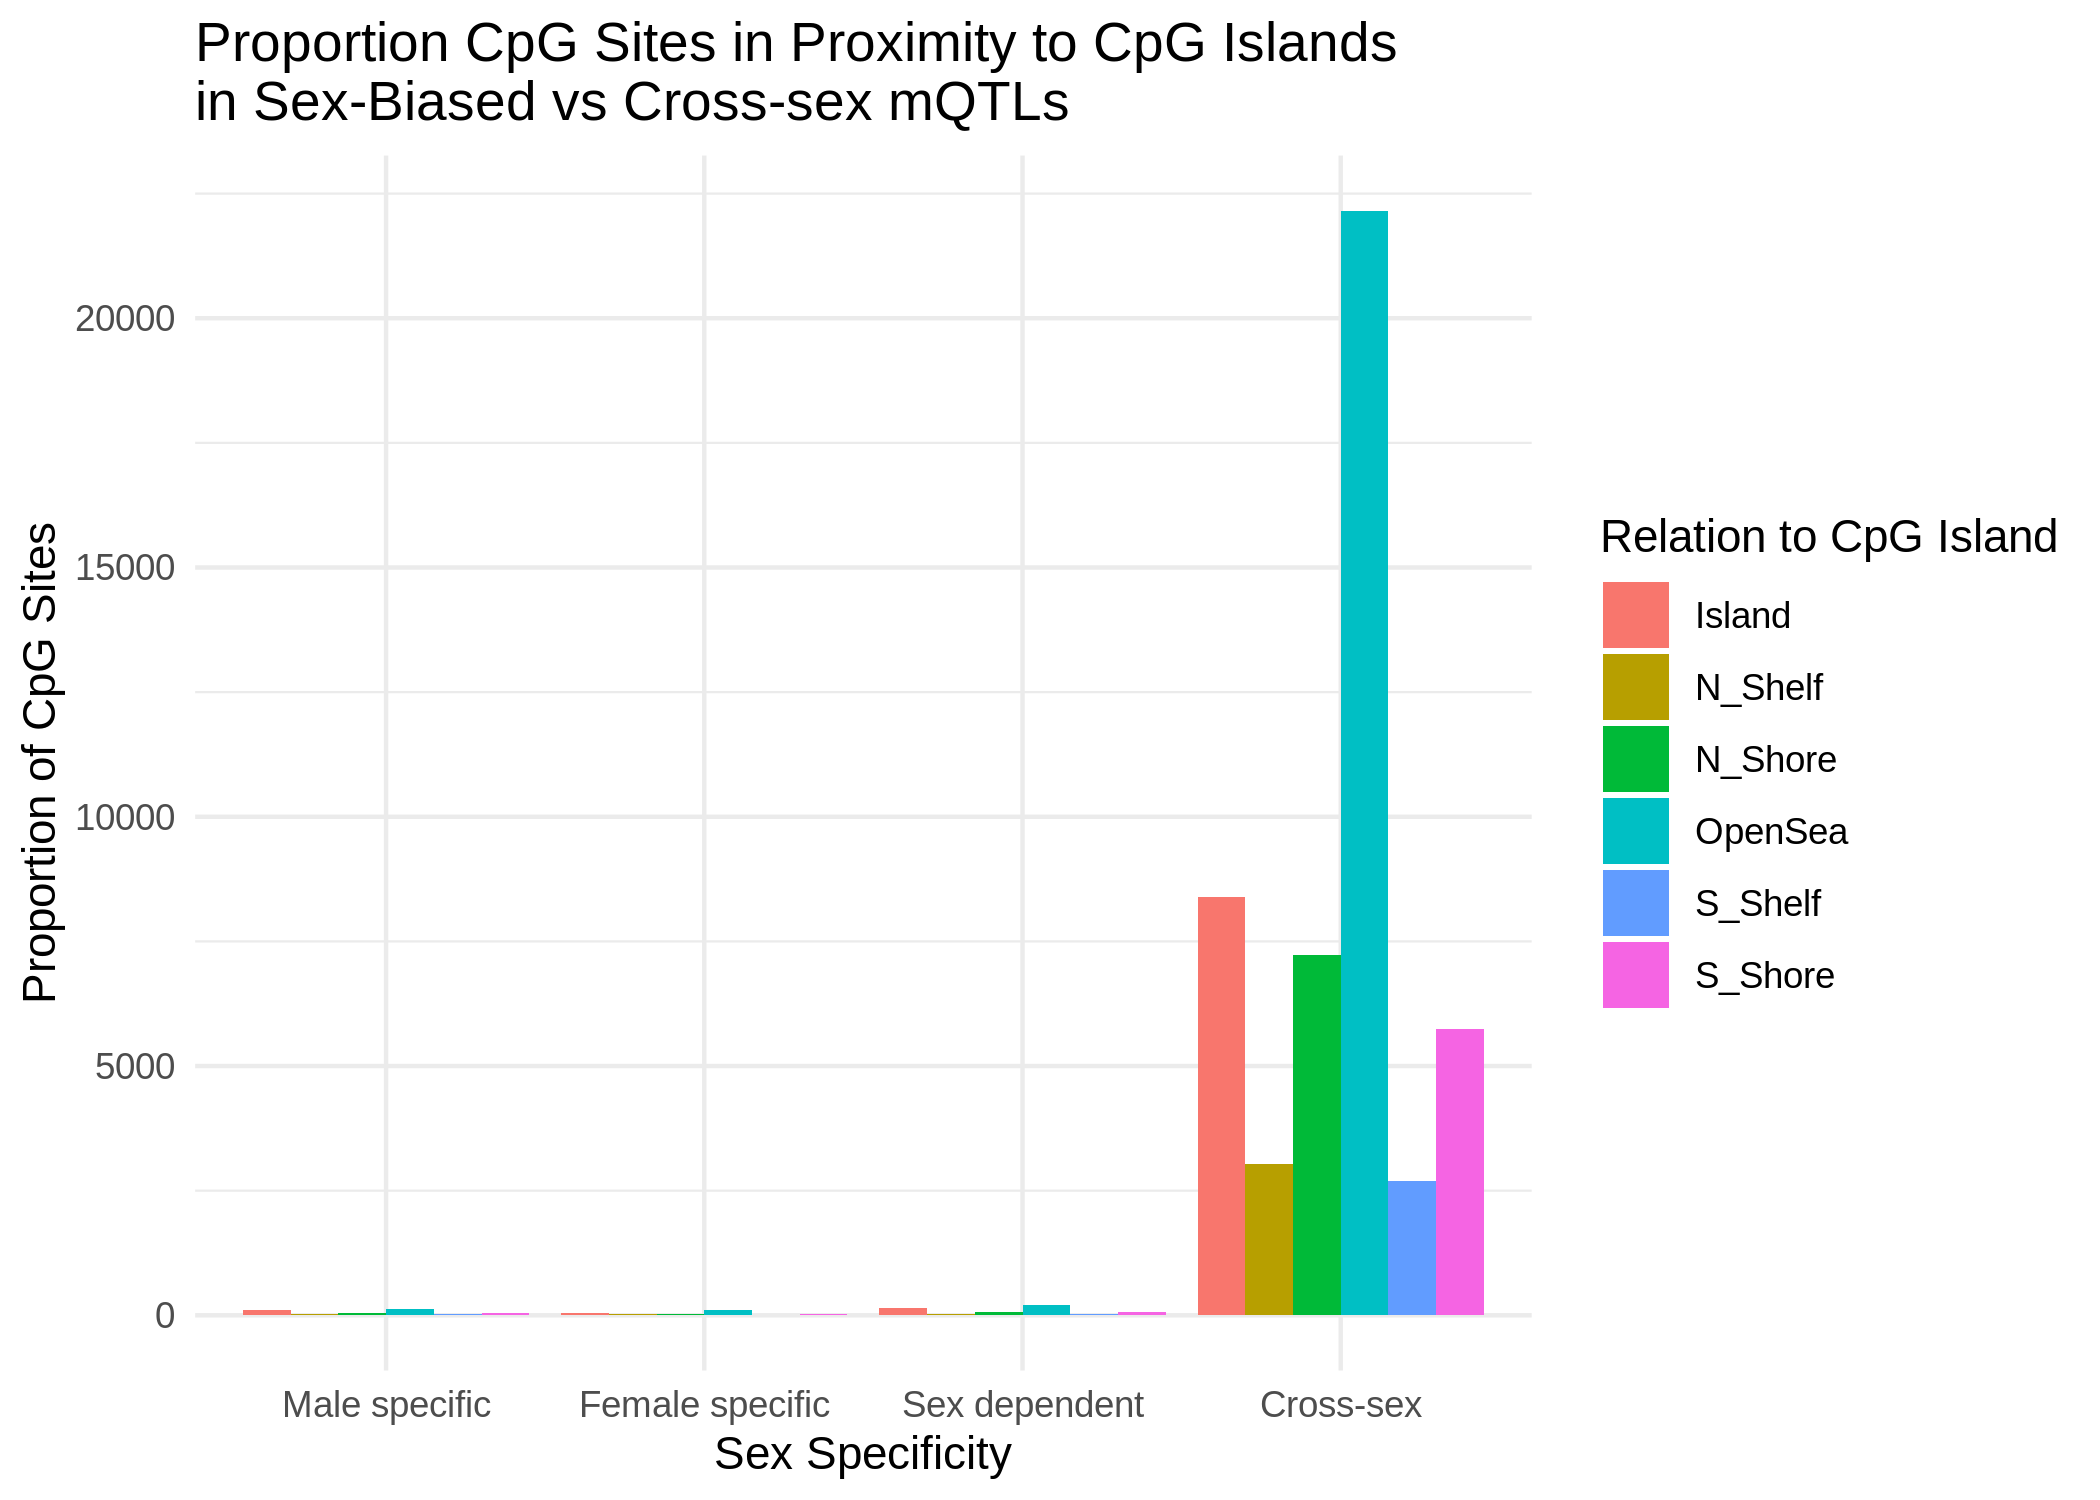

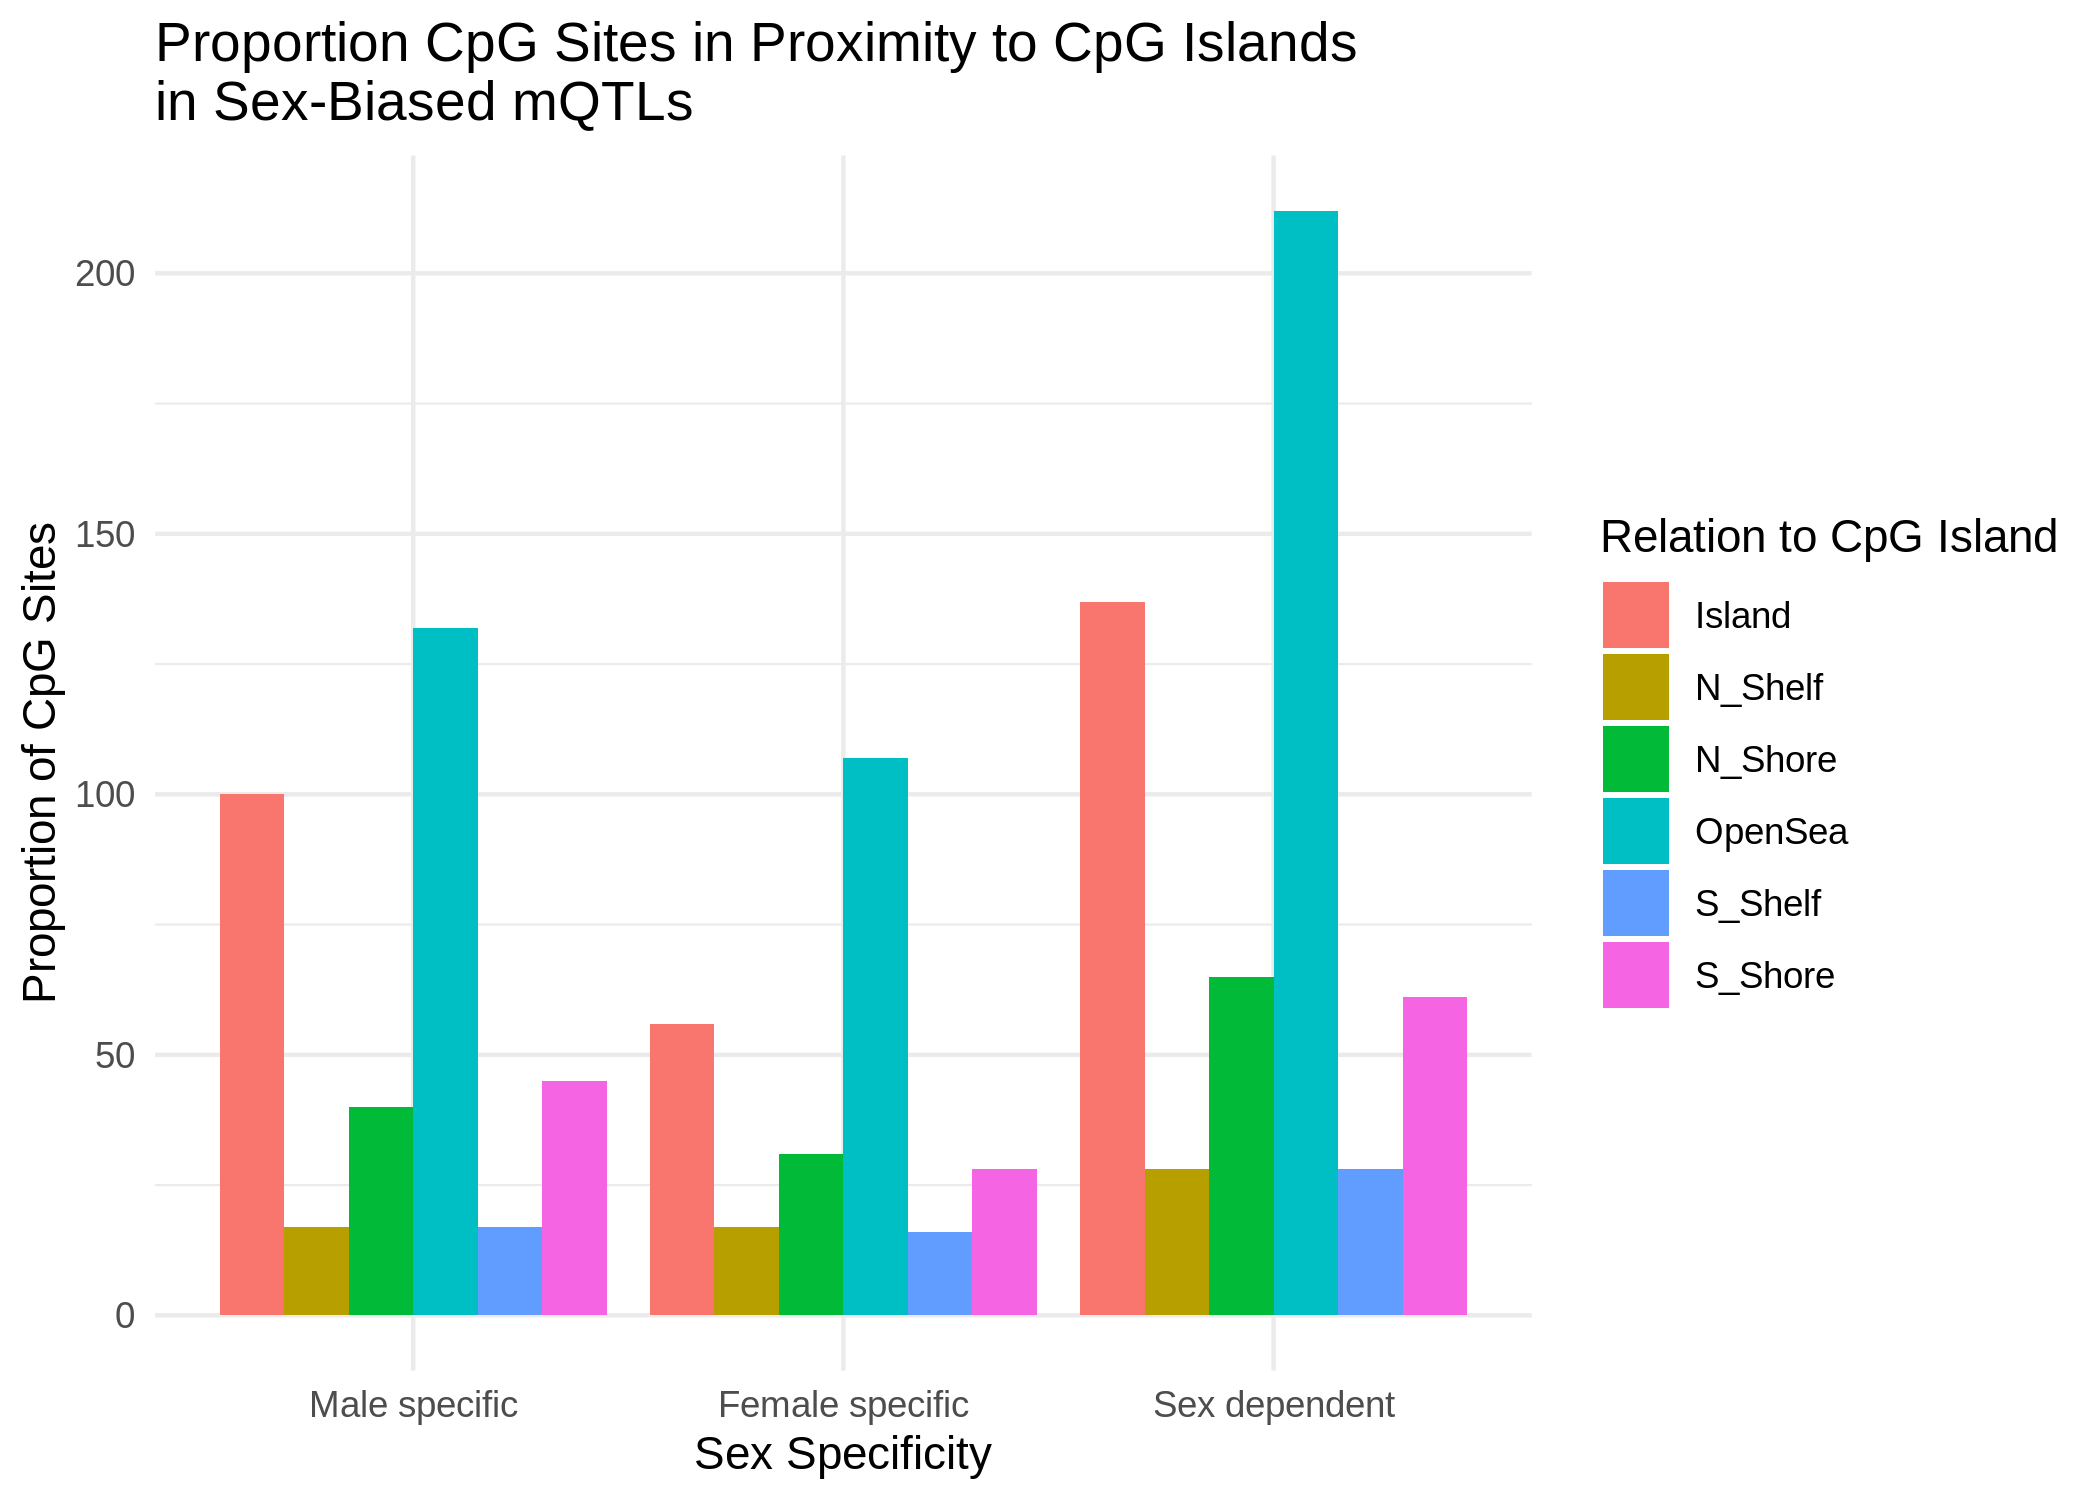

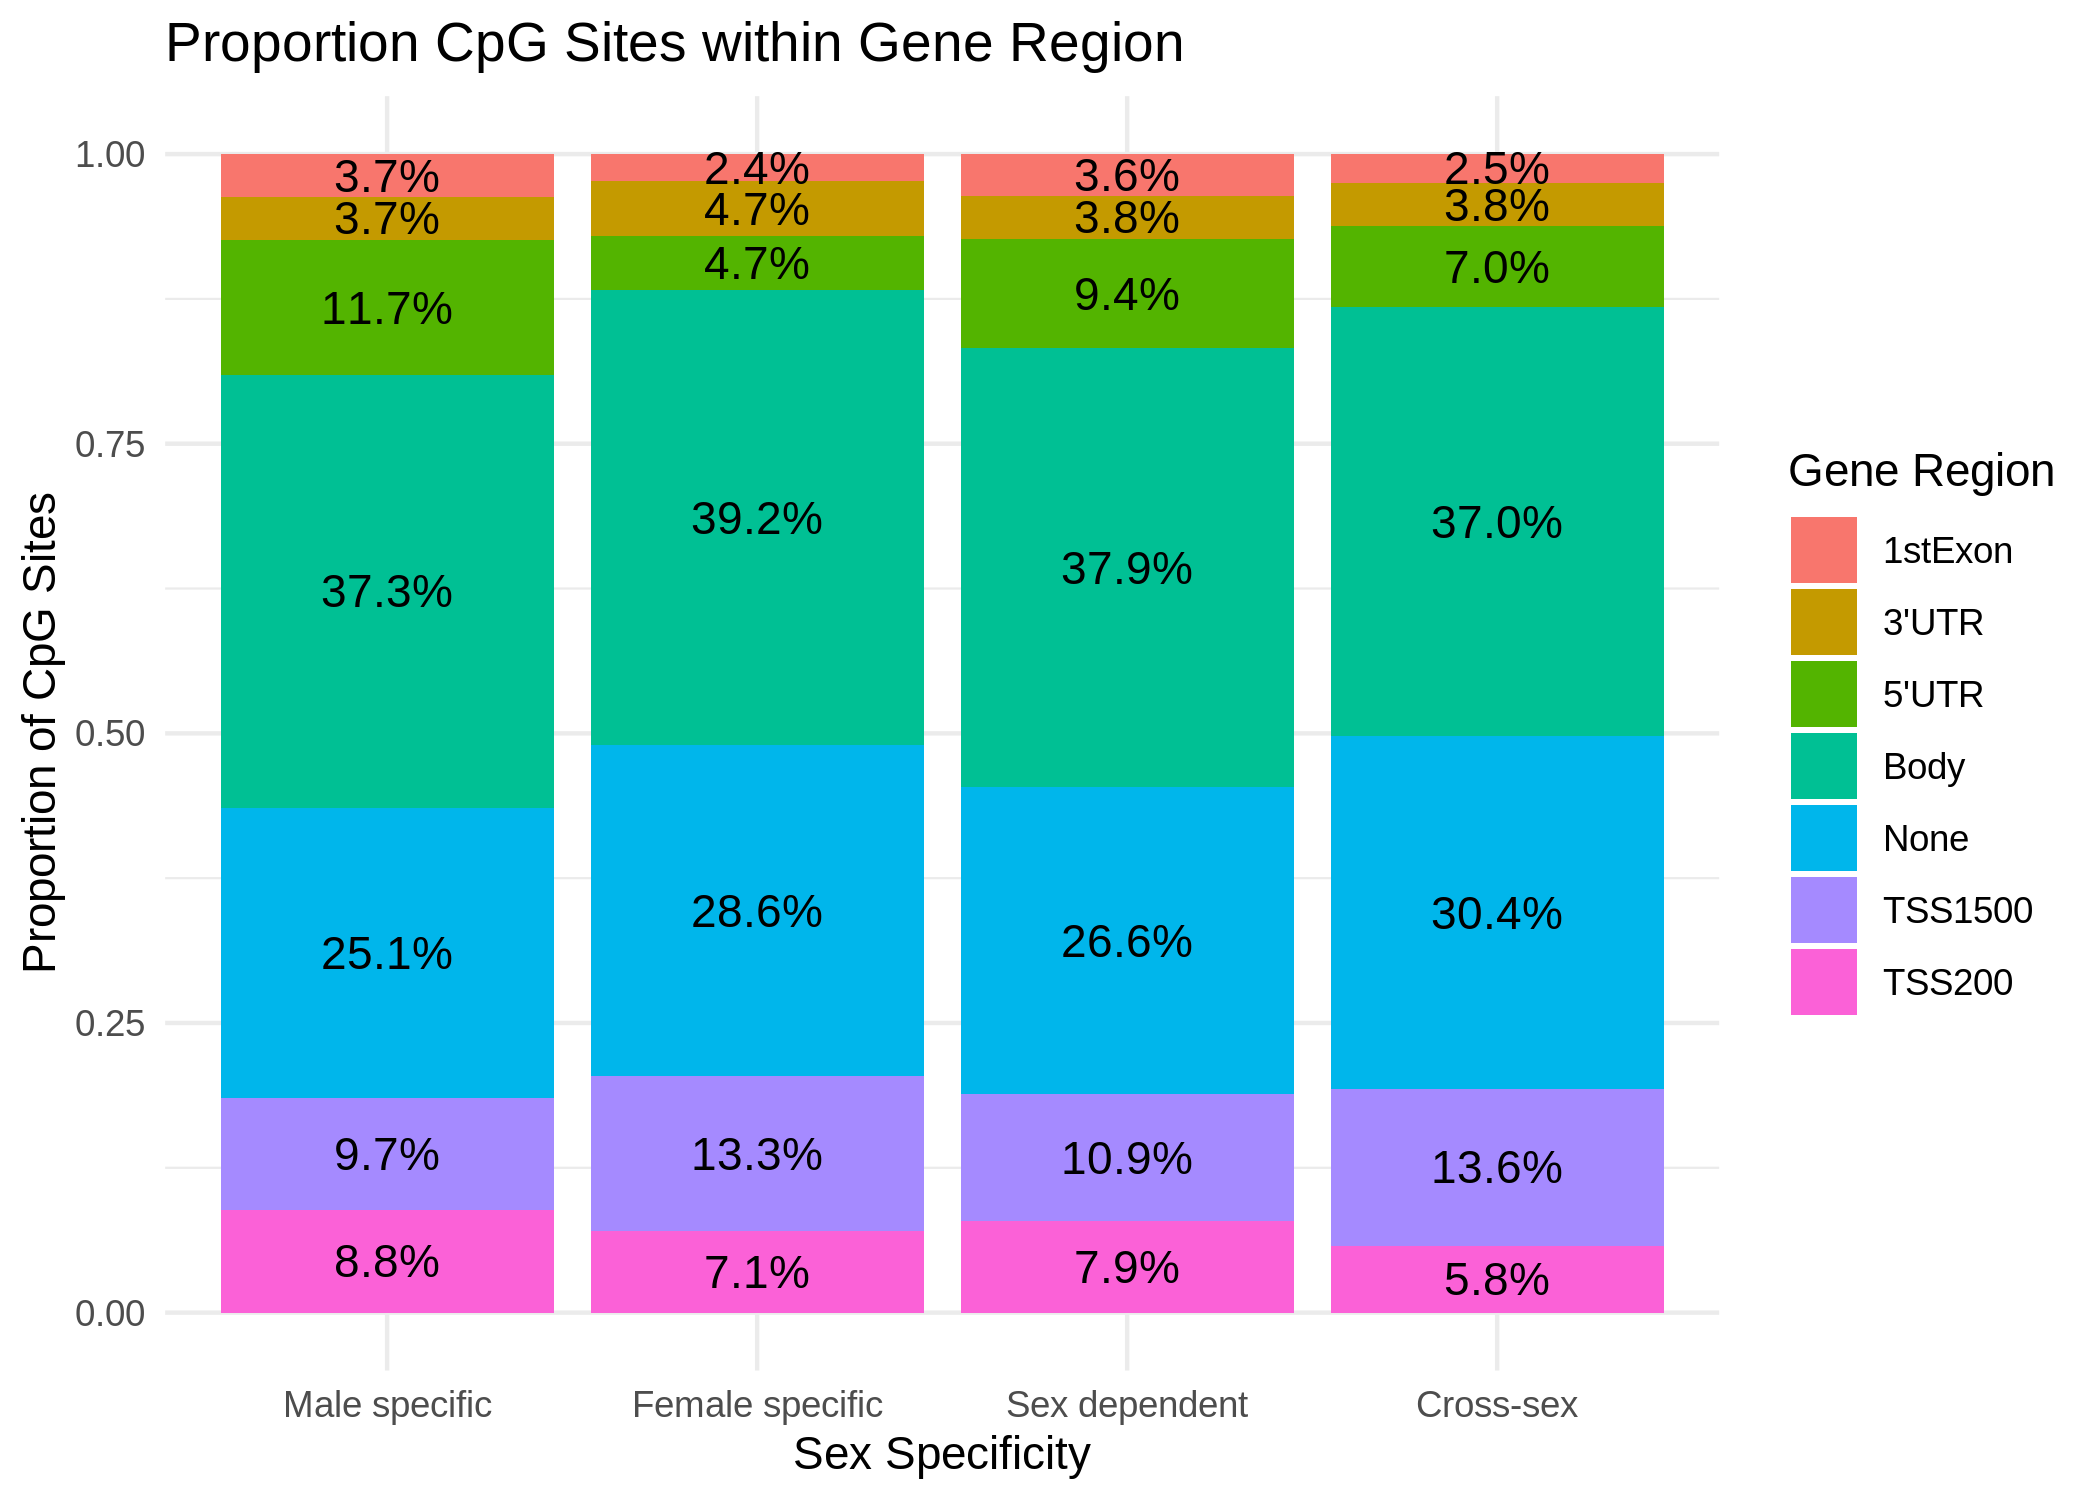

In [17]:
library(GGally)
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = factor(Relation_to_Island), by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated[Sex != "Cross-sex" & !duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased mQTLs")
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])],aes(Sex, fill = factor(sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","None",x))), by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Gene Region")+
    ggtitle("Proportion CpG Sites within Gene Region")

ERROR while rich displaying an object: Error: The by aesthetic should be a factor instead of a character.

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(o

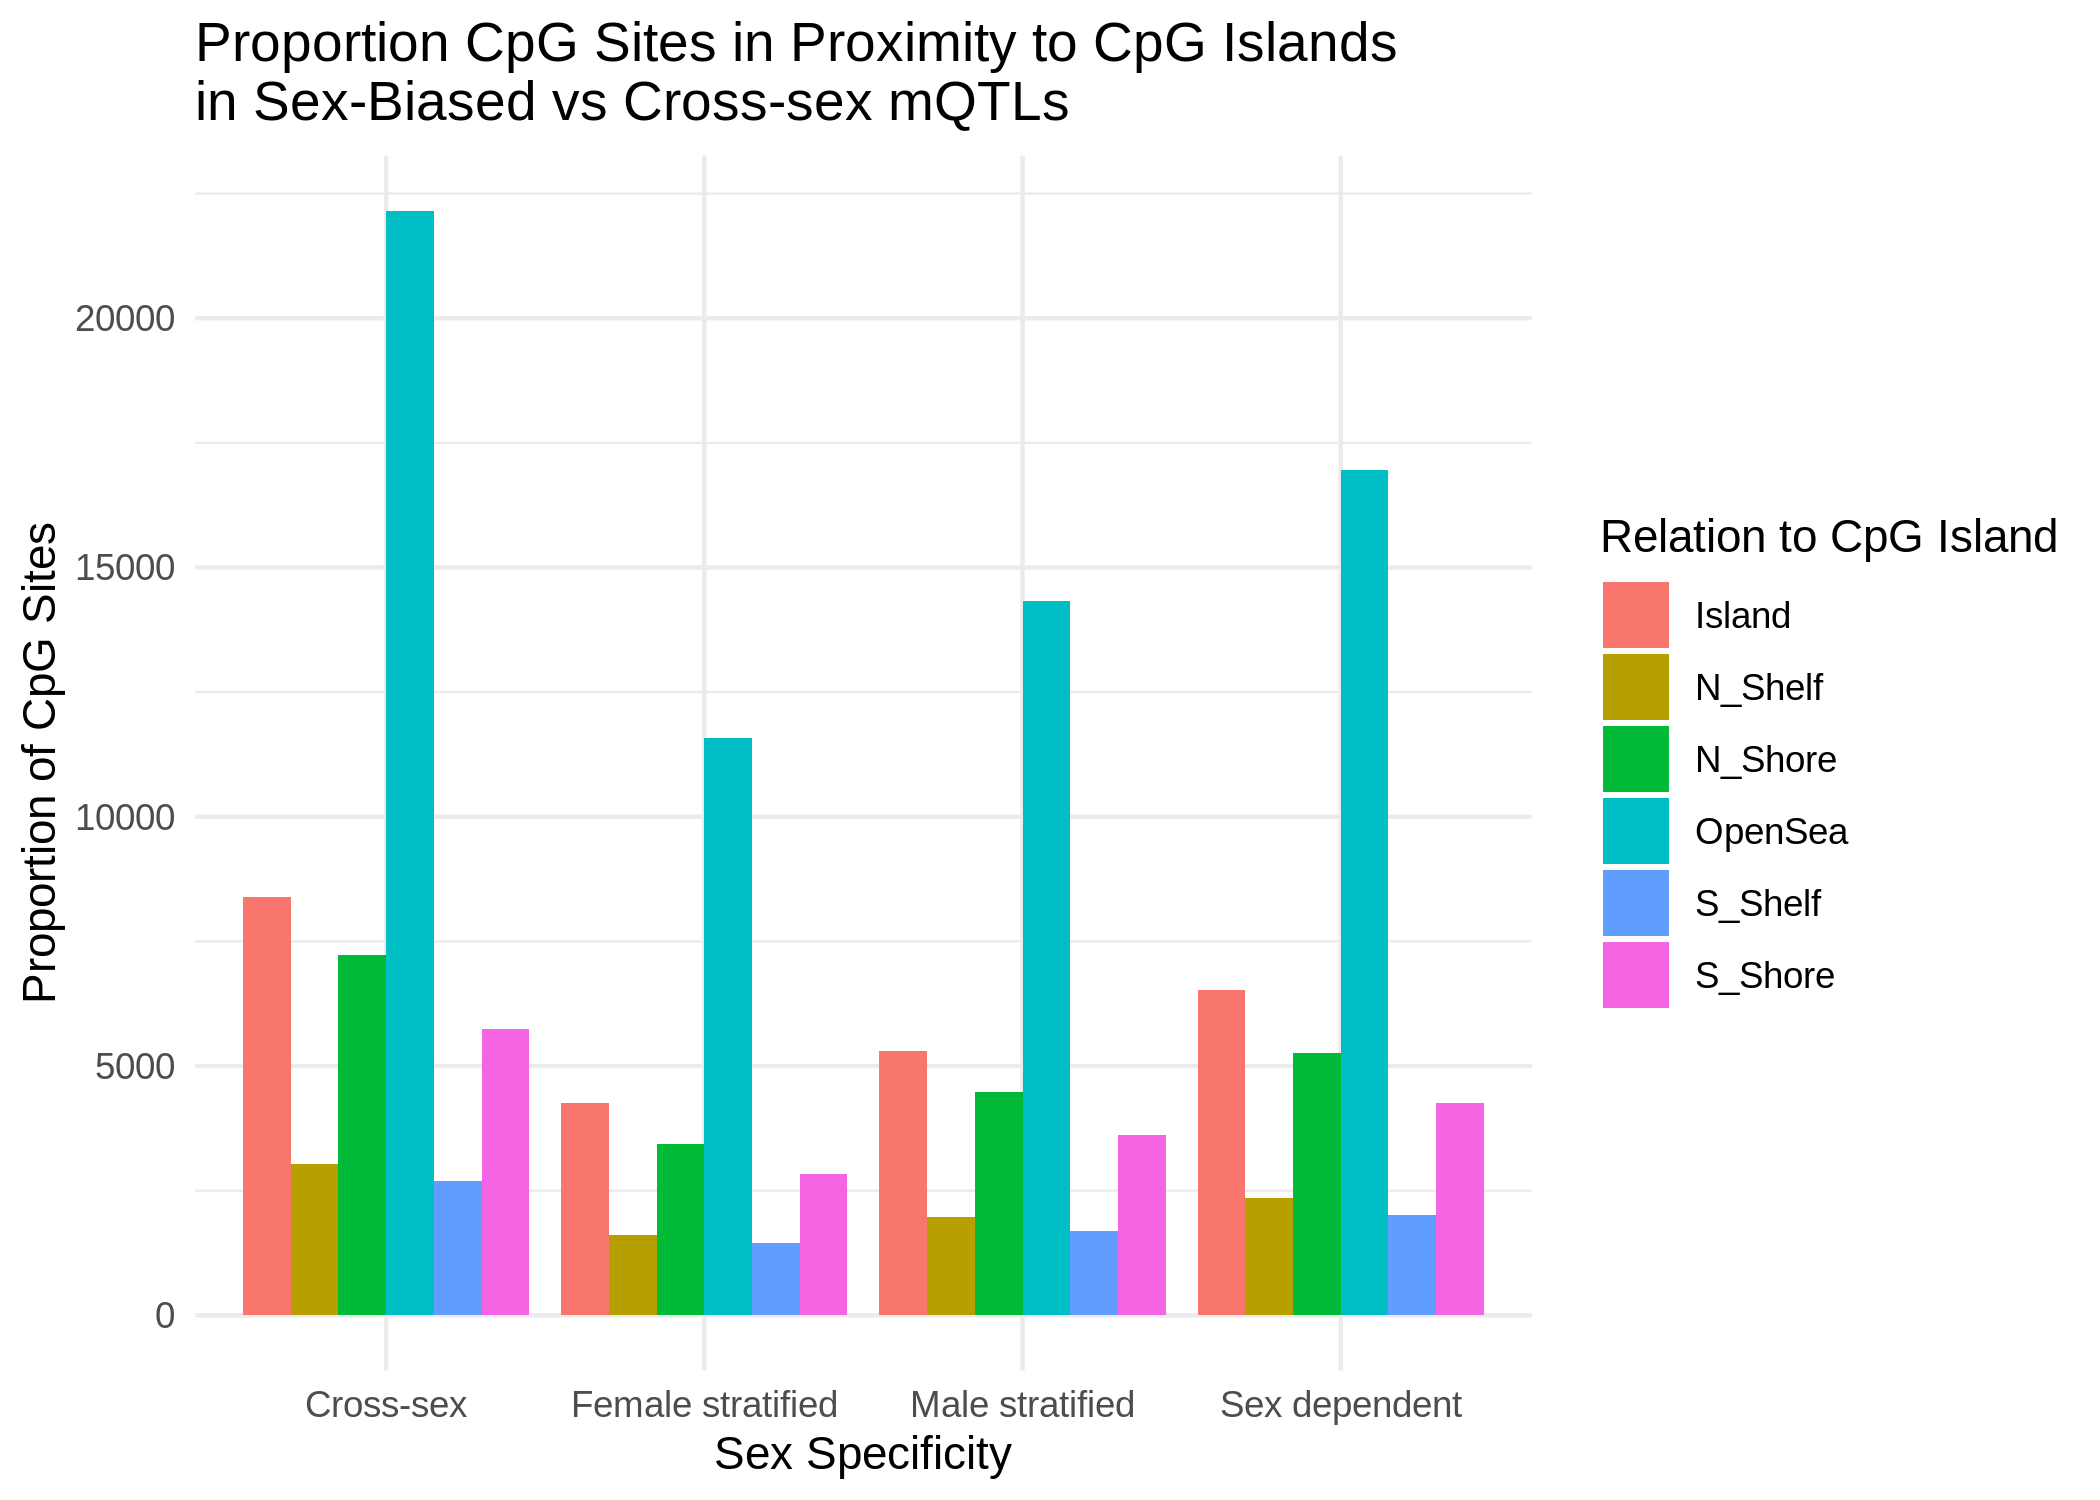

ERROR while rich displaying an object: Error: The by aesthetic should be a factor instead of a character.

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(o

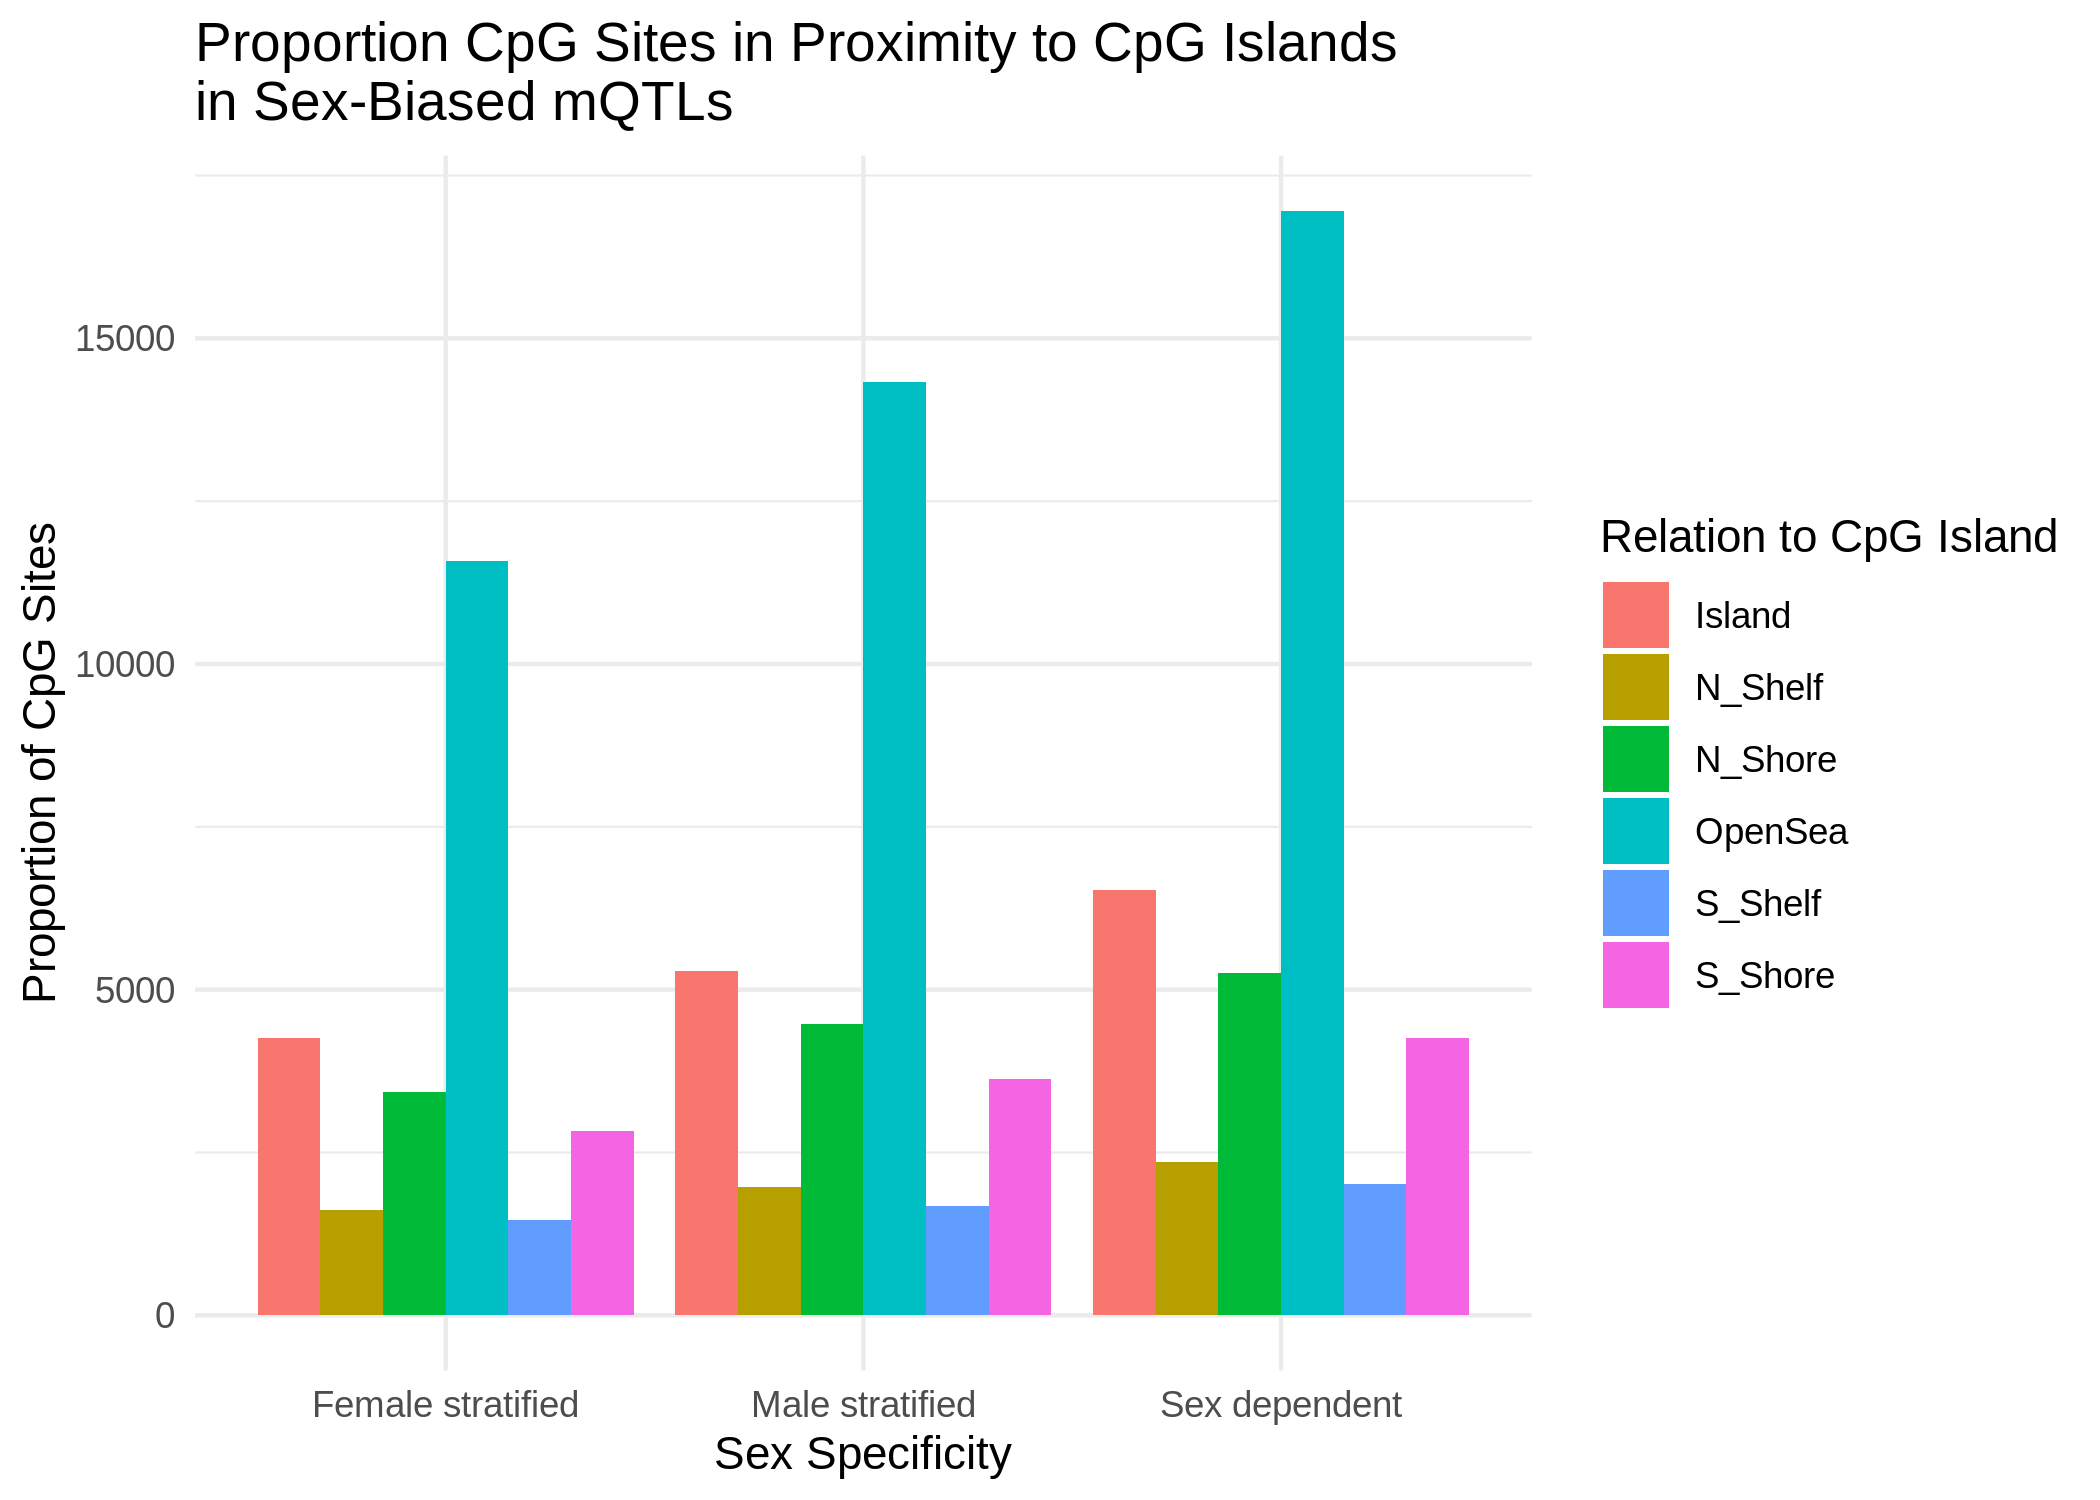

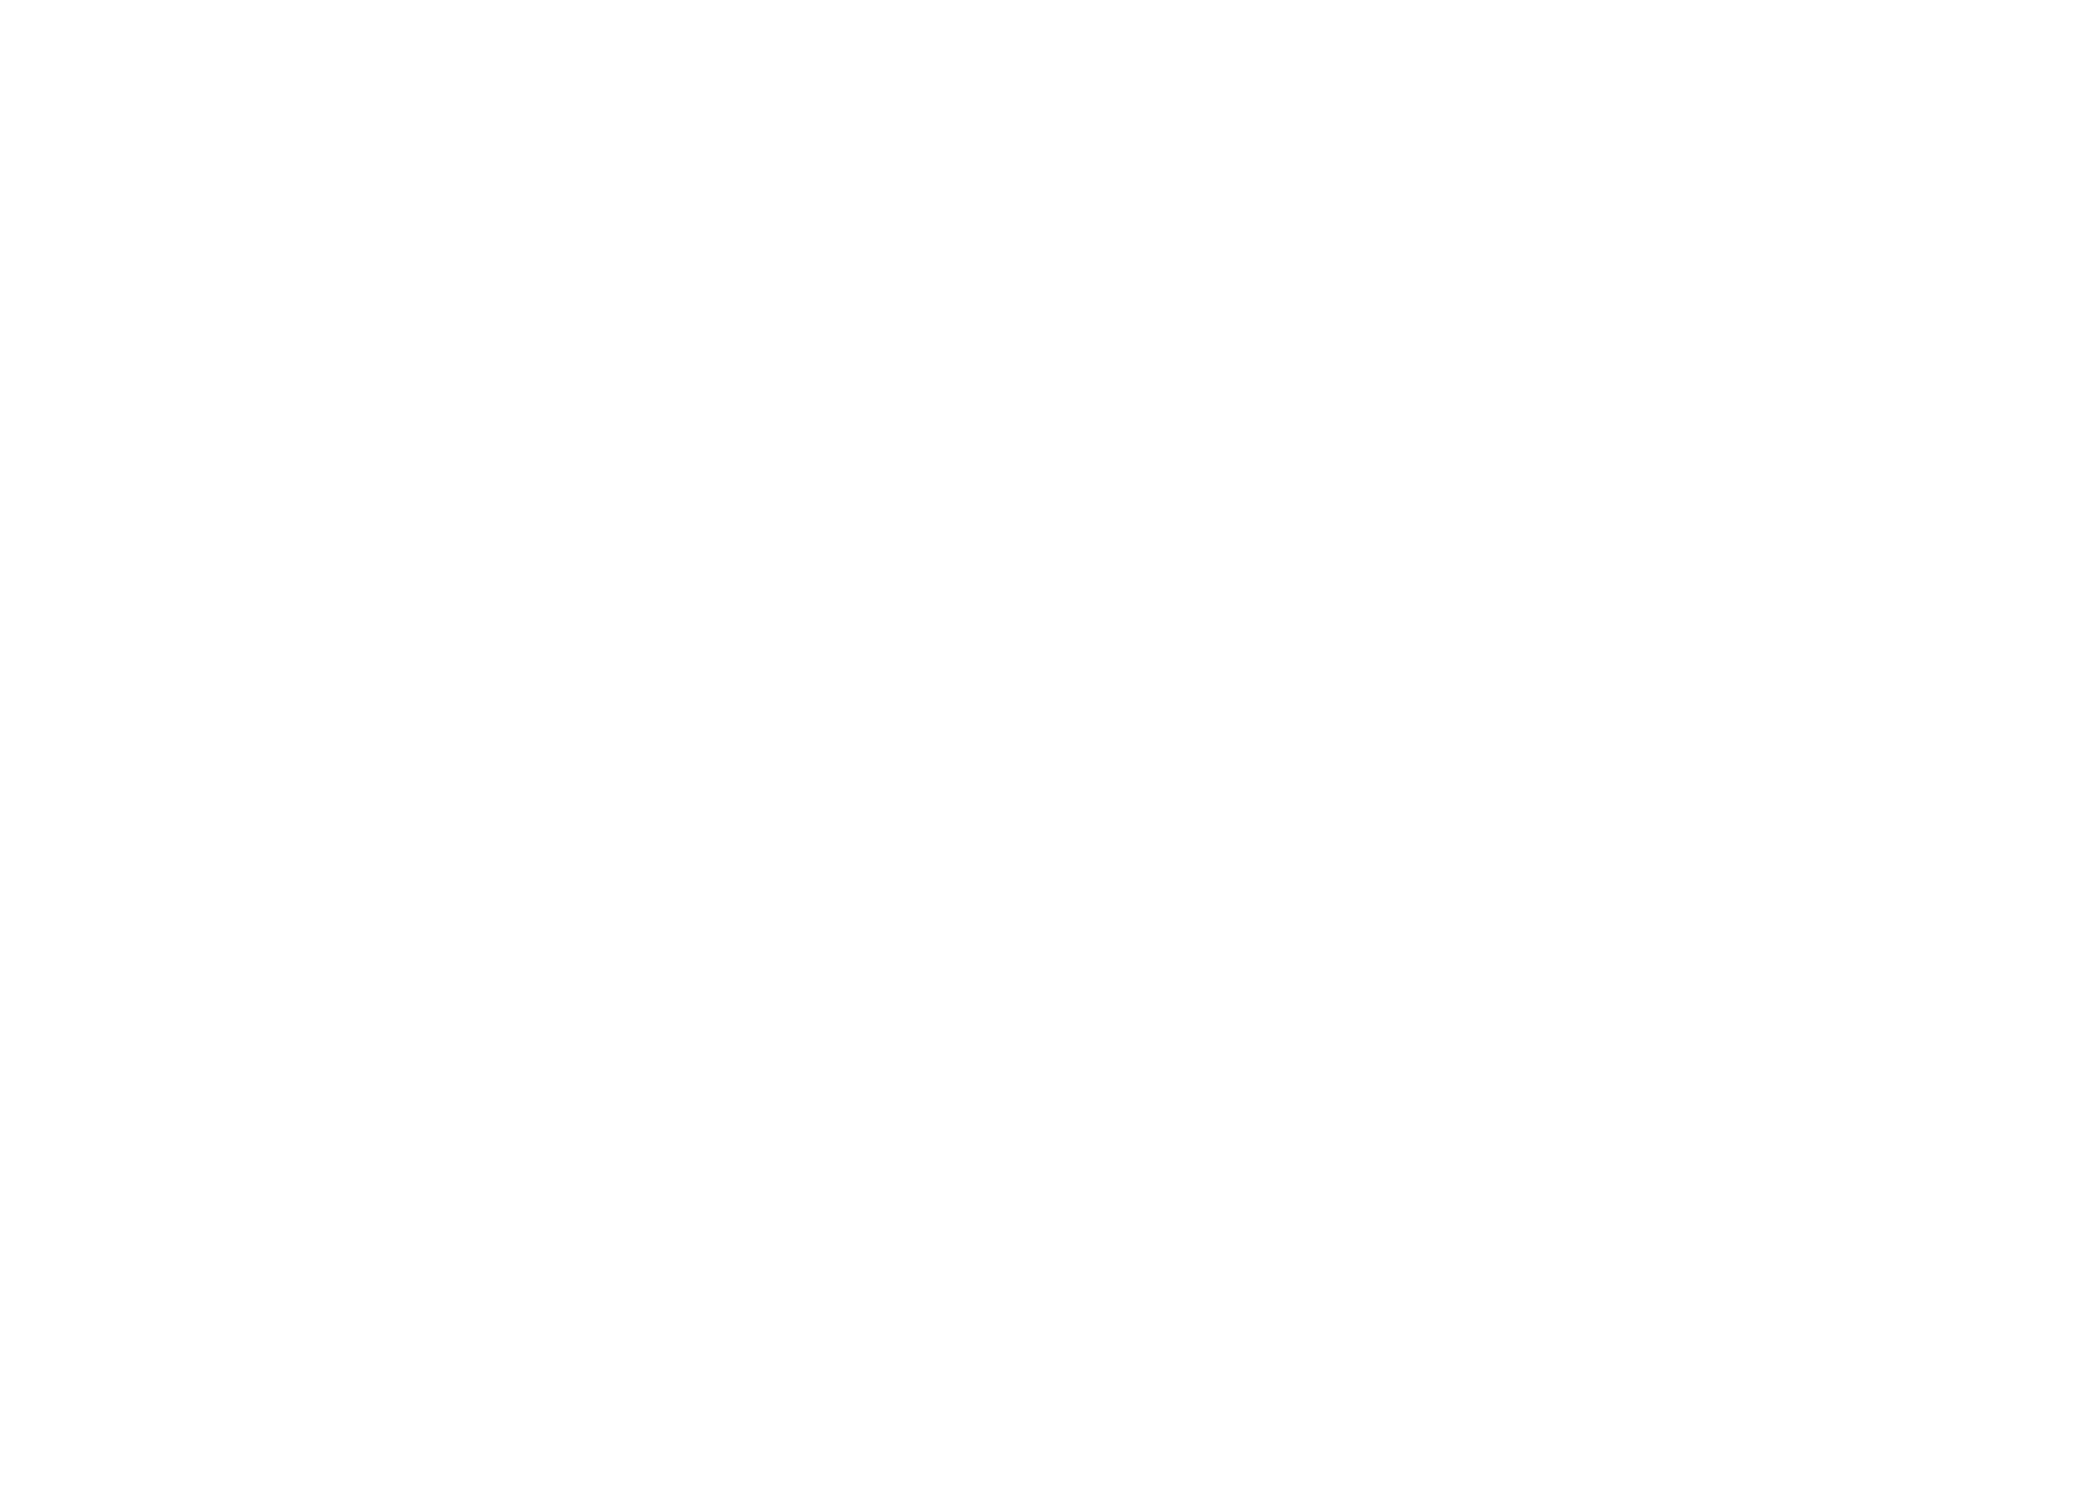

In [36]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

library(GGally)
ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Cross-sex mQTLs")

ggplot(total_annotated_strat[Sex != "Cross-sex" & !duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased mQTLs")
ggplot(total_annotated_strat[!duplicated(total_annotated_strat[,.(Probe,Sex)])], aes(Sex, fill = sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)), by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Gene Region")+
    ggtitle("Proportion CpG Sites within Gene Region")

In [19]:
fwrite(total_annotated, here("data", "total_annotated.csv.gz"))
fwrite(total_annotated_strat, here("data", "total_annotated_strat.csv.gz"))

### Plotting by weighted mean DNAm per site

In [ ]:
richs_DNAm <- fread("../../delahaye_QC/matrix_eqtl_data/methylation_matrixeQTL.txt",key = "cpg")
delahaye_DNAm <- fread("../../RICHS_QC/matrix_eqtl_data/methylation_matrixeQTL.txt",key="cpg")


dat1 <- delahaye_DNAm[,.(mean1=mean(unlist(.SD),na.rm=T),var1=1 / var(unlist(.SD),na.rm=T)),by="cpg"]
dat2 <- richs_DNAm[,.(mean2=mean(unlist(.SD),na.rm=T),var2=1 / var(unlist(.SD),na.rm=T)),by="cpg"]
merged <- merge(dat1,dat2,by="cpg",all=TRUE)

weighted_means <- merged[,.(mean_DNAm = weighted.mean(c(mean1,mean2),c(var1,var2),na.rm = TRUE)),by="cpg"]

means_strat <- merge(total_annotated_strat,weighted_means,by.x="Probe",by.y="cpg")
means_specific <- merge(total_annotated,weighted_means,by.x = "Probe",by.y = "cpg")

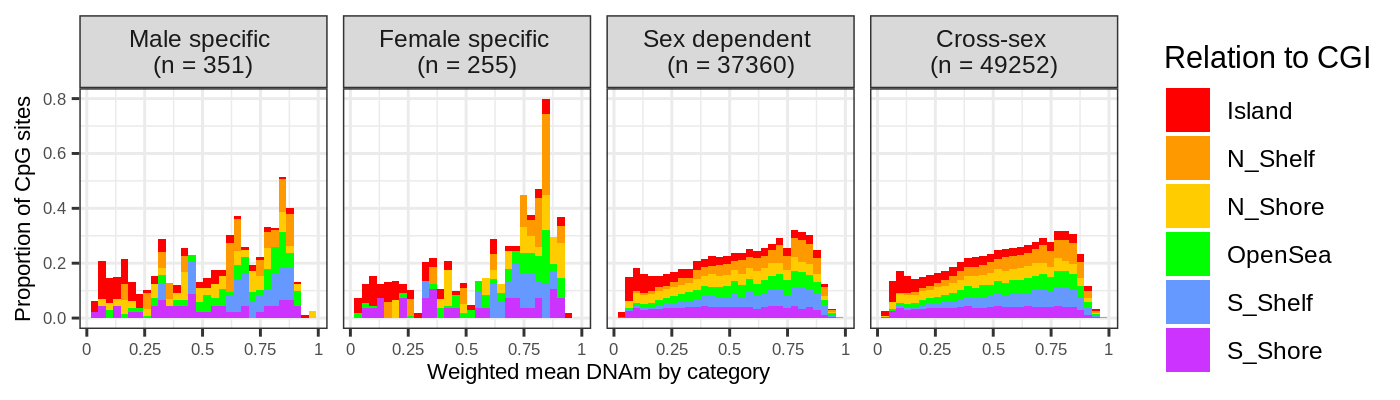

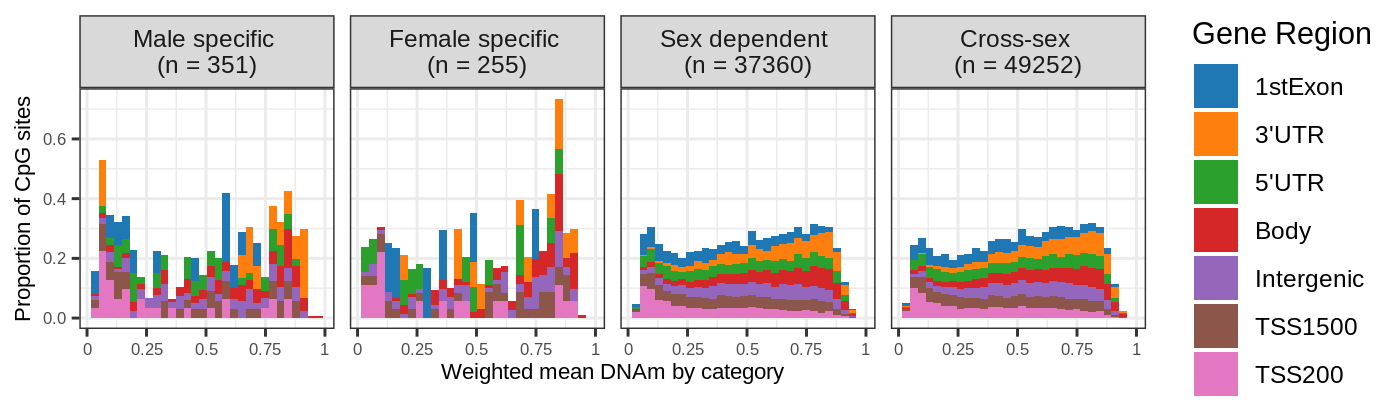

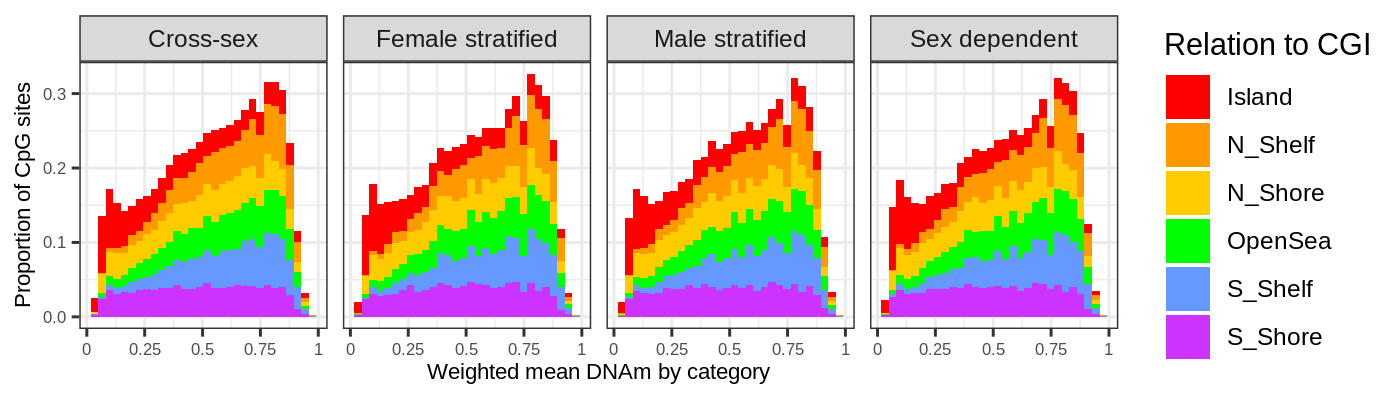

In [46]:
options(width= 12, repr.plot.height= 2, repr.plot.res = 200)
library(ggsci)
library(glue)
to_plot_specific <- unique(means_specific[Sex != "Sex dependent",.(Probe,Relation_to_Island,Sex,mean_DNAm,UCSC_RefGene_Group)])
to_plot_specific <- rbind(to_plot_specific, unique(means_strat[Sex == "Sex dependent",.(Probe,Relation_to_Island,UCSC_RefGene_Group,Sex,mean_DNAm)]))
to_plot_specific[,`:=`(group_size = .N),by="Sex"]
to_plot_specific[,`:=`(Sex = paste0(Sex," \n(n = ",group_size,")"))]
to_plot_specific[,`:=`(Sex=factor(Sex,levels=c('Male specific \n(n = 351)','Female specific \n(n = 255)','Sex dependent \n(n = 37360)','Cross-sex \n(n = 49252)'
)))]
ggplot(
    to_plot_specific,
    aes(mean_DNAm,fill=Relation_to_Island)) + 
    facet_wrap(~Sex,nrow=1)+
    geom_histogram(aes(y=stat(density*width)),bins=30) +
    scale_x_continuous(labels = c(0,0.25,0.5,0.75,1.00)) +
    scale_fill_ucscgb() + 
    labs(x= "Weighted mean DNAm by category",y="Proportion of CpG sites",fill="Relation to CGI")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))

ggplot(
    to_plot_specific,
    aes(mean_DNAm, fill = sapply(gsub(";.*","",UCSC_RefGene_Group),function(x)ifelse(x == "","Intergenic",x)))) + 
    facet_wrap(~Sex,nrow=1)+
    geom_histogram(aes(y=stat(density*width)),bins=30) +
    scale_x_continuous(labels = c(0,0.25,0.5,0.75,1.00)) +
    scale_fill_d3() + 
    labs(x= "Weighted mean DNAm by category",y="Proportion of CpG sites",fill="Gene Region")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))

ggplot(
    unique(means_strat[,.(Probe,Relation_to_Island,Sex,mean_DNAm)]),
    aes(mean_DNAm,fill=Relation_to_Island)) + 
    facet_wrap(~Sex,nrow=1)+
    geom_histogram(aes(y=stat(density*width)),bins=30) +
    scale_x_continuous(labels = c(0,0.25,0.5,0.75,1.00)) +
    scale_fill_ucscgb() + 
    labs(x= "Weighted mean DNAm by category",y="Proportion of CpG sites",fill="Relation to CGI")+
    theme_bw() +
    theme(axis.text = element_text(size=6),axis.title = element_text(size=8))

## Gene enrichments

In [41]:
total_annotated <- fread(here("data","total_annotated.csv.gz"))
total_annotated_strat <- fread(here("data","total_annotated_strat.csv.gz"))
array_genes <- unique(unlist(split(array_annot$UCSC_RefGene_Name,";")))

gtex_med_counts <- fread("/scratch/st-dennisjk-1/wcasazza/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz",skip = 2)[Description %in% array_genes]
sex_genes <- unique(unlist(split(total_annotated[Sex == "Sex dependent"]$UCSC_RefGene_Name,";")))
male_genes <- unique(unlist(split(total_annotated[Sex == "Male specific"]$UCSC_RefGene_Name,";")))
female_genes <- unique(unlist(split(total_annotated[Sex == "Female specific"]$UCSC_RefGene_Name,";")))
male_strat_genes <- unique(unlist(split(total_annotated_strat[Sex == "Male stratified"]$UCSC_RefGene_Name,";")))
female_strat_genes <- unique(unlist(split(total_annotated_strat[Sex == "Female stratified"]$UCSC_RefGene_Name,";")))

marginal_genes <- unique(unlist(split(total_annotated[Sex == "Cross-sex"]$UCSC_RefGene_Name,";")))
gtex_fisher_res <- function(set,tpm_thresh){
    select_genes <- gtex_med_counts[apply(gtex_med_counts[,-c(1,2)] > tpm_thresh,1,all)]$Description
    res <- fisher.test(fisher_mat(set,select_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value,
        TPM_threshold = tpm_thresh
    )
}

GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male Specific,5.003753e-04,1.761274e-03,1.451485e-01,3.840195e-01,2.705662e-01,0.286404887
Female Specific,3.134065e-03,1.510052e-02,1.504233e-02,3.115698e-01,1.000000e+00,0.683302615
Male Stratified,8.275159e-113,1.286136e-72,3.594124e-33,6.797992e-12,2.873377e-04,0.002340871
Female Stratified,1.842620e-85,9.641431e-54,6.917366e-26,9.747061e-09,3.218288e-03,0.032868950
Sex Dependent,4.657044e-05,4.908543e-04,1.600534e-02,8.580003e-01,6.411559e-01,0.775642490
Cross-sex,2.801171e-141,8.957350e-91,3.506077e-43,2.106885e-17,2.184716e-07,0.001488490


GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male Specific,1.927837,1.919531,1.499132,0.5464555,0.2985898,0.0000000
Female Specific,1.890396,1.791062,2.022995,1.4777425,0.7929524,1.2101193
Male Stratified,2.131974,1.961240,1.793227,1.5831064,1.3732328,1.3852812
Female Stratified,1.990712,1.831914,1.709907,1.4971608,1.3099454,1.2730089
Sex Dependent,1.893973,1.819771,1.719220,0.8747037,0.6117724,0.6194094
Cross-sex,2.215660,2.027816,1.870096,1.6954519,1.5117547,1.3713659


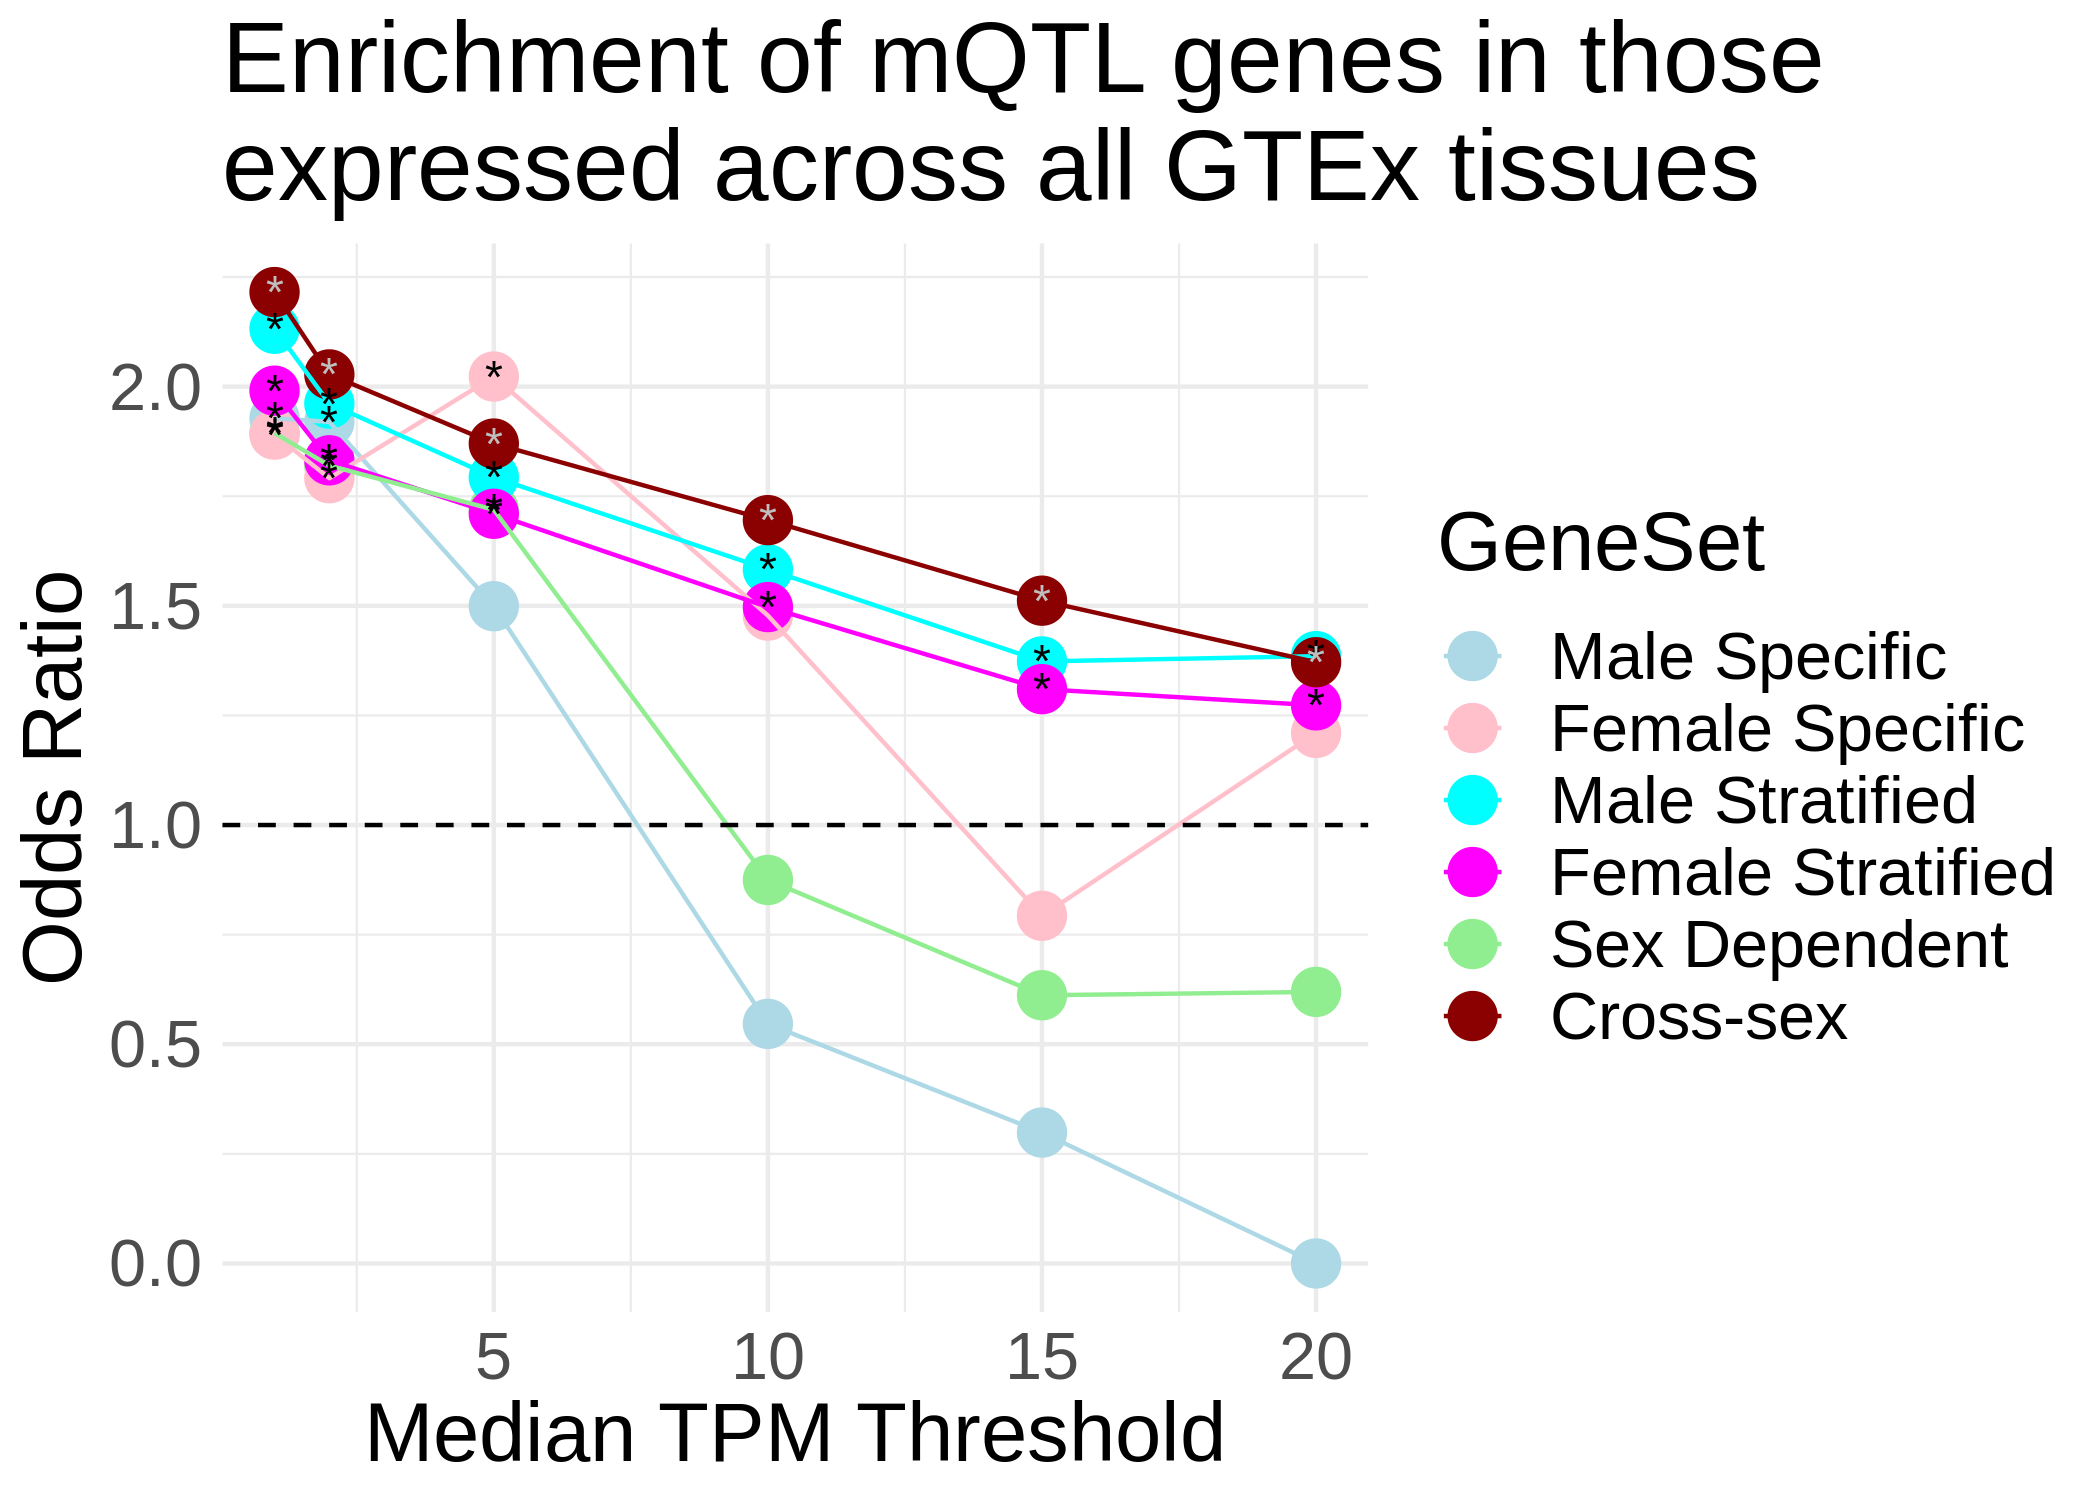

In [42]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

fisher_mat <- function(set1,set2,background){
    notset1 <- background[!background %in% set1]
    notset2 <- background[!background %in% set2]    
    res <- matrix(
        c(
            length(intersect(set1,set2)),
            length(intersect(notset1,set2)),
            length(intersect(set1,notset2)),
            length(intersect(notset1,notset2))
        ),
        byrow=T,
        nrow = 2
    )
    return(res)
}
res <- rbindlist(lapply(c(1,2,5,10,15,20),function(thresh)rbindlist(lapply(list(`Sex Dependent`=sex_genes,"Male Specific"=male_genes,"Female Specific"=female_genes, "Male Stratified"=male_strat_genes, "Female Stratified" = female_strat_genes,`Cross-sex`=marginal_genes),function(x)gtex_fisher_res(x,thresh)),idcol = 'GeneSet')))
res$GeneSet <- factor(res$GeneSet, levels = c("Male Specific","Female Specific","Male Stratified", "Female Stratified","Sex Dependent","Cross-sex"))
p <- ggplot(res,aes(TPM_threshold, y=OR, color=GeneSet)) +
    geom_point(size=5) +
    geom_line(aes(y=OR))+
    geom_text(aes(label=ifelse(P < 0.05,"*","")),color=ifelse(res$GeneSet == "Cross-sex","gray","black"))+
    geom_hline(yintercept = 1,linetype='dashed') +
    labs(
        title = "Enrichment of mQTL genes in those\nexpressed across all GTEx tissues",
        x = "Median TPM Threshold",
        y = "Odds Ratio"
    )+
    scale_color_manual(values=c("light blue", "pink", "cyan", "magenta", "light green" , "dark red"))+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p)
dcast(res,GeneSet~TPM_threshold,value.var="P")
dcast(res,GeneSet~TPM_threshold,value.var="OR")  

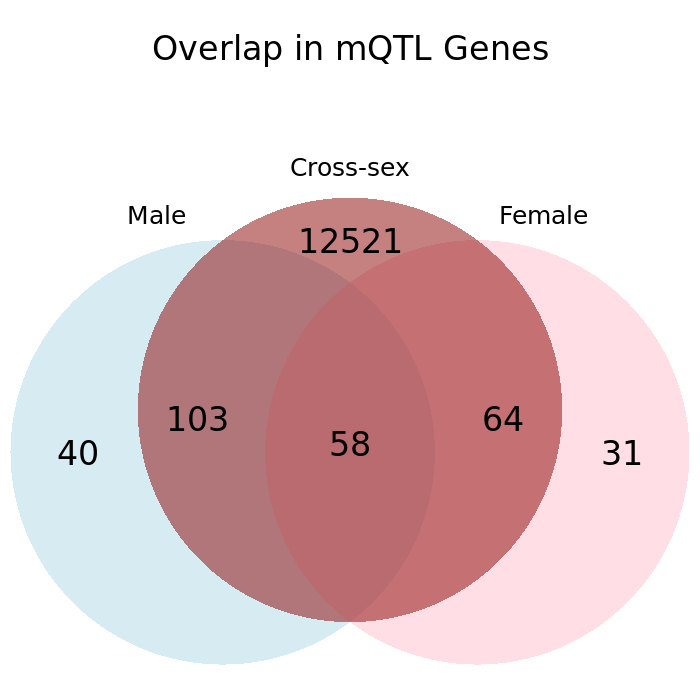

In [43]:
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 100)
grid.draw(
    venn.diagram(
        list(Male = unique(male_genes), Female = unique(female_genes),"Cross-sex" = unique(marginal_genes)),
        filename=NULL,
        fill=c("light blue", "pink", "dark Red"),
        cat.pos=c(-15,15,0),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)

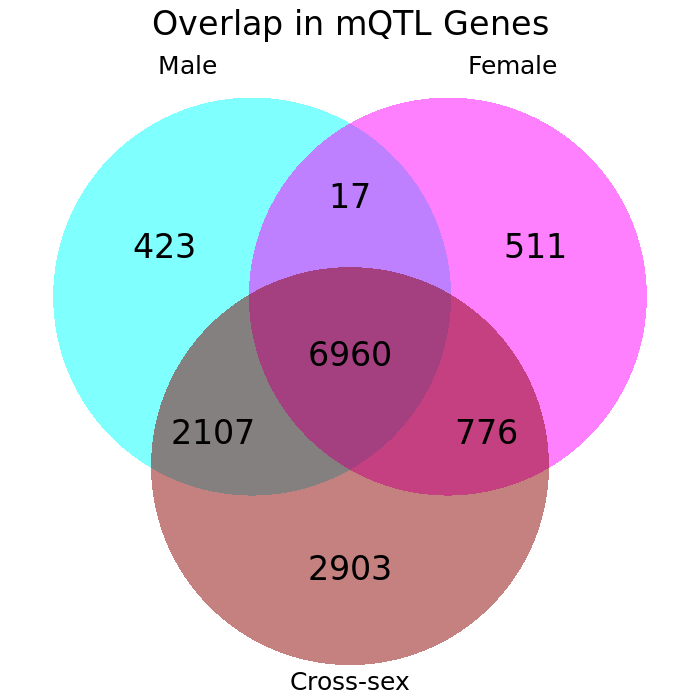

In [44]:
grid.draw(
    venn.diagram(
        list(Male = unique(male_strat_genes), Female = unique(female_strat_genes),"Cross-sex" = unique(marginal_genes)),
        filename=NULL,
        fill=c("cyan", "magenta", "dark Red"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)